## Bounce-averaged advection and diffusion coefficients for monochromatic electromagnetic ion cyclotron wave: Comparison between test-particle and quasi-linear models

Su, Zhu, Xiao, Zheng, Shen, Wang, Wang  (2012)

[Publication Link](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JA017917)



In [1]:
#import required packages
import numpy as np
import os
import sys
import inspect
import matplotlib.pyplot as plt


#Define WPIT package location
current_dir =  os.path.abspath(os.path.dirname('__file__'))
fpath = os.path.abspath(current_dir + "/..")
#Add WPIT path to Python path
sys.path.append(fpath)

#import WPIT modules
import WPIT.Environment_mod as env
import WPIT.WaveProperties_mod as wave
import WPIT.WPI_mod.parallel_EMIC_mod as wpi


### 1. Define simulation parameters

Here we define all the initial parameters of the simulation in respect with the particle and the wave

In [2]:
L_sim=4  #L-shell of the simulation 
Bw_sim=10*10**(-9) #wave magnetic field amplitude

aeq0_deg=39.3   #initial equatorial pitch angle
aeq0=np.deg2rad(aeq0_deg) #convert pitch angle to rad

Ekev0=2000 #initial energy keV
lamda0_deg=0 # starting electron latitude
lamda0=np.deg2rad(lamda0_deg) #convert latitude to rad

f_wave=1.84 # wave frequency in Hz
w_wave=2*np.pi*f_wave #wave angular frequency

eta0_deg=np.linspace(0,360,24) #initial phases of electrons, 24 electrons
eta0=np.deg2rad(eta0_deg) #convert initial phases to rad

#calculate geomagnetic field strenth
B0=32200*10**(-9) 
slat=np.sin(lamda0)
clat=np.cos(lamda0)
slat_term = np.sqrt(1 + 3*slat*slat)
B_sim=(B0/(L_sim**3))*slat_term/(clat**6)
    
wce_sim=env.omega_cyclotron(B_sim,env.const.qe,env.const.me) #electron gyrofrequency
wcHe_sim=env.omega_cyclotron(B_sim,env.const.qe,env.const.mHe) #helium gyrofrequency
wcO_sim=env.omega_cyclotron(B_sim,env.const.qe,env.const.mO) #oxygen gyrofrequency
wcH_sim=env.omega_cyclotron(B_sim,env.const.qe,env.const.mH) #hydrogen gyrofrequency


#calculate equatorial geomagnetic field strenth
slateq=np.sin(lamda0)
clateq=np.cos(lamda0)
slat_termeq = np.sqrt(1 + 3*slateq*slateq)
Beq=(B0/(L_sim**3))*slat_termeq/(clateq**6)

wce_sim_eq=env.omega_cyclotron(Beq,env.const.qe,env.const.me) #equatorial electron gyrofrequency
wcHe_sim_eq=env.omega_cyclotron(Beq,env.const.qe,env.const.mHe) #equatorial helium gyrofrequency
wmega_sim=0.96*wcHe_sim_eq #wave frequency, 96% of equatorial helium gyrofrequency

wpe_sim_eq=15*wce_sim_eq # plasma frequency, 15 times the equatorial electron gyrofrequency

ne_simeq=(wpe_sim_eq*wpe_sim_eq*env.const.me*env.const.epsilon0)/(env.const.qe*env.const.qe) #calculate equatorial electron density from electron plasma frequency

ne_sim=env.density_FL_denton(ne_simeq,lamda0) #calculate electron density
nH_sim=0.77*ne_sim #77% hydrogen
nHe_sim=0.2*ne_sim #20% helium
nO_sim=0.03*ne_sim #3% oxygen

wpe_sim=env.omega_plasma(ne_sim,env.const.qe,env.const.mH) #electron plasma frequency
wpH_sim=env.omega_plasma(nH_sim,env.const.qe,env.const.mH) #hydrogen plasma frequency
wpHe_sim=env.omega_plasma(nHe_sim,env.const.qe,env.const.mHe) #helium plasma frequency
wpO_sim=env.omega_plasma(nO_sim,env.const.qe,env.const.mO) #oxygen plasma frequency

alpha0=env.aeq2alpha(L_sim,lamda0,aeq0) #initial local pitch angle
musq0=wave.refr_index_parallel_EMIC(w_wave,wpe_sim,wce_sim,wpH_sim,wcH_sim,wpO_sim,wcO_sim,wpHe_sim,wcHe_sim) #refractive index
kappa0=np.sqrt(musq0)*w_wave/env.const.c_light #wave number
upar0,uper0,ppar0,pper0,gamma0=env.initial_velocity(Ekev0,alpha0,env.const.me) #initial velocity, energy and lorentz factor    


dwc_ds0=env.dwc_ds(wce_sim,lamda0,L_sim) #gradient of the electron gyrofrequency
dk_dt=0 #time derivative of the wave number

#calculate initial non-linear parameters
H0=wpi.nonlinear_H(pper0,ppar0,kappa0,gamma0,env.const.me,wce_sim,dk_dt,dwc_ds0,0)
thet0,wtsq0=wpi.nonlinear_theta(pper0,ppar0,Bw_sim,kappa0,gamma0,env.const.me,env.const.qe,wce_sim,wmega_sim)
S0=wpi.nonlinear_S(H0,wtsq0)

### Integration parameters ##################################################################

t=0.07 #simulation duration (s)
h=0.00001  #simulation stepsize
Nsteps=int(t/h) #number of simulation steps



### 2. Allocate outputs

In [3]:
#define empty arrays to be filled during the simulation run
pper=np.zeros((len(eta0),Nsteps+1))
ppar=np.zeros((len(eta0),Nsteps+1))
eta=np.zeros((len(eta0),Nsteps+1))
lamda=np.zeros((len(eta0),Nsteps+1))
time=np.zeros((len(eta0),Nsteps+1))
uper=np.zeros((len(eta0),Nsteps+1))
upar=np.zeros((len(eta0),Nsteps+1))
zeta=np.zeros((len(eta0),Nsteps+1))
alpha=np.zeros((len(eta0),Nsteps+1))
aeq=np.zeros((len(eta0),Nsteps+1))
vresz_o=np.zeros((len(eta0),Nsteps+1))
Eres_o=np.zeros((len(eta0),Nsteps+1))
mu_adiabatic=np.zeros((len(eta0),Nsteps+1))
deta_dt=np.zeros((len(eta0),Nsteps+1))
kappa_out=np.zeros((len(eta0),Nsteps+1))
kx_out=np.zeros((len(eta0),Nsteps+1))
kz_out=np.zeros((len(eta0),Nsteps+1))
gamma=np.zeros((len(eta0),Nsteps+1))
E_kin=np.zeros((len(eta0),Nsteps+1))
ref_sq=np.zeros((len(eta0),Nsteps+1))
u_res_out=np.zeros((len(eta0),Nsteps+1))
H_out=np.zeros((len(eta0),Nsteps+1))
S_out=np.zeros((len(eta0),Nsteps+1))
detadt_out=np.zeros((len(eta0),Nsteps+1))
wtrsq_out=np.zeros((len(eta0),Nsteps+1))
thet_out=np.zeros((len(eta0),Nsteps+1))

### Calculate initial $d\eta/dt$ for each electron

In [4]:
detasts_0=[]
for k in range(0,len(eta0)):
    eta0tmp=wpi.detadt(ppar0,pper0,eta0[k],Bw_sim,wmega_sim,kappa0,wce_sim,gamma0,env.const.qe,env.const.me,'electron')
    detasts_0.append(eta0tmp)

### Runge-Kutta

In [5]:
for k in range(0,len(eta0)):
    
    #initialize the parameters
    i=0
    time[k,0]=0
    pper[k,0]=pper0
    ppar[k,0]=ppar0
    eta[k,0]=eta0[k]
    lamda[k,0]=lamda0
    zeta[k,0]=0
    upar[k,0]=upar0
    uper[k,0]=uper0
    alpha[k,0]=alpha0
    aeq[k,0]=aeq0
    gamma[k,0]=gamma0
    E_kin[k,0]=1.602176487E-16*Ekev0
    ref_sq[k,0]=musq0
    kappa_out[k,0]=kappa0
    H_out[k,0]=H0
    S_out[k,0]=S0
    detadt_out[k,0]=detasts_0[k]
    wtrsq_out[k,0]=wtsq0
    thet_out[k,0]=thet0

    
    while i<Nsteps:
        
#    ######################################################################################################
#    #First step of Runge Kutta
#    ######################################################################################################

        #define wave field, waves located between -28 and 28 degrees magnetic latitude
        if lamda[k,i]<np.deg2rad(28) and lamda[k,i]>-np.deg2rad(28):
            Bw_sim=Bw_sim
        else:
            Bw_sim=0

        B0=32200*10**(-9)
        slat=np.sin(lamda[k,i])
        clat=np.cos(lamda[k,i])
        slat_term = np.sqrt(1 + 3*slat*slat)
        Bmagtmp=(B0/(L_sim**3))*slat_term/(clat**6)

        #calculate electron and ion densities
        n_etmp=env.density_FL_denton(ne_simeq,lamda[k,i])
        n_Htmp=0.77*n_etmp
        n_Hetmp=0.2*n_etmp
        n_Otmp=0.03*n_etmp

        #calculate electron and ion gyrofrequencies
        wcetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.me)
        wcHtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mH)
        wcHetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mHe)
        wcOtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mO)
        
        #calculate electron and ion plasma frequencies
        wpetmp=env.omega_plasma(n_etmp,env.const.qe,env.const.me)
        wpHtmp=env.omega_plasma(n_Htmp,env.const.qe,env.const.mH)
        wpHetmp=env.omega_plasma(n_Hetmp,env.const.qe,env.const.mHe)
        wpOtmp=env.omega_plasma(n_Otmp,env.const.qe,env.const.mO)

        #calculate the refractive index
        musqtmp=wave.refr_index_parallel_EMIC(w_wave,wpetmp,wcetmp,wpHtmp,wcHtmp,wpOtmp,wcOtmp,wpHetmp,wcHetmp)
        
        #calculate the wave number
        kappatmp=np.sqrt(musqtmp)*w_wave/env.const.c_light
        
        #calculate the gradient of the electron gyrofrequency
        dwh_dstmp=env.dwc_ds(wcetmp,lamda[k,i],L_sim)
        
        #calculate momentum magnitude
        p_mag=np.sqrt(ppar[k,i]*ppar[k,i]+pper[k,i]*pper[k,i])
        
        #calculate Lorentz factor
        gammatmp=gamma[k,i]

        #calculate the Runge-Kutta coeeficients for each differential equation
        k1=wpi.dzdt(ppar[k,i],gammatmp,env.const.me)
        l1=wpi.dppardt(pper[k,i],eta[k,i],wcetmp,Bw_sim,gammatmp,dwh_dstmp,env.const.qe,env.const.me)
        m1=wpi.dpperdt(ppar[k,i],pper[k,i],eta[k,i],Bw_sim,gammatmp,wmega_sim,kappatmp,wcetmp,dwh_dstmp,env.const.qe,env.const.me)
        n1=wpi.detadt(ppar[k,i],pper[k,i],eta[k,i],Bw_sim,w_wave,kappatmp,wcetmp,gammatmp,env.const.qe,env.const.me,'electron')
        o1=wpi.dlamdadt(ppar[k,i],lamda[k,i],gammatmp,env.const.me,L_sim)
        p1=wpi.dalphadt(ppar[k,i],pper[k,i],eta[k,i],gammatmp,wcetmp,dwh_dstmp,w_wave,kappatmp,Bw_sim,env.const.me,env.const.qe)
        q1=wpi.daeqdt(ppar[k,i],pper[k,i],eta[k,i],gammatmp,w_wave,kappatmp,Bw_sim,aeq[k,i],alpha[k,i],env.const.me,env.const.qe)
        r1=wpi.dgammadt(pper[k,i],eta[k,i],gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        s1=wpi.dEkdt(pper[k,i],eta[k,i],gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        

#    ######################################################################################################
#    #Second step of Runge Kutta
#    ######################################################################################################

        #define wave field, waves located between -28 and 28 degrees magnetic latitude
        if (lamda[k,i]+0.5*h*o1)<np.deg2rad(28) and (lamda[k,i]+0.5*h*o1)>-np.deg2rad(28):
            Bw_sim=Bw_sim
        else:
            Bw_sim=0
        
        #calculate geomagnetic field strength
        B0=32200*10**(-9)
        slat=np.sin(lamda[k,i]+0.5*h*o1)
        clat=np.cos(lamda[k,i]+0.5*h*o1)
        slat_term = np.sqrt(1 + 3*slat*slat)
        Bmagtmp=(B0/(L_sim**3))*slat_term/(clat**6)
      
        #calculate electron and ion densities
        n_etmp=env.density_FL_denton(ne_simeq,lamda[k,i]+0.5*h*o1)
        n_Htmp=0.77*n_etmp
        n_Hetmp=0.2*n_etmp
        n_Otmp=0.03*n_etmp

        #calculate electron and ion gyrofrequencies
        wcetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.me)
        wcHtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mH)
        wcHetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mHe)
        wcOtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mO)
        
        #calculate electron and ion plasma frequencies
        wpetmp=env.omega_plasma(n_etmp,env.const.qe,env.const.me)
        wpHtmp=env.omega_plasma(n_Htmp,env.const.qe,env.const.mH)
        wpHetmp=env.omega_plasma(n_Hetmp,env.const.qe,env.const.mHe)
        wpOtmp=env.omega_plasma(n_Otmp,env.const.qe,env.const.mO)

        #calculate the refractive index
        musqtmp=wave.refr_index_parallel_EMIC(w_wave,wpetmp,wcetmp,wpHtmp,wcHtmp,wpOtmp,wcOtmp,wpHetmp,wcHetmp)
        
        #calculate the wave number
        kappatmp=np.sqrt(musqtmp)*w_wave/env.const.c_light
        
        #calculate the gradient of the electron gyrofrequency
        dwh_dstmp=env.dwc_ds(wcetmp,lamda[k,i]+0.5*h*o1,L_sim)
        
        #calculate momentum magnitude
        p_mag=np.sqrt((ppar[k,i]+0.5*h*l1)*(ppar[k,i]+0.5*h*l1)+(pper[k,i]+0.5*h*m1)*(pper[k,i]+0.5*h*m1))
        
        #calculate Lorentz factor
        gammatmp=gamma[k,i]+0.5*h*r1

        #calculate the Runge-Kutta coeeficients for each differential equation
        k2=wpi.dzdt(ppar[k,i]+0.5*h*l1,gammatmp,env.const.me)
        l2=wpi.dppardt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,wcetmp,Bw_sim,gammatmp,dwh_dstmp,env.const.qe,env.const.me)
        m2=wpi.dpperdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,Bw_sim,gammatmp,wmega_sim,kappatmp,wcetmp,dwh_dstmp,env.const.qe,env.const.me)
        n2=wpi.detadt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,Bw_sim,w_wave,kappatmp,wcetmp,gammatmp,env.const.qe,env.const.me,'electron')
        o2=wpi.dlamdadt(ppar[k,i]+0.5*h*l1,lamda[k,i]+0.5*h*o1,gammatmp,env.const.me,L_sim)
        p2=wpi.dalphadt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,gammatmp,wcetmp,dwh_dstmp,w_wave,kappatmp,Bw_sim,env.const.me,env.const.qe)
        q2=wpi.daeqdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,gammatmp,w_wave,kappatmp,Bw_sim,aeq[k,i]+0.5*h*q1,alpha[k,i]+0.5*h*p1,env.const.me,env.const.qe)
        r2=wpi.dgammadt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        s2=wpi.dEkdt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        
#    ######################################################################################################
#    #Third step of Runge Kutta
#    ######################################################################################################


        #define wave field, waves located between -28 and 28 degrees magnetic latitude
        if (lamda[k,i]+0.5*h*o2)<np.deg2rad(28) and (lamda[k,i]+0.5*h*o2)>-np.deg2rad(28):
            Bw_sim=Bw_sim
        else:
            Bw_sim=0
        
        #calculate geomagnetic field strength
        B0=32200*10**(-9)
        slat=np.sin(lamda[k,i]+0.5*h*o2)
        clat=np.cos(lamda[k,i]+0.5*h*o2)
        slat_term = np.sqrt(1 + 3*slat*slat)
        Bmagtmp=(B0/(L_sim**3))*slat_term/(clat**6)
        
        #calculate electron and ion densities
        n_etmp=env.density_FL_denton(ne_simeq,lamda[k,i]+0.5*h*o2)
        n_Htmp=0.77*n_etmp
        n_Hetmp=0.2*n_etmp
        n_Otmp=0.03*n_etmp
        
        #calculate electron and ion gyrofrequencies
        wcetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.me)
        wcHtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mH)
        wcHetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mHe)
        wcOtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mO)
        
        #calculate electron and ion plasma frequencies
        wpetmp=env.omega_plasma(n_etmp,env.const.qe,env.const.me)
        wpHtmp=env.omega_plasma(n_Htmp,env.const.qe,env.const.mH)
        wpHetmp=env.omega_plasma(n_Hetmp,env.const.qe,env.const.mHe)
        wpOtmp=env.omega_plasma(n_Otmp,env.const.qe,env.const.mO)

        #calculate the refractive index
        musqtmp=wave.refr_index_parallel_EMIC(w_wave,wpetmp,wcetmp,wpHtmp,wcHtmp,wpOtmp,wcOtmp,wpHetmp,wcHetmp)
        
        #calculate the wave number
        kappatmp=np.sqrt(musqtmp)*w_wave/env.const.c_light
        
        #calculate the gradient of the electron gyrofrequency
        dwh_dstmp=env.dwc_ds(wcetmp,lamda[k,i]+0.5*h*o2,L_sim)
        
        #calculate momentum magnitude
        p_mag=np.sqrt((ppar[k,i]+0.5*h*l2)*(ppar[k,i]+0.5*h*l2)+(pper[k,i]+0.5*h*m2)*(pper[k,i]+0.5*h*m2))
        
        #calculate Lorentz factor
        gammatmp=gamma[k,i]+0.5*h*r2

        #calculate the Runge-Kutta coeeficients for each differential equation
        k3=wpi.dzdt(ppar[k,i]+0.5*h*l2,gammatmp,env.const.me)
        l3=wpi.dppardt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,wcetmp,Bw_sim,gammatmp,dwh_dstmp,env.const.qe,env.const.me)
        m3=wpi.dpperdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,Bw_sim,gammatmp,wmega_sim,kappatmp,wcetmp,dwh_dstmp,env.const.qe,env.const.me)
        n3=wpi.detadt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,Bw_sim,w_wave,kappatmp,wcetmp,gammatmp,env.const.qe,env.const.me,'electron')
        o3=wpi.dlamdadt(ppar[k,i]+0.5*h*l2,lamda[k,i]+0.5*h*o2,gammatmp,env.const.me,L_sim)
        p3=wpi.dalphadt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,gammatmp,wcetmp,dwh_dstmp,w_wave,kappatmp,Bw_sim,env.const.me,env.const.qe)
        q3=wpi.daeqdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,gammatmp,w_wave,kappatmp,Bw_sim,aeq[k,i]+0.5*h*q2,alpha[k,i]+0.5*h*p2,env.const.me,env.const.qe)
        r3=wpi.dgammadt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        s3=wpi.dEkdt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
               
#    ######################################################################################################
#    #Fourth step of Runge Kutta
#    ######################################################################################################

        #define wave field, waves located between -28 and 28 degrees magnetic latitude
        if (lamda[k,i]+h*o3)<np.deg2rad(28) and (lamda[k,i]+h*o3)>-np.deg2rad(28):
            Bw_sim=Bw_sim
        else:
            Bw_sim=0
        
        #calculate geomagnetic field strength
        B0=32200*10**(-9)
        slat=np.sin(lamda[k,i]+h*o3)
        clat=np.cos(lamda[k,i]+h*o3)
        slat_term = np.sqrt(1 + 3*slat*slat)
        Bmagtmp=(B0/(L_sim**3))*slat_term/(clat**6)
        
        #calculate electron and ion densities
        n_etmp=env.density_FL_denton(ne_simeq,lamda[k,i]+h*o3)
        n_Htmp=0.77*n_etmp
        n_Hetmp=0.2*n_etmp
        n_Otmp=0.03*n_etmp

        #calculate electron and ion gyrofrequencies
        wcetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.me)
        wcHtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mH)
        wcHetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mHe)
        wcOtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mO)
        
        #calculate electron and ion plasma frequencies
        wpetmp=env.omega_plasma(n_etmp,env.const.qe,env.const.me)
        wpHtmp=env.omega_plasma(n_Htmp,env.const.qe,env.const.mH)
        wpHetmp=env.omega_plasma(n_Hetmp,env.const.qe,env.const.mHe)
        wpOtmp=env.omega_plasma(n_Otmp,env.const.qe,env.const.mO)

        #calculate the refractive index
        musqtmp=wave.refr_index_parallel_EMIC(w_wave,wpetmp,wcetmp,wpHtmp,wcHtmp,wpOtmp,wcOtmp,wpHetmp,wcHetmp)
        
        #calculate the wave number
        kappatmp=np.sqrt(musqtmp)*w_wave/env.const.c_light
        
        #calculate the gradient of the electron gyrofrequency
        dwh_dstmp=env.dwc_ds(wcetmp,lamda[k,i]+h*o3,L_sim)
        
        #calculate momentum magnitude
        p_mag=np.sqrt((ppar[k,i]+h*l3)*(ppar[k,i]+h*l3)+(pper[k,i]+h*m3)*(pper[k,i]+h*m3))
        
        #calculate Lorentz factor
        gammatmp=gamma[k,i]+h*r3

        #calculate the Runge-Kutta coeeficients for each differential equation
        k4=wpi.dzdt(ppar[k,i]+h*l3,gammatmp,env.const.me)
        l4=wpi.dppardt(pper[k,i]+h*m3,eta[k,i]+h*n3,wcetmp,Bw_sim,gammatmp,dwh_dstmp,env.const.qe,env.const.me)
        m4=wpi.dpperdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,Bw_sim,gammatmp,wmega_sim,kappatmp,wcetmp,dwh_dstmp,env.const.qe,env.const.me)
        n4=wpi.detadt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,Bw_sim,w_wave,kappatmp,wcetmp,gammatmp,env.const.qe,env.const.me,'electron')
        o4=wpi.dlamdadt(ppar[k,i]+h*l3,lamda[k,i]+h*o3,gammatmp,env.const.me,L_sim)
        p4=wpi.dalphadt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,gammatmp,wcetmp,dwh_dstmp,w_wave,kappatmp,Bw_sim,env.const.me,env.const.qe)
        q4=wpi.daeqdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,gammatmp,w_wave,kappatmp,Bw_sim,aeq[k,i]+h*q3,alpha[k,i]+h*p3,env.const.me,env.const.qe)
        r4=wpi.dgammadt(pper[k,i]+h*m3,eta[k,i]+h*n3,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)
        s4=wpi.dEkdt(pper[k,i]+h*m3,eta[k,i]+h*n3,gammatmp,Bw_sim,kappatmp,w_wave,env.const.qe,env.const.me)

#    ####################################################################################################
#    #calculate the final parameters
#    ###################################################################################################

        zeta[k,i+1]=zeta[k,i]+(h/6)*(k1+2*k2+2*k3+k4)
        ppar[k,i+1]=ppar[k,i]+(h/6)*(l1+2*l2+2*l3+l4)
        pper[k,i+1]=pper[k,i]+(h/6)*(m1+2*m2+2*m3+m4)
        eta[k,i+1]=(eta[k,i]+(h/6)*(n1+2*n2+2*n3+n4))
        lamda[k,i+1]=lamda[k,i]+(h/6)*(o1+2*o2+2*o3+o4)
        alpha[k,i+1]=alpha[k,i]+(h/6)*(p1+2*p2+2*p3+p4)
        aeq[k,i+1]=aeq[k,i]+(h/6)*(q1+2*q2+2*q3+q4)
        gamma[k,i+1]=gamma[k,i]+(h/6)*(r1+2*r2+2*r3+r4)
        E_kin[k,i+1]=E_kin[k,i]+(h/6)*(s1+2*s2+2*s3+s4)
        deta_dt[k,i+1]=(1/6)*(n1+2*n2+2*n3+n4)
        
        #calculate geomagnetic field strength
        B0=32200*10**(-9)
        slat=np.sin(lamda[k,i+1])
        clat=np.cos(lamda[k,i+1])
        slat_term = np.sqrt(1 + 3*slat*slat)
        Bmagtmp=(B0/(L_sim**3))*slat_term/(clat**6)
        
        #calculate electron and ion densities
        n_etmp=env.density_FL_denton(ne_simeq,lamda[k,i+1])
        n_Htmp=0.77*n_etmp
        n_Hetmp=0.2*n_etmp
        n_Otmp=0.03*n_etmp

        #calculate electron and ion gyrofrequencies
        wcetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.me)
        wcHtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mH)
        wcHetmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mHe)
        wcOtmp=env.omega_cyclotron(Bmagtmp,env.const.qe,env.const.mO)
        
        #calculate electron and ion plasma frequencies
        wpetmp=env.omega_plasma(n_etmp,env.const.qe,env.const.me)
        wpHtmp=env.omega_plasma(n_Htmp,env.const.qe,env.const.mH)
        wpHetmp=env.omega_plasma(n_Hetmp,env.const.qe,env.const.mHe)
        wpOtmp=env.omega_plasma(n_Otmp,env.const.qe,env.const.mO)

        #calculate the refractive index
        musqtmp=wave.refr_index_parallel_EMIC(w_wave,wpetmp,wcetmp,wpHtmp,wcHtmp,wpOtmp,wcOtmp,wpHetmp,wcHetmp)
        
        #calculate the wave number
        kappatmp=np.sqrt(musqtmp)*w_wave/env.const.c_light      

        #calculate the gradient of the electron gyrofrequency
        dwh_dstmp=env.dwc_ds(wcetmp,lamda[k,i+1],L_sim)
        
        #outputs
        ref_sq[k,i+1]=musqtmp
        kappa_out[k,i+1]=kappatmp  
        upar[k,i+1]=ppar[k,i+1]/(env.const.me*gammatmp)
        uper[k,i+1]=pper[k,i+1]/(env.const.me*gammatmp)
        u_mag=np.sqrt(upar[k,i+1]**2+uper[k,i+1]**2)
        pmagnitude=np.sqrt(ppar[k,i+1]**2+pper[k,i+1]**2)


        #calculate time derivative of wave number
        dkpardt_run=(kappa_out[k,i]-kappa_out[k,i-1])/h

#    #################################################################################################
#    Investigation of nonlinear effects 
#    ################################################################################################## 

        Htmp=wpi.nonlinear_H(pper[k,i+1],ppar[k,i+1],kappatmp,gammatmp,env.const.me,wcetmp,dkpardt_run,dwh_dstmp,0)
        thetatmp,wtsqtmp=wpi.nonlinear_theta(pper[k,i+1],ppar[k,i+1],Bw_sim,kappatmp,gammatmp,env.const.me,env.const.qe,wcetmp,wmega_sim)
        Stmp=wpi.nonlinear_S(Htmp,wtsqtmp)
        
        #outputs
        H_out[k,i+1]=Htmp
        S_out[k,i+1]=Stmp
        wtrsq_out[k,i+1]=wtsqtmp
        thet_out[k,i+1]=thetatmp

#    ##################################################################################################
        
        #calculate simulation time
        i=i+1
        time[k,i]=time[k,i-1]+h
        print(time[k,i])



1e-05
2e-05
3.0000000000000004e-05
4e-05
5e-05
6e-05
7.000000000000001e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.00013000000000000002
0.00014000000000000001
0.00015000000000000001
0.00016
0.00017
0.00018
0.00019
0.0002
0.00021
0.00022
0.00023
0.00024
0.00025
0.00026000000000000003
0.00027000000000000006
0.0002800000000000001
0.0002900000000000001
0.00030000000000000014
0.00031000000000000016
0.0003200000000000002
0.0003300000000000002
0.00034000000000000024
0.00035000000000000027
0.0003600000000000003
0.0003700000000000003
0.00038000000000000035
0.00039000000000000037
0.0004000000000000004
0.0004100000000000004
0.00042000000000000045
0.0004300000000000005
0.0004400000000000005
0.00045000000000000053
0.00046000000000000056
0.0004700000000000006
0.0004800000000000006
0.0004900000000000006
0.0005000000000000007
0.0005100000000000007
0.0005200000000000007
0.0005300000000000007
0.0005400000000000008
0.0005500000000000008
0.0005600000000000008
0.0005700000000000008
0.0005800000000000009
0.000

0.005779999999999933
0.005789999999999932
0.005799999999999932
0.0058099999999999315
0.005819999999999931
0.005829999999999931
0.00583999999999993
0.00584999999999993
0.0058599999999999295
0.005869999999999929
0.005879999999999929
0.005889999999999928
0.005899999999999928
0.0059099999999999275
0.005919999999999927
0.005929999999999927
0.005939999999999926
0.005949999999999926
0.005959999999999925
0.005969999999999925
0.005979999999999925
0.005989999999999924
0.005999999999999924
0.006009999999999923
0.006019999999999923
0.006029999999999923
0.006039999999999922
0.006049999999999922
0.006059999999999921
0.006069999999999921
0.0060799999999999205
0.00608999999999992
0.00609999999999992
0.006109999999999919
0.006119999999999919
0.0061299999999999185
0.006139999999999918
0.006149999999999918
0.006159999999999917
0.006169999999999917
0.0061799999999999165
0.006189999999999916
0.006199999999999916
0.006209999999999915
0.006219999999999915
0.006229999999999914
0.006239999999999914
0.006249999

0.010549999999999738
0.010559999999999738
0.010569999999999738
0.010579999999999737
0.010589999999999737
0.010599999999999736
0.010609999999999736
0.010619999999999736
0.010629999999999735
0.010639999999999735
0.010649999999999734
0.010659999999999734
0.010669999999999734
0.010679999999999733
0.010689999999999733
0.010699999999999732
0.010709999999999732
0.010719999999999731
0.010729999999999731
0.01073999999999973
0.01074999999999973
0.01075999999999973
0.01076999999999973
0.010779999999999729
0.010789999999999729
0.010799999999999728
0.010809999999999728
0.010819999999999727
0.010829999999999727
0.010839999999999727
0.010849999999999726
0.010859999999999726
0.010869999999999725
0.010879999999999725
0.010889999999999725
0.010899999999999724
0.010909999999999724
0.010919999999999723
0.010929999999999723
0.010939999999999723
0.010949999999999722
0.010959999999999722
0.010969999999999721
0.010979999999999721
0.01098999999999972
0.01099999999999972
0.01100999999999972
0.01101999999999972


0.01962999999999937
0.01963999999999937
0.01964999999999937
0.01965999999999937
0.01966999999999937
0.019679999999999368
0.019689999999999368
0.019699999999999367
0.019709999999999367
0.019719999999999367
0.019729999999999366
0.019739999999999366
0.019749999999999365
0.019759999999999365
0.019769999999999364
0.019779999999999364
0.019789999999999364
0.019799999999999363
0.019809999999999363
0.019819999999999362
0.019829999999999362
0.01983999999999936
0.01984999999999936
0.01985999999999936
0.01986999999999936
0.01987999999999936
0.01988999999999936
0.01989999999999936
0.01990999999999936
0.01991999999999936
0.019929999999999358
0.019939999999999358
0.019949999999999357
0.019959999999999357
0.019969999999999356
0.019979999999999356
0.019989999999999356
0.019999999999999355
0.020009999999999355
0.020019999999999354
0.020029999999999354
0.020039999999999353
0.020049999999999353
0.020059999999999353
0.020069999999999352
0.020079999999999352
0.02008999999999935
0.02009999999999935
0.020109

0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729999999999162
0.024739999999999162
0.02474999999999916
0.02475999999999916
0.02476999999999916
0.02477999999999916
0.02478999999999916
0.02479999999999916
0.02480999999999916
0.02481999999999916
0.02482999999999916
0.024839999999999158
0.024849999999999157
0.024859999999999157
0.024869999999999157
0.024879999999999156
0.024889999999999156
0.024899999999999155
0.024909999999999155
0.024919999999999155
0.024929999999999154
0.024939999999999154
0.024949999999999153
0.024959999999999153
0.024969999999999153
0.024979999999999152
0.024989999999999152
0.02499999999999915
0.02500999999999915
0.02501999999999915
0.02502999999999915
0.02503999999999915
0.02504999999999915
0.02505999999999915
0.02506999999999915
0.025079999999999148
0.025089999999999148
0.025099999999999147
0.025109999999999147
0.025119999999999146
0.025129999999999146
0.025139999999999146
0.025149999999999145
0.0251599

0.03070999999999892
0.03071999999999892
0.030729999999998918
0.030739999999998917
0.030749999999998917
0.030759999999998917
0.030769999999998916
0.030779999999998916
0.030789999999998915
0.030799999999998915
0.030809999999998915
0.030819999999998914
0.030829999999998914
0.030839999999998913
0.030849999999998913
0.030859999999998913
0.030869999999998912
0.030879999999998912
0.03088999999999891
0.03089999999999891
0.03090999999999891
0.03091999999999891
0.03092999999999891
0.03093999999999891
0.03094999999999891
0.03095999999999891
0.030969999999998908
0.030979999999998908
0.030989999999998907
0.030999999999998907
0.031009999999998906
0.031019999999998906
0.031029999999998906
0.031039999999998905
0.031049999999998905
0.031059999999998904
0.031069999999998904
0.031079999999998904
0.031089999999998903
0.031099999999998903
0.031109999999998902
0.031119999999998902
0.0311299999999989
0.0311399999999989
0.0311499999999989
0.0311599999999989
0.0311699999999989
0.0311799999999989
0.031189999999

0.035490000000000195
0.0355000000000002
0.0355100000000002
0.035520000000000204
0.03553000000000021
0.03554000000000021
0.03555000000000021
0.035560000000000216
0.03557000000000022
0.03558000000000022
0.035590000000000226
0.03560000000000023
0.03561000000000023
0.035620000000000235
0.03563000000000024
0.03564000000000024
0.035650000000000244
0.03566000000000025
0.03567000000000025
0.03568000000000025
0.035690000000000256
0.03570000000000026
0.03571000000000026
0.035720000000000265
0.03573000000000027
0.03574000000000027
0.035750000000000275
0.03576000000000028
0.03577000000000028
0.035780000000000284
0.03579000000000029
0.03580000000000029
0.03581000000000029
0.035820000000000296
0.0358300000000003
0.0358400000000003
0.035850000000000305
0.03586000000000031
0.03587000000000031
0.035880000000000314
0.03589000000000032
0.03590000000000032
0.035910000000000324
0.03592000000000033
0.03593000000000033
0.03594000000000033
0.035950000000000336
0.03596000000000034
0.03597000000000034
0.0359800

0.041210000000001946
0.04122000000000195
0.04123000000000195
0.041240000000001956
0.04125000000000196
0.04126000000000196
0.041270000000001965
0.04128000000000197
0.04129000000000197
0.041300000000001974
0.04131000000000198
0.04132000000000198
0.04133000000000198
0.041340000000001986
0.04135000000000199
0.04136000000000199
0.041370000000001995
0.041380000000002
0.041390000000002
0.041400000000002005
0.04141000000000201
0.04142000000000201
0.041430000000002014
0.04144000000000202
0.04145000000000202
0.04146000000000202
0.041470000000002026
0.04148000000000203
0.04149000000000203
0.041500000000002035
0.04151000000000204
0.04152000000000204
0.041530000000002044
0.04154000000000205
0.04155000000000205
0.041560000000002054
0.04157000000000206
0.04158000000000206
0.04159000000000206
0.041600000000002066
0.04161000000000207
0.04162000000000207
0.041630000000002075
0.04164000000000208
0.04165000000000208
0.041660000000002084
0.04167000000000209
0.04168000000000209
0.04169000000000209
0.0417000

0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000000004136
0.04837000000000414
0.04838000000000414
0.048390000000004145
0.04840000000000415
0.04841000000000415
0.048420000000004154
0.04843000000000416
0.04844000000000416
0.04845000000000416
0.048460000000004166
0.04847000000000417
0.04848000000000417
0.048490000000004176
0.04850000000000418
0.04851000000000418
0.048520000000004185
0.04853000000000419
0.04854000000000419
0.048550000000004194
0.0485600000000042
0.0485700000000042
0.0485800000000042
0.048590000000004206
0.04860000

0.054600000000006046
0.05461000000000605
0.05462000000000605
0.054630000000006056
0.05464000000000606
0.05465000000000606
0.054660000000006065
0.05467000000000607
0.05468000000000607
0.054690000000006074
0.05470000000000608
0.05471000000000608
0.05472000000000608
0.054730000000006086
0.05474000000000609
0.05475000000000609
0.054760000000006095
0.0547700000000061
0.0547800000000061
0.054790000000006105
0.05480000000000611
0.05481000000000611
0.054820000000006114
0.05483000000000612
0.05484000000000612
0.05485000000000612
0.054860000000006126
0.05487000000000613
0.05488000000000613
0.054890000000006135
0.05490000000000614
0.05491000000000614
0.054920000000006144
0.05493000000000615
0.05494000000000615
0.054950000000006154
0.05496000000000616
0.05497000000000616
0.05498000000000616
0.054990000000006166
0.05500000000000617
0.05501000000000617
0.055020000000006175
0.05503000000000618
0.05504000000000618
0.055050000000006184
0.05506000000000619
0.05507000000000619
0.05508000000000619
0.05509

0.05960000000000758
0.05961000000000758
0.059620000000007584
0.05963000000000759
0.05964000000000759
0.05965000000000759
0.059660000000007596
0.0596700000000076
0.0596800000000076
0.059690000000007605
0.05970000000000761
0.05971000000000761
0.059720000000007614
0.05973000000000762
0.05974000000000762
0.05975000000000762
0.059760000000007626
0.05977000000000763
0.05978000000000763
0.059790000000007636
0.05980000000000764
0.05981000000000764
0.059820000000007645
0.05983000000000765
0.05984000000000765
0.059850000000007654
0.05986000000000766
0.05987000000000766
0.05988000000000766
0.059890000000007666
0.05990000000000767
0.05991000000000767
0.059920000000007675
0.05993000000000768
0.05994000000000768
0.059950000000007685
0.05996000000000769
0.05997000000000769
0.059980000000007694
0.0599900000000077
0.0600000000000077
0.0600100000000077
0.060020000000007706
0.06003000000000771
0.06004000000000771
0.060050000000007715
0.06006000000000772
0.06007000000000772
0.060080000000007724
0.06009000

0.06459000000000766
0.06460000000000765
0.06461000000000765
0.06462000000000764
0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.06481000000000757
0.06482000000000757
0.06483000000000756
0.06484000000000756
0.06485000000000755
0.06486000000000755
0.06487000000000755
0.06488000000000754
0.06489000000000754
0.06490000000000753
0.06491000000000753
0.06492000000000753
0.06493000000000752
0.06494000000000752
0.06495000000000752
0.06496000000000751
0.06497000000000751
0.0649800000000075
0.0649900000000075
0.0650000000000075
0.06501000000000749
0.06502000000000749
0.06503000000000748
0.06504000000000748
0.06505000000000748
0.06506000000000747
0.06507000000000747
0.06508000000000747
0.06509

0.06959000000000572
0.06960000000000571
0.06961000000000571
0.0696200000000057
0.0696300000000057
0.0696400000000057
0.0696500000000057
0.06966000000000569
0.06967000000000569
0.06968000000000568
0.06969000000000568
0.06970000000000567
0.06971000000000567
0.06972000000000567
0.06973000000000566
0.06974000000000566
0.06975000000000565
0.06976000000000565
0.06977000000000565
0.06978000000000564
0.06979000000000564
0.06980000000000564
0.06981000000000563
0.06982000000000563
0.06983000000000562
0.06984000000000562
0.06985000000000562
0.06986000000000561
0.06987000000000561
0.0698800000000056
0.0698900000000056
0.0699000000000056
0.06991000000000559
0.06992000000000559
0.06993000000000558
0.06994000000000558
0.06995000000000558
0.06996000000000557
0.06997000000000557
0.06998000000000557
0.06999000000000556
0.07000000000000556
1e-05
2e-05
3.0000000000000004e-05
4e-05
5e-05
6e-05
7.000000000000001e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.00013000000000000002
0.00014000000000000001
0.000150000

0.009579999999999778
0.009589999999999778
0.009599999999999777
0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0.009889999999999765
0.009899999999999765
0.009909999999999764
0.009919999999999764
0.009929999999999764
0.009939999999999763
0.009949999999999763
0.009959999999999762
0.009969999999999762
0.009979999999999762
0.009989999999999761
0.00999999999999976
0.01000999999999976
0.01001999999999976
0.01002999999999976
0.01003999999999976
0.010049999999999759
0

0.014789999999999566
0.014799999999999565
0.014809999999999565
0.014819999999999564
0.014829999999999564
0.014839999999999564
0.014849999999999563
0.014859999999999563
0.014869999999999562
0.014879999999999562
0.014889999999999562
0.014899999999999561
0.01490999999999956
0.01491999999999956
0.01492999999999956
0.01493999999999956
0.014949999999999559
0.014959999999999559
0.014969999999999558
0.014979999999999558
0.014989999999999557
0.014999999999999557
0.015009999999999557
0.015019999999999556
0.015029999999999556
0.015039999999999555
0.015049999999999555
0.015059999999999555
0.015069999999999554
0.015079999999999554
0.015089999999999553
0.015099999999999553
0.015109999999999553
0.015119999999999552
0.015129999999999552
0.015139999999999551
0.015149999999999551
0.01515999999999955
0.01516999999999955
0.01517999999999955
0.01518999999999955
0.015199999999999549
0.015209999999999549
0.015219999999999548
0.015229999999999548
0.015239999999999547
0.015249999999999547
0.015259999999999546


0.02157999999999929
0.02158999999999929
0.02159999999999929
0.02160999999999929
0.02161999999999929
0.02162999999999929
0.02163999999999929
0.021649999999999288
0.021659999999999287
0.021669999999999287
0.021679999999999287
0.021689999999999286
0.021699999999999286
0.021709999999999285
0.021719999999999285
0.021729999999999285
0.021739999999999284
0.021749999999999284
0.021759999999999283
0.021769999999999283
0.021779999999999283
0.021789999999999282
0.021799999999999282
0.02180999999999928
0.02181999999999928
0.02182999999999928
0.02183999999999928
0.02184999999999928
0.02185999999999928
0.02186999999999928
0.02187999999999928
0.021889999999999278
0.021899999999999278
0.021909999999999277
0.021919999999999277
0.021929999999999276
0.021939999999999276
0.021949999999999276
0.021959999999999275
0.021969999999999275
0.021979999999999274
0.021989999999999274
0.021999999999999274
0.022009999999999273
0.022019999999999273
0.022029999999999272
0.022039999999999272
0.02204999999999927
0.022059

0.02796999999999903
0.02797999999999903
0.02798999999999903
0.02799999999999903
0.02800999999999903
0.02801999999999903
0.028029999999999028
0.028039999999999028
0.028049999999999027
0.028059999999999027
0.028069999999999026
0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.02823999999999902
0.02824999999999902
0.02825999999999902
0.028269999999999018
0.028279999999999018
0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.028349999999999015
0.028359999999999014
0.028369999999999014
0.028379999999999014
0.028389999999999013
0.028399999999999013
0.028409999999999012
0.028419999999999012
0.02842999999999901
0.02843999999999901
0.028449

0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471999999999996
0.03472999999999996
0.034739999999999965
0.03474999999999997
0.03475999999999997
0.034769999999999975
0.03477999999999998
0.03478999999999998
0.034799999999999984
0.03480999999999999
0.03481999999999999
0.03482999999999999
0.034839999999999996
0.03485
0.03486
0.034870000000000005
0.03488000000000001
0.03489000000000001
0.034900000000000014
0.03491000000000002
0.03492000000000002
0.034930000000000024
0.03494000000000003
0.03495000000000003
0.03496000000000003
0.034970000000000036
0.03498000000000004
0.03499000000000004
0.035000000000000045
0.03501000000000005
0.03502000000000005
0.035030000000000054
0.03504000000000006
0.03505000000000006
0.0350600

0.04193000000000217
0.04194000000000217
0.04195000000000217
0.041960000000002176
0.04197000000000218
0.04198000000000218
0.041990000000002185
0.04200000000000219
0.04201000000000219
0.042020000000002194
0.0420300000000022
0.0420400000000022
0.042050000000002204
0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.0424200

0.04674000000000364
0.04675000000000364
0.046760000000003646
0.04677000000000365
0.04678000000000365
0.046790000000003655
0.04680000000000366
0.04681000000000366
0.046820000000003664
0.04683000000000367
0.04684000000000367
0.04685000000000367
0.046860000000003676
0.04687000000000368
0.04688000000000368
0.046890000000003686
0.04690000000000369
0.04691000000000369
0.046920000000003695
0.0469300000000037
0.0469400000000037
0.046950000000003704
0.04696000000000371
0.04697000000000371
0.04698000000000371
0.046990000000003716
0.04700000000000372
0.04701000000000372
0.047020000000003725
0.04703000000000373
0.04704000000000373
0.047050000000003735
0.04706000000000374
0.04707000000000374
0.047080000000003744
0.04709000000000375
0.04710000000000375
0.04711000000000375
0.047120000000003756
0.04713000000000376
0.04714000000000376
0.047150000000003765
0.04716000000000377
0.04717000000000377
0.047180000000003774
0.04719000000000378
0.04720000000000378
0.047210000000003784
0.04722000000000379
0.04723

0.05127000000000503
0.05128000000000503
0.05129000000000503
0.051300000000005036
0.05131000000000504
0.05132000000000504
0.051330000000005045
0.05134000000000505
0.05135000000000505
0.051360000000005054
0.05137000000000506
0.05138000000000506
0.051390000000005064
0.05140000000000507
0.05141000000000507
0.05142000000000507
0.051430000000005076
0.05144000000000508
0.05145000000000508
0.051460000000005085
0.05147000000000509
0.05148000000000509
0.051490000000005094
0.0515000000000051
0.0515100000000051
0.0515200000000051
0.051530000000005106
0.05154000000000511
0.05155000000000511
0.051560000000005116
0.05157000000000512
0.05158000000000512
0.051590000000005125
0.05160000000000513
0.05161000000000513
0.051620000000005134
0.05163000000000514
0.05164000000000514
0.05165000000000514
0.051660000000005146
0.05167000000000515
0.05168000000000515
0.051690000000005155
0.05170000000000516
0.05171000000000516
0.051720000000005165
0.05173000000000517
0.05174000000000517
0.051750000000005174
0.051760

0.05595000000000646
0.05596000000000646
0.055970000000006466
0.05598000000000647
0.05599000000000647
0.056000000000006475
0.05601000000000648
0.05602000000000648
0.056030000000006484
0.05604000000000649
0.05605000000000649
0.056060000000006494
0.0560700000000065
0.0560800000000065
0.0560900000000065
0.056100000000006506
0.05611000000000651
0.05612000000000651
0.056130000000006515
0.05614000000000652
0.05615000000000652
0.056160000000006524
0.05617000000000653
0.05618000000000653
0.05619000000000653
0.056200000000006536
0.05621000000000654
0.05622000000000654
0.056230000000006546
0.05624000000000655
0.05625000000000655
0.056260000000006555
0.05627000000000656
0.05628000000000656
0.056290000000006564
0.05630000000000657
0.05631000000000657
0.05632000000000657
0.056330000000006576
0.05634000000000658
0.05635000000000658
0.056360000000006585
0.05637000000000659
0.05638000000000659
0.056390000000006595
0.0564000000000066
0.0564100000000066
0.056420000000006604
0.05643000000000661
0.05644000

0.06037000000000781
0.060380000000007816
0.06039000000000782
0.06040000000000782
0.060410000000007825
0.06042000000000783
0.06043000000000783
0.060440000000007835
0.06045000000000784
0.06046000000000784
0.060470000000007844
0.06048000000000785
0.06049000000000785
0.06050000000000785
0.060510000000007856
0.06052000000000786
0.06053000000000786
0.060540000000007865
0.06055000000000787
0.06056000000000787
0.060570000000007874
0.06058000000000788
0.06059000000000788
0.060600000000007884
0.06061000000000789
0.06062000000000789
0.06063000000000789
0.060640000000007896
0.0606500000000079
0.0606600000000079
0.060670000000007905
0.06068000000000791
0.06069000000000791
0.060700000000007914
0.06071000000000792
0.06072000000000792
0.060730000000007923
0.06074000000000793
0.06075000000000793
0.06076000000000793
0.060770000000007936
0.06078000000000794
0.06079000000000794
0.060800000000007945
0.06081000000000795
0.06082000000000795
0.060830000000007954
0.06084000000000796
0.06085000000000796
0.06086

0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000

0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0

0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575


0.01843999999999942
0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.01891999999

0.024209999999999184
0.024219999999999183
0.024229999999999183
0.024239999999999182
0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.024479999999999173
0.024489999999999172
0.024499999999999172
0.02450999999999917
0.02451999999999917
0.02452999999999917
0.02453999999999917
0.02454999999999917
0.02455999999999917
0.02456999999999917
0.02457999999999917
0.024589999999999168
0.024599999999999168
0.024609999999999167
0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659999999999165
0.024669999999999165
0.024679999999999164
0.024689

0.029579999999998965
0.029589999999998964
0.029599999999998964
0.029609999999998964
0.029619999999998963
0.029629999999998963
0.029639999999998962
0.029649999999998962
0.02965999999999896
0.02966999999999896
0.02967999999999896
0.02968999999999896
0.02969999999999896
0.02970999999999896
0.02971999999999896
0.02972999999999896
0.029739999999998958
0.029749999999998958
0.029759999999998957
0.029769999999998957
0.029779999999998957
0.029789999999998956
0.029799999999998956
0.029809999999998955
0.029819999999998955
0.029829999999998955
0.029839999999998954
0.029849999999998954
0.029859999999998953
0.029869999999998953
0.029879999999998953
0.029889999999998952
0.02989999999999895
0.02990999999999895
0.02991999999999895
0.02992999999999895
0.02993999999999895
0.02994999999999895
0.02995999999999895
0.02996999999999895
0.02997999999999895
0.029989999999998948
0.029999999999998948
0.030009999999998947
0.030019999999998947
0.030029999999998946
0.030039999999998946
0.030049999999998946
0.0300599

0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471999999999996
0.03472999999999996
0.034739999999999965
0.03474999999999997
0.03475999999999997
0.034769999999999975
0.03477999999999998
0.03478999999999998
0.034799999999999984
0.03480999999999999
0.03481999999999999
0.03482999999999999
0.034839999999999996
0.03485
0.03486
0.034870000000000005
0.03488000000000001
0.03489000000000001
0.034900000000000014
0.03491000000000002
0.03492000000000002
0.034930000000000024
0.03494000000000003
0.03495000000000003
0.03496000000000003
0.034970000000000036
0.03498000000000004
0.03499000000000004
0.035000000

0.03950000000000142
0.039510000000001426
0.03952000000000143
0.03953000000000143
0.039540000000001435
0.03955000000000144
0.03956000000000144
0.039570000000001444
0.03958000000000145
0.03959000000000145
0.039600000000001453
0.03961000000000146
0.03962000000000146
0.03963000000000146
0.039640000000001466
0.03965000000000147
0.03966000000000147
0.039670000000001475
0.03968000000000148
0.03969000000000148
0.039700000000001484
0.03971000000000149
0.03972000000000149
0.03973000000000149
0.039740000000001496
0.0397500000000015
0.0397600000000015
0.039770000000001506
0.03978000000000151
0.03979000000000151
0.039800000000001515
0.03981000000000152
0.03982000000000152
0.039830000000001524
0.03984000000000153
0.03985000000000153
0.03986000000000153
0.039870000000001536
0.03988000000000154
0.03989000000000154
0.039900000000001545
0.03991000000000155
0.03992000000000155
0.039930000000001555
0.03994000000000156
0.03995000000000156
0.039960000000001564
0.03997000000000157
0.03998000000000157
0.03999

0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000000004136
0.04837000000000414
0.04838000000000414
0.048390000000004145
0.04840000000000415
0.04841000000000415
0.048420000000004154
0.04843000000000416
0.04844000000000416
0.04845000000000416
0.048460000000004166
0.04847000000000417
0.04848000000000417
0.048490000000004176
0.04850000000000418
0.04851000000000418
0.048520000000004185
0.04853000000000419
0.04854000000000419
0.048550000000004194
0.0485600000000042
0.0485700000000042
0.0485800000000042
0.048590000000004206
0.04860000000000421
0.04861000000000421
0.048620000000004215
0.04863000000000422
0.04864000000000422
0.048650000000004225
0.04866000000000423
0.04867000000000423
0.04868000

0.05449000000000601
0.054500000000006016
0.05451000000000602
0.05452000000000602
0.054530000000006025
0.05454000000000603
0.05455000000000603
0.054560000000006034
0.05457000000000604
0.05458000000000604
0.05459000000000604
0.054600000000006046
0.05461000000000605
0.05462000000000605
0.054630000000006056
0.05464000000000606
0.05465000000000606
0.054660000000006065
0.05467000000000607
0.05468000000000607
0.054690000000006074
0.05470000000000608
0.05471000000000608
0.05472000000000608
0.054730000000006086
0.05474000000000609
0.05475000000000609
0.054760000000006095
0.0547700000000061
0.0547800000000061
0.054790000000006105
0.05480000000000611
0.05481000000000611
0.054820000000006114
0.05483000000000612
0.05484000000000612
0.05485000000000612
0.054860000000006126
0.05487000000000613
0.05488000000000613
0.054890000000006135
0.05490000000000614
0.05491000000000614
0.054920000000006144
0.05493000000000615
0.05494000000000615
0.054950000000006154
0.05496000000000616
0.05497000000000616
0.05498

0.06209000000000834
0.06210000000000834
0.062110000000008346
0.06212000000000835
0.06213000000000835
0.062140000000008355
0.06215000000000836
0.06216000000000836
0.062170000000008364
0.06218000000000837
0.06219000000000837
0.062200000000008374
0.06221000000000838
0.06222000000000838
0.06223000000000838
0.062240000000008386
0.06225000000000839
0.06226000000000839
0.062270000000008395
0.0622800000000084
0.0622900000000084
0.062300000000008404
0.06231000000000841
0.06232000000000841
0.06233000000000841
0.062340000000008416
0.06235000000000842
0.06236000000000842
0.062370000000008426
0.06238000000000843
0.06239000000000843
0.062400000000008435
0.06241000000000844
0.06242000000000844
0.062430000000008444
0.06244000000000845
0.06245000000000845
0.06246000000000845
0.062470000000008456
0.06248000000000846
0.06249000000000846
0.06250000000000847
0.06251000000000846
0.06252000000000846
0.06253000000000845
0.06254000000000845
0.06255000000000845
0.06256000000000844
0.06257000000000844
0.06258000

0.0019500000000000045
0.0019600000000000043
0.0019700000000000043
0.0019800000000000043
0.0019900000000000044
0.0020000000000000044
0.0020100000000000044
0.0020200000000000044
0.0020300000000000045
0.0020400000000000045
0.0020500000000000045
0.0020600000000000045
0.0020700000000000046
0.0020800000000000046
0.0020900000000000046
0.0021000000000000046
0.0021100000000000047
0.0021200000000000047
0.0021300000000000047
0.0021400000000000047
0.0021500000000000048
0.002160000000000005
0.002170000000000005
0.002180000000000005
0.002190000000000005
0.002200000000000005
0.002210000000000005
0.002220000000000005
0.002230000000000005
0.002240000000000005
0.002250000000000005
0.002260000000000005
0.002270000000000005
0.002280000000000005
0.002290000000000005
0.002300000000000005
0.002310000000000005
0.0023200000000000052
0.0023300000000000052
0.0023400000000000053
0.0023500000000000053
0.0023600000000000053
0.0023700000000000053
0.0023800000000000054
0.0023900000000000054
0.0024000000000000054
0.00

0.006529999999999902
0.006539999999999902
0.006549999999999901
0.006559999999999901
0.006569999999999901
0.0065799999999999
0.0065899999999999
0.006599999999999899
0.006609999999999899
0.0066199999999998985
0.006629999999999898
0.006639999999999898
0.006649999999999897
0.006659999999999897
0.0066699999999998965
0.006679999999999896
0.006689999999999896
0.006699999999999895
0.006709999999999895
0.0067199999999998945
0.006729999999999894
0.006739999999999894
0.006749999999999893
0.006759999999999893
0.006769999999999892
0.006779999999999892
0.006789999999999892
0.006799999999999891
0.006809999999999891
0.00681999999999989
0.00682999999999989
0.00683999999999989
0.006849999999999889
0.006859999999999889
0.006869999999999888
0.006879999999999888
0.0068899999999998875
0.006899999999999887
0.006909999999999887
0.006919999999999886
0.006929999999999886
0.0069399999999998855
0.006949999999999885
0.006959999999999885
0.006969999999999884
0.006979999999999884
0.0069899999999998835
0.006999999999

0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.01

0.019459999999999377
0.019469999999999377
0.019479999999999376
0.019489999999999376
0.019499999999999375
0.019509999999999375
0.019519999999999375
0.019529999999999374
0.019539999999999374
0.019549999999999373
0.019559999999999373
0.019569999999999373
0.019579999999999372
0.019589999999999372
0.01959999999999937
0.01960999999999937
0.01961999999999937
0.01962999999999937
0.01963999999999937
0.01964999999999937
0.01965999999999937
0.01966999999999937
0.019679999999999368
0.019689999999999368
0.019699999999999367
0.019709999999999367
0.019719999999999367
0.019729999999999366
0.019739999999999366
0.019749999999999365
0.019759999999999365
0.019769999999999364
0.019779999999999364
0.019789999999999364
0.019799999999999363
0.019809999999999363
0.019819999999999362
0.019829999999999362
0.01983999999999936
0.01984999999999936
0.01985999999999936
0.01986999999999936
0.01987999999999936
0.01988999999999936
0.01989999999999936
0.01990999999999936
0.01991999999999936
0.019929999999999358
0.0199399

0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.0292899

0.035910000000000324
0.03592000000000033
0.03593000000000033
0.03594000000000033
0.035950000000000336
0.03596000000000034
0.03597000000000034
0.035980000000000345
0.03599000000000035
0.03600000000000035
0.036010000000000354
0.03602000000000036
0.03603000000000036
0.03604000000000036
0.036050000000000366
0.03606000000000037
0.03607000000000037
0.036080000000000376
0.03609000000000038
0.03610000000000038
0.036110000000000385
0.03612000000000039
0.03613000000000039
0.036140000000000394
0.0361500000000004
0.0361600000000004
0.0361700000000004
0.036180000000000406
0.03619000000000041
0.03620000000000041
0.036210000000000415
0.03622000000000042
0.03623000000000042
0.036240000000000425
0.03625000000000043
0.03626000000000043
0.036270000000000434
0.03628000000000044
0.03629000000000044
0.03630000000000044
0.036310000000000446
0.03632000000000045
0.03633000000000045
0.036340000000000455
0.03635000000000046
0.03636000000000046
0.036370000000000464
0.03638000000000047
0.03639000000000047
0.036400

0.04445000000000294
0.04446000000000294
0.044470000000002945
0.04448000000000295
0.04449000000000295
0.044500000000002954
0.04451000000000296
0.04452000000000296
0.04453000000000296
0.044540000000002966
0.04455000000000297
0.04456000000000297
0.044570000000002975
0.04458000000000298
0.04459000000000298
0.044600000000002984
0.04461000000000299
0.04462000000000299
0.044630000000002994
0.044640000000003
0.044650000000003
0.044660000000003
0.044670000000003006
0.04468000000000301
0.04469000000000301
0.044700000000003015
0.04471000000000302
0.04472000000000302
0.044730000000003024
0.04474000000000303
0.04475000000000303
0.044760000000003033
0.04477000000000304
0.04478000000000304
0.04479000000000304
0.044800000000003046
0.04481000000000305
0.04482000000000305
0.044830000000003055
0.04484000000000306
0.04485000000000306
0.044860000000003064
0.04487000000000307
0.04488000000000307
0.04489000000000307
0.044900000000003076
0.04491000000000308
0.04492000000000308
0.044930000000003086
0.044940000

0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000000000451
0.049600000000004515
0.04961000000000452
0.04962000000000452
0.049630000000004525
0.04964000000000453
0.04965000000000453
0.049660000000004534
0.04967000000000454
0.04968000000000454
0.04969000000000454
0.049700000000004546
0.04971000000000455
0.04972000000000455
0.049730000000004555
0.04974000000000456
0.04975000000000456
0.049760000000004564
0.04977000000000457
0.04978000000000457
0.049790000000004574
0.04980000000000458
0.04981000000000458
0.04982000000000458
0.049830000000004586
0.04984000000000459
0.04985000000000459
0.049860000000004595
0.0498700000000046
0.0498800000000046
0.049890000000004604
0.04990000000000461
0.04991000000000461
0.04992000000000461
0.04993000

0.05578000000000641
0.05579000000000641
0.055800000000006414
0.05581000000000642
0.05582000000000642
0.05583000000000642
0.055840000000006426
0.05585000000000643
0.05586000000000643
0.055870000000006435
0.05588000000000644
0.05589000000000644
0.055900000000006445
0.05591000000000645
0.05592000000000645
0.055930000000006454
0.05594000000000646
0.05595000000000646
0.05596000000000646
0.055970000000006466
0.05598000000000647
0.05599000000000647
0.056000000000006475
0.05601000000000648
0.05602000000000648
0.056030000000006484
0.05604000000000649
0.05605000000000649
0.056060000000006494
0.0560700000000065
0.0560800000000065
0.0560900000000065
0.056100000000006506
0.05611000000000651
0.05612000000000651
0.056130000000006515
0.05614000000000652
0.05615000000000652
0.056160000000006524
0.05617000000000653
0.05618000000000653
0.05619000000000653
0.056200000000006536
0.05621000000000654
0.05622000000000654
0.056230000000006546
0.05624000000000655
0.05625000000000655
0.056260000000006555
0.056270

0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.06455000000000767
0.06456000000000767
0.06457000000000766
0.06458000000000766
0.06459000000000766
0.06460000000000765
0.06461000000000765
0.06462000000000764
0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.06481000000000757
0.06482000000000757
0.06483000000000756
0.06484000000000756
0.06485000000000755
0.06486000000000755
0.06487000000000755
0.06488000000000754
0.06489000000000754
0.06490000000000753
0.06491000000000753
0.06492000000000753
0.064930

0.0015200000000000033
0.0015300000000000034
0.0015400000000000034
0.0015500000000000034
0.0015600000000000034
0.0015700000000000035
0.0015800000000000035
0.0015900000000000035
0.0016000000000000035
0.0016100000000000036
0.0016200000000000036
0.0016300000000000036
0.0016400000000000037
0.0016500000000000037
0.0016600000000000037
0.0016700000000000037
0.0016800000000000038
0.0016900000000000038
0.0017000000000000038
0.0017100000000000038
0.0017200000000000039
0.0017300000000000039
0.001740000000000004
0.001750000000000004
0.001760000000000004
0.001770000000000004
0.001780000000000004
0.001790000000000004
0.001800000000000004
0.001810000000000004
0.0018200000000000041
0.0018300000000000041
0.0018400000000000042
0.0018500000000000042
0.0018600000000000042
0.0018700000000000043
0.0018800000000000043
0.0018900000000000043
0.0019000000000000043
0.0019100000000000044
0.0019200000000000044
0.0019300000000000044
0.0019400000000000044
0.0019500000000000045
0.0019600000000000043
0.0019700000000000

0.010549999999999738
0.010559999999999738
0.010569999999999738
0.010579999999999737
0.010589999999999737
0.010599999999999736
0.010609999999999736
0.010619999999999736
0.010629999999999735
0.010639999999999735
0.010649999999999734
0.010659999999999734
0.010669999999999734
0.010679999999999733
0.010689999999999733
0.010699999999999732
0.010709999999999732
0.010719999999999731
0.010729999999999731
0.01073999999999973
0.01074999999999973
0.01075999999999973
0.01076999999999973
0.010779999999999729
0.010789999999999729
0.010799999999999728
0.010809999999999728
0.010819999999999727
0.010829999999999727
0.010839999999999727
0.010849999999999726
0.010859999999999726
0.010869999999999725
0.010879999999999725
0.010889999999999725
0.010899999999999724
0.010909999999999724
0.010919999999999723
0.010929999999999723
0.010939999999999723
0.010949999999999722
0.010959999999999722
0.010969999999999721
0.010979999999999721
0.01098999999999972
0.01099999999999972
0.01100999999999972
0.01101999999999972


0.017009999999999477
0.017019999999999477
0.017029999999999476
0.017039999999999476
0.017049999999999475
0.017059999999999475
0.017069999999999474
0.017079999999999474
0.017089999999999474
0.017099999999999473
0.017109999999999473
0.017119999999999472
0.017129999999999472
0.01713999999999947
0.01714999999999947
0.01715999999999947
0.01716999999999947
0.01717999999999947
0.01718999999999947
0.01719999999999947
0.01720999999999947
0.01721999999999947
0.017229999999999468
0.017239999999999468
0.017249999999999467
0.017259999999999467
0.017269999999999466
0.017279999999999466
0.017289999999999466
0.017299999999999465
0.017309999999999465
0.017319999999999464
0.017329999999999464
0.017339999999999463
0.017349999999999463
0.017359999999999463
0.017369999999999462
0.017379999999999462
0.01738999999999946
0.01739999999999946
0.01740999999999946
0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.0174899

0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.023149999999999227
0.023159999999999226
0.023169999999999226
0.023179999999999226
0.023189999999999225
0.023199999999999225
0.023209999999999224
0.023219999999999224
0.023229999999999223
0.023239999999999223
0.023249999999999223
0.023259999999999222
0.023269999999999222
0.023279

0.02940999999999897
0.02941999999999897
0.02942999999999897
0.02943999999999897
0.02944999999999897
0.02945999999999897
0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.029519999999998967
0.029529999999998967
0.029539999999998966
0.029549999999998966
0.029559999999998966
0.029569999999998965
0.029579999999998965
0.029589999999998964
0.029599999999998964
0.029609999999998964
0.029619999999998963
0.029629999999998963
0.029639999999998962
0.029649999999998962
0.02965999999999896
0.02966999999999896
0.02967999999999896
0.02968999999999896
0.02969999999999896
0.02970999999999896
0.02971999999999896
0.02972999999999896
0.029739999999998958
0.029749999999998958
0.029759999999998957
0.029769999999998957
0.029779999999998957
0.029789999999998956
0.029799999999998956
0.029809999999998955
0.029819999999998955
0.029829999999998955
0.029839999999998954
0.029849999999998954
0.029859999999998953
0.029869999999998953
0.029879999999998953
0.0298899

0.03495000000000003
0.03496000000000003
0.034970000000000036
0.03498000000000004
0.03499000000000004
0.035000000000000045
0.03501000000000005
0.03502000000000005
0.035030000000000054
0.03504000000000006
0.03505000000000006
0.03506000000000006
0.035070000000000066
0.03508000000000007
0.03509000000000007
0.035100000000000076
0.03511000000000008
0.03512000000000008
0.035130000000000085
0.03514000000000009
0.03515000000000009
0.035160000000000094
0.0351700000000001
0.0351800000000001
0.0351900000000001
0.035200000000000106
0.03521000000000011
0.03522000000000011
0.035230000000000115
0.03524000000000012
0.03525000000000012
0.035260000000000125
0.03527000000000013
0.03528000000000013
0.035290000000000134
0.03530000000000014
0.03531000000000014
0.03532000000000014
0.035330000000000146
0.03534000000000015
0.03535000000000015
0.035360000000000155
0.03537000000000016
0.03538000000000016
0.035390000000000164
0.03540000000000017
0.03541000000000017
0.035420000000000174
0.03543000000000018
0.035440

0.041170000000001934
0.04118000000000194
0.04119000000000194
0.04120000000000194
0.041210000000001946
0.04122000000000195
0.04123000000000195
0.041240000000001956
0.04125000000000196
0.04126000000000196
0.041270000000001965
0.04128000000000197
0.04129000000000197
0.041300000000001974
0.04131000000000198
0.04132000000000198
0.04133000000000198
0.041340000000001986
0.04135000000000199
0.04136000000000199
0.041370000000001995
0.041380000000002
0.041390000000002
0.041400000000002005
0.04141000000000201
0.04142000000000201
0.041430000000002014
0.04144000000000202
0.04145000000000202
0.04146000000000202
0.041470000000002026
0.04148000000000203
0.04149000000000203
0.041500000000002035
0.04151000000000204
0.04152000000000204
0.041530000000002044
0.04154000000000205
0.04155000000000205
0.041560000000002054
0.04157000000000206
0.04158000000000206
0.04159000000000206
0.041600000000002066
0.04161000000000207
0.04162000000000207
0.041630000000002075
0.04164000000000208
0.04165000000000208
0.0416600

0.0472600000000038
0.0472700000000038
0.047280000000003805
0.04729000000000381
0.04730000000000381
0.047310000000003814
0.04732000000000382
0.04733000000000382
0.04734000000000382
0.047350000000003827
0.04736000000000383
0.04737000000000383
0.047380000000003836
0.04739000000000384
0.04740000000000384
0.047410000000003845
0.04742000000000385
0.04743000000000385
0.047440000000003854
0.04745000000000386
0.04746000000000386
0.04747000000000386
0.047480000000003866
0.04749000000000387
0.04750000000000387
0.047510000000003876
0.04752000000000388
0.04753000000000388
0.047540000000003885
0.04755000000000389
0.04756000000000389
0.047570000000003894
0.0475800000000039
0.0475900000000039
0.0476000000000039
0.047610000000003906
0.04762000000000391
0.04763000000000391
0.047640000000003915
0.04765000000000392
0.04766000000000392
0.047670000000003925
0.04768000000000393
0.04769000000000393
0.047700000000003934
0.04771000000000394
0.04772000000000394
0.04773000000000394
0.047740000000003946
0.04775000

0.05246000000000539
0.052470000000005394
0.0524800000000054
0.0524900000000054
0.0525000000000054
0.052510000000005407
0.05252000000000541
0.05253000000000541
0.052540000000005416
0.05255000000000542
0.05256000000000542
0.052570000000005425
0.05258000000000543
0.05259000000000543
0.052600000000005434
0.05261000000000544
0.05262000000000544
0.05263000000000544
0.052640000000005446
0.05265000000000545
0.05266000000000545
0.052670000000005456
0.05268000000000546
0.05269000000000546
0.052700000000005465
0.05271000000000547
0.05272000000000547
0.052730000000005474
0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000

0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000

0.06631000000000699
0.06632000000000698
0.06633000000000698
0.06634000000000698
0.06635000000000697
0.06636000000000697
0.06637000000000697
0.06638000000000696
0.06639000000000696
0.06640000000000695
0.06641000000000695
0.06642000000000695
0.06643000000000694
0.06644000000000694
0.06645000000000693
0.06646000000000693
0.06647000000000693
0.06648000000000692
0.06649000000000692
0.06650000000000691
0.06651000000000691
0.0665200000000069
0.0665300000000069
0.0665400000000069
0.0665500000000069
0.06656000000000689
0.06657000000000689
0.06658000000000688
0.06659000000000688
0.06660000000000688
0.06661000000000687
0.06662000000000687
0.06663000000000686
0.06664000000000686
0.06665000000000686
0.06666000000000685
0.06667000000000685
0.06668000000000684
0.06669000000000684
0.06670000000000684
0.06671000000000683
0.06672000000000683
0.06673000000000683
0.06674000000000682
0.06675000000000682
0.06676000000000681
0.06677000000000681
0.0667800000000068
0.0667900000000068
0.0668000000000068
0.06681

0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004539999999999983
0.004549999999999983
0.0045599999999999825
0.004569999999999982
0.004579999999999982
0.004589999999999981
0.004599999999999981
0.00460999999999998
0.00461999999999998
0.00462999999999998
0.004639999999999979
0.004649999999999979
0.004659999999999978
0.004669999999999978
0.004679999999999978
0.004689999999999977
0.004699999999999977
0.004709999999999976
0.004719999999999976
0.0047299999999999755
0.004739999999999975
0.004749999999999975
0.004759999999999974
0.004769999999999974
0.0047799999999999735
0.004789999999999973
0.004799999999999973
0.004809999999999972
0.004819999999999972
0.0048299999999999715
0.0048399999

0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0.009889999999999765
0.009899999999999765
0.009909999999999764
0.009919999999999764
0.009929999999999764
0.009939999999999763
0.009949999999999763
0.009959999999999762
0.009969999999999762
0.009979999999999762
0.009989999999999761
0.00999999999999976
0.01000999999999976
0.01001999999999976
0.01002999999999976
0.01003999999999976
0.010049999999999759
0.010059999999999758
0.010069999999999758
0.010079999999999758
0.010089999999999757
0.010099999999999757
0.010109999999999756
0.010119999999999756
0.010129999999999756
0.010139999999999755
0.010149999999999755
0.010159999999999754
0.010169999999999754
0.010179999999999753
0.010189999999999753
0.010199999999999753
0

0.015609999999999532
0.015619999999999532
0.015629999999999533
0.015639999999999533
0.015649999999999532
0.015659999999999532
0.01566999999999953
0.01567999999999953
0.01568999999999953
0.01569999999999953
0.01570999999999953
0.01571999999999953
0.01572999999999953
0.01573999999999953
0.01574999999999953
0.015759999999999528
0.015769999999999527
0.015779999999999527
0.015789999999999527
0.015799999999999526
0.015809999999999526
0.015819999999999525
0.015829999999999525
0.015839999999999525
0.015849999999999524
0.015859999999999524
0.015869999999999523
0.015879999999999523
0.015889999999999523
0.015899999999999522
0.015909999999999522
0.01591999999999952
0.01592999999999952
0.01593999999999952
0.01594999999999952
0.01595999999999952
0.01596999999999952
0.01597999999999952
0.01598999999999952
0.015999999999999518
0.016009999999999518
0.016019999999999517
0.016029999999999517
0.016039999999999516
0.016049999999999516
0.016059999999999516
0.016069999999999515
0.016079999999999515
0.0160899

0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.023149999999999227
0.023159999999999226
0.023169999999999226
0.023179999999999226
0.023189999999999225
0.023199999999999225
0.023209999999999224
0.023219999999999224
0.023229999999999223
0.023239999999999223
0.023249999999999223
0.023259999999999222
0.023269999999999222
0.02327999999999922
0.02328999999999922
0.02329999999999922
0.02330999999999922
0.02331999999999922
0.02332999999999922
0.02333999999999922
0.02334999999999922
0.023359999999999218
0.023369999999999218
0.0233799

0.02775999999999904
0.02776999999999904
0.027779999999999038
0.027789999999999038
0.027799999999999037
0.027809999999999037
0.027819999999999036
0.027829999999999036
0.027839999999999036
0.027849999999999035
0.027859999999999035
0.027869999999999034
0.027879999999999034
0.027889999999999034
0.027899999999999033
0.027909999999999033
0.027919999999999032
0.027929999999999032
0.02793999999999903
0.02794999999999903
0.02795999999999903
0.02796999999999903
0.02797999999999903
0.02798999999999903
0.02799999999999903
0.02800999999999903
0.02801999999999903
0.028029999999999028
0.028039999999999028
0.028049999999999027
0.028059999999999027
0.028069999999999026
0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.028239

0.03236999999999924
0.03237999999999924
0.032389999999999246
0.03239999999999925
0.03240999999999925
0.032419999999999255
0.03242999999999926
0.03243999999999926
0.032449999999999264
0.03245999999999927
0.03246999999999927
0.03247999999999927
0.032489999999999276
0.03249999999999928
0.03250999999999928
0.032519999999999286
0.03252999999999929
0.03253999999999929
0.032549999999999295
0.0325599999999993
0.0325699999999993
0.032579999999999304
0.03258999999999931
0.03259999999999931
0.03260999999999931
0.032619999999999316
0.03262999999999932
0.03263999999999932
0.032649999999999325
0.03265999999999933
0.03266999999999933
0.032679999999999335
0.03268999999999934
0.03269999999999934
0.032709999999999344
0.03271999999999935
0.03272999999999935
0.03273999999999935
0.032749999999999356
0.03275999999999936
0.03276999999999936
0.032779999999999365
0.03278999999999937
0.03279999999999937
0.032809999999999374
0.03281999999999938
0.03282999999999938
0.032839999999999384
0.03284999999999939
0.03285

0.03658000000000053
0.03659000000000053
0.036600000000000535
0.03661000000000054
0.03662000000000054
0.036630000000000544
0.03664000000000055
0.03665000000000055
0.03666000000000055
0.036670000000000556
0.03668000000000056
0.03669000000000056
0.036700000000000566
0.03671000000000057
0.03672000000000057
0.036730000000000575
0.03674000000000058
0.03675000000000058
0.036760000000000584
0.03677000000000059
0.03678000000000059
0.03679000000000059
0.036800000000000596
0.0368100000000006
0.0368200000000006
0.036830000000000605
0.03684000000000061
0.03685000000000061
0.036860000000000614
0.03687000000000062
0.03688000000000062
0.036890000000000624
0.03690000000000063
0.03691000000000063
0.03692000000000063
0.036930000000000636
0.03694000000000064
0.03695000000000064
0.036960000000000645
0.03697000000000065
0.03698000000000065
0.036990000000000654
0.03700000000000066
0.03701000000000066
0.037020000000000663
0.03703000000000067
0.03704000000000067
0.03705000000000067
0.037060000000000676
0.03707

0.04095000000000187
0.04096000000000187
0.04097000000000187
0.040980000000001876
0.04099000000000188
0.04100000000000188
0.041010000000001885
0.04102000000000189
0.04103000000000189
0.041040000000001894
0.0410500000000019
0.0410600000000019
0.041070000000001904
0.04108000000000191
0.04109000000000191
0.04110000000000191
0.041110000000001916
0.04112000000000192
0.04113000000000192
0.041140000000001925
0.04115000000000193
0.04116000000000193
0.041170000000001934
0.04118000000000194
0.04119000000000194
0.04120000000000194
0.041210000000001946
0.04122000000000195
0.04123000000000195
0.041240000000001956
0.04125000000000196
0.04126000000000196
0.041270000000001965
0.04128000000000197
0.04129000000000197
0.041300000000001974
0.04131000000000198
0.04132000000000198
0.04133000000000198
0.041340000000001986
0.04135000000000199
0.04136000000000199
0.041370000000001995
0.041380000000002
0.041390000000002
0.041400000000002005
0.04141000000000201
0.04142000000000201
0.041430000000002014
0.041440000

0.04534000000000321
0.045350000000003214
0.04536000000000322
0.04537000000000322
0.04538000000000322
0.045390000000003226
0.04540000000000323
0.04541000000000323
0.045420000000003236
0.04543000000000324
0.04544000000000324
0.045450000000003245
0.04546000000000325
0.04547000000000325
0.045480000000003254
0.04549000000000326
0.04550000000000326
0.04551000000000326
0.045520000000003266
0.04553000000000327
0.04554000000000327
0.045550000000003275
0.04556000000000328
0.04557000000000328
0.045580000000003285
0.04559000000000329
0.04560000000000329
0.045610000000003294
0.0456200000000033
0.0456300000000033
0.0456400000000033
0.045650000000003306
0.04566000000000331
0.04567000000000331
0.045680000000003315
0.04569000000000332
0.04570000000000332
0.045710000000003324
0.04572000000000333
0.04573000000000333
0.045740000000003334
0.04575000000000334
0.04576000000000334
0.04577000000000334
0.045780000000003346
0.04579000000000335
0.04580000000000335
0.045810000000003355
0.04582000000000336
0.045830

0.04964000000000453
0.04965000000000453
0.049660000000004534
0.04967000000000454
0.04968000000000454
0.04969000000000454
0.049700000000004546
0.04971000000000455
0.04972000000000455
0.049730000000004555
0.04974000000000456
0.04975000000000456
0.049760000000004564
0.04977000000000457
0.04978000000000457
0.049790000000004574
0.04980000000000458
0.04981000000000458
0.04982000000000458
0.049830000000004586
0.04984000000000459
0.04985000000000459
0.049860000000004595
0.0498700000000046
0.0498800000000046
0.049890000000004604
0.04990000000000461
0.04991000000000461
0.04992000000000461
0.049930000000004617
0.04994000000000462
0.04995000000000462
0.049960000000004626
0.04997000000000463
0.04998000000000463
0.049990000000004635
0.05000000000000464
0.05001000000000464
0.050020000000004644
0.05003000000000465
0.05004000000000465
0.05005000000000465
0.050060000000004656
0.05007000000000466
0.05008000000000466
0.050090000000004666
0.05010000000000467
0.05011000000000467
0.050120000000004675
0.05013

0.054440000000006
0.054450000000006
0.054460000000006004
0.05447000000000601
0.05448000000000601
0.05449000000000601
0.054500000000006016
0.05451000000000602
0.05452000000000602
0.054530000000006025
0.05454000000000603
0.05455000000000603
0.054560000000006034
0.05457000000000604
0.05458000000000604
0.05459000000000604
0.054600000000006046
0.05461000000000605
0.05462000000000605
0.054630000000006056
0.05464000000000606
0.05465000000000606
0.054660000000006065
0.05467000000000607
0.05468000000000607
0.054690000000006074
0.05470000000000608
0.05471000000000608
0.05472000000000608
0.054730000000006086
0.05474000000000609
0.05475000000000609
0.054760000000006095
0.0547700000000061
0.0547800000000061
0.054790000000006105
0.05480000000000611
0.05481000000000611
0.054820000000006114
0.05483000000000612
0.05484000000000612
0.05485000000000612
0.054860000000006126
0.05487000000000613
0.05488000000000613
0.054890000000006135
0.05490000000000614
0.05491000000000614
0.054920000000006144
0.054930000

0.06009000000000773
0.06010000000000773
0.060110000000007734
0.06012000000000774
0.06013000000000774
0.06014000000000774
0.060150000000007746
0.06016000000000775
0.06017000000000775
0.060180000000007755
0.06019000000000776
0.06020000000000776
0.060210000000007764
0.06022000000000777
0.06023000000000777
0.06024000000000777
0.060250000000007777
0.06026000000000778
0.06027000000000778
0.060280000000007786
0.06029000000000779
0.06030000000000779
0.060310000000007795
0.0603200000000078
0.0603300000000078
0.060340000000007804
0.06035000000000781
0.06036000000000781
0.06037000000000781
0.060380000000007816
0.06039000000000782
0.06040000000000782
0.060410000000007825
0.06042000000000783
0.06043000000000783
0.060440000000007835
0.06045000000000784
0.06046000000000784
0.060470000000007844
0.06048000000000785
0.06049000000000785
0.06050000000000785
0.060510000000007856
0.06052000000000786
0.06053000000000786
0.060540000000007865
0.06055000000000787
0.06056000000000787
0.060570000000007874
0.06058

0.06533000000000737
0.06534000000000736
0.06535000000000736
0.06536000000000736
0.06537000000000735
0.06538000000000735
0.06539000000000735
0.06540000000000734
0.06541000000000734
0.06542000000000733
0.06543000000000733
0.06544000000000733
0.06545000000000732
0.06546000000000732
0.06547000000000731
0.06548000000000731
0.0654900000000073
0.0655000000000073
0.0655100000000073
0.0655200000000073
0.06553000000000729
0.06554000000000729
0.06555000000000728
0.06556000000000728
0.06557000000000728
0.06558000000000727
0.06559000000000727
0.06560000000000726
0.06561000000000726
0.06562000000000726
0.06563000000000725
0.06564000000000725
0.06565000000000724
0.06566000000000724
0.06567000000000724
0.06568000000000723
0.06569000000000723
0.06570000000000722
0.06571000000000722
0.06572000000000722
0.06573000000000721
0.06574000000000721
0.0657500000000072
0.0657600000000072
0.0657700000000072
0.0657800000000072
0.06579000000000719
0.06580000000000719
0.06581000000000718
0.06582000000000718
0.065830

0.00017
0.00018
0.00019
0.0002
0.00021
0.00022
0.00023
0.00024
0.00025
0.00026000000000000003
0.00027000000000000006
0.0002800000000000001
0.0002900000000000001
0.00030000000000000014
0.00031000000000000016
0.0003200000000000002
0.0003300000000000002
0.00034000000000000024
0.00035000000000000027
0.0003600000000000003
0.0003700000000000003
0.00038000000000000035
0.00039000000000000037
0.0004000000000000004
0.0004100000000000004
0.00042000000000000045
0.0004300000000000005
0.0004400000000000005
0.00045000000000000053
0.00046000000000000056
0.0004700000000000006
0.0004800000000000006
0.0004900000000000006
0.0005000000000000007
0.0005100000000000007
0.0005200000000000007
0.0005300000000000007
0.0005400000000000008
0.0005500000000000008
0.0005600000000000008
0.0005700000000000008
0.0005800000000000009
0.0005900000000000009
0.0006000000000000009
0.000610000000000001
0.000620000000000001
0.000630000000000001
0.000640000000000001
0.0006500000000000011
0.0006600000000000011
0.000670000000000001

0.005039999999999963
0.0050499999999999625
0.005059999999999962
0.005069999999999962
0.005079999999999961
0.005089999999999961
0.0050999999999999605
0.00510999999999996
0.00511999999999996
0.005129999999999959
0.005139999999999959
0.005149999999999958
0.005159999999999958
0.005169999999999958
0.005179999999999957
0.005189999999999957
0.005199999999999956
0.005209999999999956
0.005219999999999956
0.005229999999999955
0.005239999999999955
0.005249999999999954
0.005259999999999954
0.0052699999999999535
0.005279999999999953
0.005289999999999953
0.005299999999999952
0.005309999999999952
0.0053199999999999515
0.005329999999999951
0.005339999999999951
0.00534999999999995
0.00535999999999995
0.0053699999999999495
0.005379999999999949
0.005389999999999949
0.005399999999999948
0.005409999999999948
0.005419999999999947
0.005429999999999947
0.005439999999999947
0.005449999999999946
0.005459999999999946
0.005469999999999945
0.005479999999999945
0.005489999999999945
0.005499999999999944
0.0055099999

0.011629999999999694
0.011639999999999694
0.011649999999999694
0.011659999999999693
0.011669999999999693
0.011679999999999692
0.011689999999999692
0.011699999999999692
0.011709999999999691
0.01171999999999969
0.01172999999999969
0.01173999999999969
0.01174999999999969
0.011759999999999689
0.011769999999999689
0.011779999999999688
0.011789999999999688
0.011799999999999687
0.011809999999999687
0.011819999999999687
0.011829999999999686
0.011839999999999686
0.011849999999999685
0.011859999999999685
0.011869999999999685
0.011879999999999684
0.011889999999999684
0.011899999999999683
0.011909999999999683
0.011919999999999683
0.011929999999999682
0.011939999999999682
0.011949999999999681
0.011959999999999681
0.01196999999999968
0.01197999999999968
0.01198999999999968
0.01199999999999968
0.012009999999999679
0.012019999999999679
0.012029999999999678
0.012039999999999678
0.012049999999999677
0.012059999999999677
0.012069999999999676
0.012079999999999676
0.012089999999999676
0.012099999999999675


0.018109999999999432
0.01811999999999943
0.01812999999999943
0.01813999999999943
0.01814999999999943
0.01815999999999943
0.01816999999999943
0.01817999999999943
0.01818999999999943
0.01819999999999943
0.018209999999999428
0.018219999999999428
0.018229999999999427
0.018239999999999427
0.018249999999999426
0.018259999999999426
0.018269999999999426
0.018279999999999425
0.018289999999999425
0.018299999999999424
0.018309999999999424
0.018319999999999424
0.018329999999999423
0.018339999999999423
0.018349999999999422
0.018359999999999422
0.01836999999999942
0.01837999999999942
0.01838999999999942
0.01839999999999942
0.01840999999999942
0.01841999999999942
0.01842999999999942
0.01843999999999942
0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.0185899

0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.024479999999999173
0.024489999999999172
0.024499999999999172
0.02450999999999917
0.02451999999999917
0.02452999999999917
0.02453999999999917
0.02454999999999917
0.02455999999999917
0.02456999999999917
0.02457999999999917
0.024589999999999168
0.024599999999999168
0.024609999999999167
0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659999999999165
0.024669999999999165
0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729999999999162
0.024739999999999162
0.02474999999999916
0.02475999999999916
0.02476

0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.0293099

0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802000000000097
0.03803000000000097
0.038040000000000976
0.03805000000000098
0.03806000000000098
0.038070000000000985
0.03808000000000099
0.03809000000000099
0.038100000000000994
0.038110000000001
0.038120000000001
0.038130000000001
0.038140000000001006
0.03815000000000101
0.03816000000000101
0.038170000000001016
0.03818000000000102
0.03819000000000102
0.038200000000001025
0.03821000000000103
0.03822000000000103
0.038230000000001034
0.03824000000000104
0.03825000000

0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.04246000000000233
0.04247000000000233
0.042480000000002335
0.04249000000000234
0.04250000000000234
0.042510000000002345
0.04252000000000235
0.04253000000000235
0.042540000000002354
0.04255000000000236
0.04256000000000236
0.04257000000000236
0.042580000000002366
0.04259000000000237
0.04260000000000237
0.042610000000002375
0.04262000000000238
0.04263000000000238
0.042640000000002384
0.04265000000000239
0.04266000000000239
0.042670000000002394
0.0426800000000024
0.0426900000000024
0.0427000000000024
0.042710000000002406
0.04272000000000241
0.04273000000000241
0.042740000000002415
0.04275000000000242
0.04276000000000242
0.042770000000002424
0.04278000000000243
0.04279000000000243
0.04280000000000243
0.042810000000002436
0.04282000000000244
0.04283000000000244
0.042840000000002446
0.04285000000000245
0.04286000000000245
0.042870000000002455
0.04288000000000246
0.04289000000000246
0.042900

0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000000004136
0.04837000000000414
0.04838000000000414
0.048390000000004145
0.04840000000000415
0.04841000000000415
0.048420000000004154
0.04843000000000416
0.04844000000000416
0.04845000000000416
0.048460000000004166
0.04847000000000417
0.04848000000000417
0.048490000000004176
0.04850000000000418
0.04851000000000418
0.048520000000004185
0.04853000000000419
0.04854000000000419
0.048550000000004194
0.0485600000000042
0.0485700000000042
0.0485800000000042
0.048590000000004206
0.04860000000000421
0.04861000

0.0534700000000057
0.053480000000005704
0.05349000000000571
0.05350000000000571
0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.053650000000005756
0.05366000000000576
0.05367000000000576
0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376000000000579
0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.053960

0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000000000754
0.059490000000007544
0.05950000000000755
0.05951000000000755
0.05952000000000755
0.059530000000007556
0.05954000000000756
0.05955000000000756
0.059560000000007565
0.05957000000000757
0.05958000000000757
0.059590000000007574
0.05960000000000758
0.05961000000000758
0.059620000000007584
0.05963000000000759
0.05964000000000759
0.05965000000000759
0.059660000000007596
0.0596700000000076
0.0596800000000076
0.059690000000007605
0.05970000000000761
0.05971000000000761
0.059720000000007614
0.05973000000000762
0.05974000000000762
0.0597500

0.06844000000000616
0.06845000000000616
0.06846000000000615
0.06847000000000615
0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869000000000607
0.06870000000000606
0.06871000000000606
0.06872000000000605
0.06873000000000605
0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.0689400

0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991
0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004539999999999983
0.004549999999999983
0.0045599999999999825
0.004569999999999982
0.004579999999999982
0.004589999999999981
0.004599999999999981
0.00460999999999998
0.00461999999999998
0.00462999999999998
0.004639999999999979
0.004649999999999979
0.004659999999999978
0.004669999999999978
0.004679999999999978
0.004689999999999977
0.004699999999999977
0.004709999999999976
0.00471999999

0.009559999999999779
0.009569999999999778
0.009579999999999778
0.009589999999999778
0.009599999999999777
0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0.009889999999999765
0.009899999999999765
0.009909999999999764
0.009919999999999764
0.009929999999999764
0.009939999999999763
0.009949999999999763
0.009959999999999762
0.009969999999999762
0.009979999999999762
0.009989999999999761
0.00999999999999976
0.01000999999999976
0.01001999999999976
0.01002999999999976


0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.019439999999999378
0.019449999999999378
0.019459999999999377
0.019469999999999377
0.019479999999999376
0.019489999999999376
0.019499999999999375
0.019509999999999375
0.019519999999999375
0.019529999999999374
0.019539999999999374
0.019549999999999373
0.019559999999999373
0.019569999999999373
0.019579999999999372
0.019589999999999372
0.01959999999999937
0.01960999999999937
0.01961999999999937
0.01962999999999937
0.01963999999999937
0.01964999999999937
0.01965999999999937
0.01966999999999937
0.019679999999999368
0.019689999999999368
0.019699999999999367
0.019709999999999367
0.0197199

0.025619999999999126
0.025629999999999126
0.025639999999999125
0.025649999999999125
0.025659999999999124
0.025669999999999124
0.025679999999999124
0.025689999999999123
0.025699999999999123
0.025709999999999122
0.025719999999999122
0.02572999999999912
0.02573999999999912
0.02574999999999912
0.02575999999999912
0.02576999999999912
0.02577999999999912
0.02578999999999912
0.02579999999999912
0.02580999999999912
0.025819999999999118
0.025829999999999118
0.025839999999999117
0.025849999999999117
0.025859999999999116
0.025869999999999116
0.025879999999999116
0.025889999999999115
0.025899999999999115
0.025909999999999114
0.025919999999999114
0.025929999999999113
0.025939999999999113
0.025949999999999113
0.025959999999999112
0.025969999999999112
0.02597999999999911
0.02598999999999911
0.02599999999999911
0.02600999999999911
0.02601999999999911
0.02602999999999911
0.02603999999999911
0.02604999999999911
0.026059999999999108
0.026069999999999108
0.026079999999999107
0.026089999999999107
0.0260999

0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471

0.04197000000000218
0.04198000000000218
0.041990000000002185
0.04200000000000219
0.04201000000000219
0.042020000000002194
0.0420300000000022
0.0420400000000022
0.042050000000002204
0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.0424600

0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000000004136
0.04837000000000414
0.04838000000000414
0.048390000000004145
0.048400000

0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400000000000586
0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409000000000589
0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.054170000000005915
0.05418000000000592
0.05419000000000592
0.054200000000005924
0.05421000000000593
0.05422000000000593
0.05423000000000593
0.054240000000005936
0.05425000000000594
0.05426000000000594
0.054270000000005945
0.05428000000000595
0.05429000000000595
0.054300000000005955
0.05431000000000596
0.05432000000000596
0.054330000000005964
0.05434

0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000

0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.06455000000000767
0.06456000000000767
0.06457000000000766
0.06458000000000766
0.06459000000000766
0.06460000000000765
0.06461000000000765
0.06462000000000764
0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.06481000000000757
0.06482000000000757
0.06483000000000756
0.06484000000000756
0.06485000000000755
0.06486000000000755
0.06487000000000755
0.06488000000000754
0.06489000000000754
0.06490000000000753
0.06491000000000753
0.06492000000000753
0.06493000000000752
0.06494000000000752
0.064950

0.06957000000000572
0.06958000000000572
0.06959000000000572
0.06960000000000571
0.06961000000000571
0.0696200000000057
0.0696300000000057
0.0696400000000057
0.0696500000000057
0.06966000000000569
0.06967000000000569
0.06968000000000568
0.06969000000000568
0.06970000000000567
0.06971000000000567
0.06972000000000567
0.06973000000000566
0.06974000000000566
0.06975000000000565
0.06976000000000565
0.06977000000000565
0.06978000000000564
0.06979000000000564
0.06980000000000564
0.06981000000000563
0.06982000000000563
0.06983000000000562
0.06984000000000562
0.06985000000000562
0.06986000000000561
0.06987000000000561
0.0698800000000056
0.0698900000000056
0.0699000000000056
0.06991000000000559
0.06992000000000559
0.06993000000000558
0.06994000000000558
0.06995000000000558
0.06996000000000557
0.06997000000000557
0.06998000000000557
0.06999000000000556
0.07000000000000556
1e-05
2e-05
3.0000000000000004e-05
4e-05
5e-05
6e-05
7.000000000000001e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.000130000000000

0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0.0090399999999998
0.0090499999999998
0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.009349999999999787
0.00

0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573
0.014629999999999572
0.014639999999999572
0.014649999999999571
0.014659999999999571

0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.019439999999999378
0.019449999999999378
0.019459999999999377
0.019469999999999377
0.019479999999999376
0.019489999999999376
0.019499999999999375
0.019509999999999375
0.019519999999999375
0.019529999999999374
0.019539999999999374
0.019549999999999373
0.019559999999999373
0.019569999999999373
0.019579999999999372
0.019589999999999372
0.01959999999999937
0.01960999999999937
0.01961999999999937
0.01962999999999937
0.01963999999999937
0.01964999999999937
0.019659

0.024179999999999185
0.024189999999999184
0.024199999999999184
0.024209999999999184
0.024219999999999183
0.024229999999999183
0.024239999999999182
0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.024479999999999173
0.024489999999999172
0.024499999999999172
0.02450999999999917
0.02451999999999917
0.02452999999999917
0.02453999999999917
0.02454999999999917
0.02455999999999917
0.02456999999999917
0.02457999999999917
0.024589999999999168
0.024599999999999168
0.024609999999999167
0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659

0.030249999999998937
0.030259999999998937
0.030269999999998937
0.030279999999998936
0.030289999999998936
0.030299999999998935
0.030309999999998935
0.030319999999998935
0.030329999999998934
0.030339999999998934
0.030349999999998933
0.030359999999998933
0.030369999999998933
0.030379999999998932
0.030389999999998932
0.03039999999999893
0.03040999999999893
0.03041999999999893
0.03042999999999893
0.03043999999999893
0.03044999999999893
0.03045999999999893
0.03046999999999893
0.030479999999998928
0.030489999999998928
0.030499999999998927
0.030509999999998927
0.030519999999998926
0.030529999999998926
0.030539999999998926
0.030549999999998925
0.030559999999998925
0.030569999999998924
0.030579999999998924
0.030589999999998924
0.030599999999998923
0.030609999999998923
0.030619999999998922
0.030629999999998922
0.03063999999999892
0.03064999999999892
0.03065999999999892
0.03066999999999892
0.03067999999999892
0.03068999999999892
0.03069999999999892
0.03070999999999892
0.03071999999999892
0.0307299

0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802000000000097
0.03803000000000097
0.038040000000000976
0.03805000000000098
0.03806000000000098
0.038070000000000985
0.03808000000000099
0.03809000000000099
0.038100000000000994
0.038110000000001
0.038120000000001
0.038130000000001
0.038140000000001006
0.03815000000000101
0.03816000000000101
0.038170000000001016
0.03818000000000102
0.03819000000000102
0.038200000000001025
0.03821000000000103
0.03822000000

0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000000000271
0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.04408000

0.049790000000004574
0.04980000000000458
0.04981000000000458
0.04982000000000458
0.049830000000004586
0.04984000000000459
0.04985000000000459
0.049860000000004595
0.0498700000000046
0.0498800000000046
0.049890000000004604
0.04990000000000461
0.04991000000000461
0.04992000000000461
0.049930000000004617
0.04994000000000462
0.04995000000000462
0.049960000000004626
0.04997000000000463
0.04998000000000463
0.049990000000004635
0.05000000000000464
0.05001000000000464
0.050020000000004644
0.05003000000000465
0.05004000000000465
0.05005000000000465
0.050060000000004656
0.05007000000000466
0.05008000000000466
0.050090000000004666
0.05010000000000467
0.05011000000000467
0.050120000000004675
0.05013000000000468
0.05014000000000468
0.050150000000004684
0.05016000000000469
0.05017000000000469
0.05018000000000469
0.050190000000004696
0.0502000000000047
0.0502100000000047
0.050220000000004705
0.05023000000000471
0.05024000000000471
0.050250000000004715
0.05026000000000472
0.05027000000000472
0.0502800

0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000000000754
0.059490000000007544
0.05950000000000755
0.05951000000000755
0.05952000000000755
0.059530000000007556
0.05954000000000756
0.05955000000000756
0.059560000000007565
0.05957000000000757
0.05958000000000757
0.059590000000007574
0.05960000000000758
0.05961000000000758
0.059620000000007584
0.05963000000000759
0.05964

0.06496000000000751
0.06497000000000751
0.0649800000000075
0.0649900000000075
0.0650000000000075
0.06501000000000749
0.06502000000000749
0.06503000000000748
0.06504000000000748
0.06505000000000748
0.06506000000000747
0.06507000000000747
0.06508000000000747
0.06509000000000746
0.06510000000000746
0.06511000000000745
0.06512000000000745
0.06513000000000745
0.06514000000000744
0.06515000000000744
0.06516000000000743
0.06517000000000743
0.06518000000000743
0.06519000000000742
0.06520000000000742
0.06521000000000741
0.06522000000000741
0.06523000000000741
0.0652400000000074
0.0652500000000074
0.0652600000000074
0.06527000000000739
0.06528000000000739
0.06529000000000738
0.06530000000000738
0.06531000000000738
0.06532000000000737
0.06533000000000737
0.06534000000000736
0.06535000000000736
0.06536000000000736
0.06537000000000735
0.06538000000000735
0.06539000000000735
0.06540000000000734
0.06541000000000734
0.06542000000000733
0.06543000000000733
0.06544000000000733
0.06545000000000732
0.0654

0.0011600000000000024
0.0011700000000000024
0.0011800000000000024
0.0011900000000000025
0.0012000000000000025
0.0012100000000000025
0.0012200000000000025
0.0012300000000000026
0.0012400000000000026
0.0012500000000000026
0.0012600000000000027
0.0012700000000000027
0.0012800000000000027
0.0012900000000000027
0.0013000000000000028
0.0013100000000000028
0.0013200000000000028
0.0013300000000000028
0.0013400000000000029
0.0013500000000000029
0.001360000000000003
0.001370000000000003
0.001380000000000003
0.001390000000000003
0.001400000000000003
0.001410000000000003
0.001420000000000003
0.001430000000000003
0.0014400000000000031
0.0014500000000000032
0.0014600000000000032
0.0014700000000000032
0.0014800000000000032
0.0014900000000000033
0.0015000000000000033
0.0015100000000000033
0.0015200000000000033
0.0015300000000000034
0.0015400000000000034
0.0015500000000000034
0.0015600000000000034
0.0015700000000000035
0.0015800000000000035
0.0015900000000000035
0.0016000000000000035
0.0016100000000000

0.005819999999999931
0.005829999999999931
0.00583999999999993
0.00584999999999993
0.0058599999999999295
0.005869999999999929
0.005879999999999929
0.005889999999999928
0.005899999999999928
0.0059099999999999275
0.005919999999999927
0.005929999999999927
0.005939999999999926
0.005949999999999926
0.005959999999999925
0.005969999999999925
0.005979999999999925
0.005989999999999924
0.005999999999999924
0.006009999999999923
0.006019999999999923
0.006029999999999923
0.006039999999999922
0.006049999999999922
0.006059999999999921
0.006069999999999921
0.0060799999999999205
0.00608999999999992
0.00609999999999992
0.006109999999999919
0.006119999999999919
0.0061299999999999185
0.006139999999999918
0.006149999999999918
0.006159999999999917
0.006169999999999917
0.0061799999999999165
0.006189999999999916
0.006199999999999916
0.006209999999999915
0.006219999999999915
0.006229999999999914
0.006239999999999914
0.006249999999999914
0.006259999999999913
0.006269999999999913
0.006279999999999912
0.0062899999

0.010919999999999723
0.010929999999999723
0.010939999999999723
0.010949999999999722
0.010959999999999722
0.010969999999999721
0.010979999999999721
0.01098999999999972
0.01099999999999972
0.01100999999999972
0.01101999999999972
0.011029999999999719
0.011039999999999718
0.011049999999999718
0.011059999999999718
0.011069999999999717
0.011079999999999717
0.011089999999999716
0.011099999999999716
0.011109999999999716
0.011119999999999715
0.011129999999999715
0.011139999999999714
0.011149999999999714
0.011159999999999714
0.011169999999999713
0.011179999999999713
0.011189999999999712
0.011199999999999712
0.011209999999999712
0.011219999999999711
0.01122999999999971
0.01123999999999971
0.01124999999999971
0.01125999999999971
0.011269999999999709
0.011279999999999709
0.011289999999999708
0.011299999999999708
0.011309999999999707
0.011319999999999707
0.011329999999999707
0.011339999999999706
0.011349999999999706
0.011359999999999705
0.011369999999999705
0.011379999999999705
0.011389999999999704


0.015259999999999546
0.015269999999999546
0.015279999999999546
0.015289999999999545
0.015299999999999545
0.015309999999999544
0.015319999999999544
0.015329999999999544
0.015339999999999543
0.015349999999999543
0.015359999999999542
0.015369999999999542
0.015379999999999542
0.015389999999999541
0.01539999999999954
0.01540999999999954
0.01541999999999954
0.01542999999999954
0.01543999999999954
0.015449999999999539
0.015459999999999538
0.015469999999999538
0.015479999999999538
0.015489999999999537
0.015499999999999537
0.015509999999999536
0.015519999999999536
0.015529999999999535
0.015539999999999535
0.015549999999999535
0.015559999999999534
0.015569999999999534
0.015579999999999533
0.015589999999999533
0.015599999999999533
0.015609999999999532
0.015619999999999532
0.015629999999999533
0.015639999999999533
0.015649999999999532
0.015659999999999532
0.01566999999999953
0.01567999999999953
0.01568999999999953
0.01569999999999953
0.01570999999999953
0.01571999999999953
0.01572999999999953
0.01

0.021019999999999314
0.021029999999999313
0.021039999999999313
0.021049999999999312
0.021059999999999312
0.02106999999999931
0.02107999999999931
0.02108999999999931
0.02109999999999931
0.02110999999999931
0.02111999999999931
0.02112999999999931
0.02113999999999931
0.021149999999999308
0.021159999999999308
0.021169999999999307
0.021179999999999307
0.021189999999999307
0.021199999999999306
0.021209999999999306
0.021219999999999305
0.021229999999999305
0.021239999999999305
0.021249999999999304
0.021259999999999304
0.021269999999999303
0.021279999999999303
0.021289999999999303
0.021299999999999302
0.0213099999999993
0.0213199999999993
0.0213299999999993
0.0213399999999993
0.0213499999999993
0.0213599999999993
0.0213699999999993
0.0213799999999993
0.0213899999999993
0.021399999999999298
0.021409999999999298
0.021419999999999297
0.021429999999999297
0.021439999999999296
0.021449999999999296
0.021459999999999296
0.021469999999999295
0.021479999999999295
0.021489999999999294
0.0214999999999992

0.026699999999999082
0.02670999999999908
0.02671999999999908
0.02672999999999908
0.02673999999999908
0.02674999999999908
0.02675999999999908
0.02676999999999908
0.02677999999999908
0.02678999999999908
0.026799999999999078
0.026809999999999078
0.026819999999999077
0.026829999999999077
0.026839999999999076
0.026849999999999076
0.026859999999999076
0.026869999999999075
0.026879999999999075
0.026889999999999074
0.026899999999999074
0.026909999999999074
0.026919999999999073
0.026929999999999073
0.026939999999999072
0.026949999999999072
0.02695999999999907
0.02696999999999907
0.02697999999999907
0.02698999999999907
0.02699999999999907
0.02700999999999907
0.02701999999999907
0.02702999999999907
0.027039999999999068
0.027049999999999068
0.027059999999999067
0.027069999999999067
0.027079999999999067
0.027089999999999066
0.027099999999999066
0.027109999999999065
0.027119999999999065
0.027129999999999065
0.027139999999999064
0.027149999999999064
0.027159999999999063
0.027169999999999063
0.0271799

0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999

0.04308000000000252
0.04309000000000252
0.043100000000002525
0.04311000000000253
0.04312000000000253
0.043130000000002534
0.04314000000000254
0.04315000000000254
0.043160000000002544
0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357

0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942000000000446
0.04943000000000446
0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000

0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.054170000000005915
0.05418000000000592
0.05419000000000592
0.054200000000005924
0.05421000000000593
0.05422000000000593
0.05423000000000593
0.054240000000005936
0.05425000000000594
0.05426000000000594
0.054270000000005945
0.05428000000000595
0.05429000000000595
0.054300000000005955
0.05431000000000596
0.05432000000000596
0.054330000000005964
0.05434000000000597
0.05435000000000597
0.05436000000000597
0.054370000000005976
0.05438000000000598
0.05439000000000598
0.054400000000005985
0.05441000000000599
0.05442000000000599
0.054430000000005994
0.054440000000006
0.054450000000006
0.054460000000006004
0.05447000000000601
0.05448000000000601
0.05449000000000601
0.054500000000006016
0.05451000000000602
0.05452000000000602
0.054530000000006025
0.05454000000000603
0.05455000000000603
0.054560000000006034
0.05457000000000604
0.05458000000000604
0.054590000

0.05983000000000765
0.05984000000000765
0.059850000000007654
0.05986000000000766
0.05987000000000766
0.05988000000000766
0.059890000000007666
0.05990000000000767
0.05991000000000767
0.059920000000007675
0.05993000000000768
0.05994000000000768
0.059950000000007685
0.05996000000000769
0.05997000000000769
0.059980000000007694
0.0599900000000077
0.0600000000000077
0.0600100000000077
0.060020000000007706
0.06003000000000771
0.06004000000000771
0.060050000000007715
0.06006000000000772
0.06007000000000772
0.060080000000007724
0.06009000000000773
0.06010000000000773
0.060110000000007734
0.06012000000000774
0.06013000000000774
0.06014000000000774
0.060150000000007746
0.06016000000000775
0.06017000000000775
0.060180000000007755
0.06019000000000776
0.06020000000000776
0.060210000000007764
0.06022000000000777
0.06023000000000777
0.06024000000000777
0.060250000000007777
0.06026000000000778
0.06027000000000778
0.060280000000007786
0.06029000000000779
0.06030000000000779
0.060310000000007795
0.060320

0.06597000000000712
0.06598000000000712
0.06599000000000711
0.06600000000000711
0.0660100000000071
0.0660200000000071
0.0660300000000071
0.06604000000000709
0.06605000000000709
0.06606000000000709
0.06607000000000708
0.06608000000000708
0.06609000000000707
0.06610000000000707
0.06611000000000707
0.06612000000000706
0.06613000000000706
0.06614000000000705
0.06615000000000705
0.06616000000000705
0.06617000000000704
0.06618000000000704
0.06619000000000703
0.06620000000000703
0.06621000000000703
0.06622000000000702
0.06623000000000702
0.06624000000000702
0.06625000000000701
0.06626000000000701
0.066270000000007
0.066280000000007
0.066290000000007
0.06630000000000699
0.06631000000000699
0.06632000000000698
0.06633000000000698
0.06634000000000698
0.06635000000000697
0.06636000000000697
0.06637000000000697
0.06638000000000696
0.06639000000000696
0.06640000000000695
0.06641000000000695
0.06642000000000695
0.06643000000000694
0.06644000000000694
0.06645000000000693
0.06646000000000693
0.0664700

0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991
0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004539999999999983
0.004549999999999983
0.0045599999999999825
0.004

0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575


0.02184999999999928
0.02185999999999928
0.02186999999999928
0.02187999999999928
0.021889999999999278
0.021899999999999278
0.021909999999999277
0.021919999999999277
0.021929999999999276
0.021939999999999276
0.021949999999999276
0.021959999999999275
0.021969999999999275
0.021979999999999274
0.021989999999999274
0.021999999999999274
0.022009999999999273
0.022019999999999273
0.022029999999999272
0.022039999999999272
0.02204999999999927
0.02205999999999927
0.02206999999999927
0.02207999999999927
0.02208999999999927
0.02209999999999927
0.02210999999999927
0.02211999999999927
0.02212999999999927
0.022139999999999268
0.022149999999999267
0.022159999999999267
0.022169999999999267
0.022179999999999266
0.022189999999999266
0.022199999999999265
0.022209999999999265
0.022219999999999265
0.022229999999999264
0.022239999999999264
0.022249999999999263
0.022259999999999263
0.022269999999999263
0.022279999999999262
0.022289999999999262
0.02229999999999926
0.02230999999999926
0.02231999999999926
0.022329

0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.029329999999998975
0.029339999999998975
0.029349999999998974
0.029359999999998974
0.029369999999998973
0.029379999999998973
0.029389999999998973
0.029399999999998972
0.02940999999999897
0.02941999999999897
0.02942999999999897
0.02943999999999897
0.02944999999999897
0.02945999999999897
0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.029519999999998967
0.029529999999998967
0.029539999999998966
0.0295499

0.03837000000000108
0.03838000000000108
0.03839000000000108
0.038400000000001086
0.03841000000000109
0.03842000000000109
0.038430000000001095
0.0384400000000011
0.0384500000000011
0.038460000000001104
0.03847000000000111
0.03848000000000111
0.038490000000001114
0.03850000000000112
0.03851000000000112
0.03852000000000112
0.038530000000001126
0.03854000000000113
0.03855000000000113
0.038560000000001135
0.03857000000000114
0.03858000000000114
0.038590000000001144
0.03860000000000115
0.03861000000000115
0.03862000000000115
0.038630000000001156
0.03864000000000116
0.03865000000000116
0.038660000000001166
0.03867000000000117
0.03868000000000117
0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.0388600

0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425000000000288
0.04426000000000288
0.04427000000000288
0.044280000000002886
0.04429000000000289
0.04430000000000289
0.044310000000002896
0.0443200000000029
0.0443300000000029
0.044340000000002905
0.04435000000000291
0.04436000000000291
0.044370000000002914
0.04438000000000292
0.04439000000000292
0.04440000000000292
0.044410000000002926
0.04442000000000293
0.04443000000000293
0.044440000000002935
0.04445000000000294
0.04446000000000294
0.044470000000002945
0.04448000000000295
0.04449000000000295
0.044500000000002954
0.04451000000000296
0.04452000000000296
0.04453000000000296
0.044540000000002966
0.04455

0.05105000000000496
0.05106000000000496
0.051070000000004966
0.05108000000000497
0.05109000000000497
0.051100000000004975
0.05111000000000498
0.05112000000000498
0.051130000000004984
0.05114000000000499
0.05115000000000499
0.05116000000000499
0.051170000000004996
0.051180000000005
0.051190000000005
0.051200000000005005
0.05121000000000501
0.05122000000000501
0.051230000000005015
0.05124000000000502
0.05125000000000502
0.051260000000005024
0.05127000000000503
0.05128000000000503
0.05129000000000503
0.051300000000005036
0.05131000000000504
0.05132000000000504
0.051330000000005045
0.05134000000000505
0.05135000000000505
0.051360000000005054
0.05137000000000506
0.05138000000000506
0.051390000000005064
0.05140000000000507
0.05141000000000507
0.05142000000000507
0.051430000000005076
0.05144000000000508
0.05145000000000508
0.051460000000005085
0.05147000000000509
0.05148000000000509
0.051490000000005094
0.0515000000000051
0.0515100000000051
0.0515200000000051
0.051530000000005106
0.0515400000

0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.059260

0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.064540

0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.0693700000000058
0.0693800000000058
0.0693900000000058
0.06940000000000579
0.06941000000000579
0.06942000000000578
0.06943000000000578
0.06944000000000577
0.06945000000000577
0.06946000000000577
0.06947000000000576
0.06948000000000576
0.06949000000000576
0.06950000000000575
0.06951000000000575
0.06952000000000574
0.06953000000000574
0.069540

0.0090299999999998
0.0090399999999998
0.0090499999999998
0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.009349999999999787
0.009359999999999787
0.009369999999999786
0.009379999999999786
0.009389999999999786
0.009399999999999785
0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.

0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.019439999999999378
0.019449999999999378
0.019459999999999377
0.019469999999999377
0.019479999999999376
0.019489999999999376
0.019499999999999375
0.0195099

0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.028349999999999015
0.028359999999999014
0.028369999999999014
0.028379999999999014
0.028389999999999013
0.028399999999999013
0.028409999999999012
0.028419999999999012
0.02842999999999901
0.02843999999999901
0.02844999999999901
0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.02

0.034019999999999745
0.03402999999999975
0.03403999999999975
0.034049999999999754
0.03405999999999976
0.03406999999999976
0.03407999999999976
0.034089999999999766
0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509

0.03963000000000146
0.039640000000001466
0.03965000000000147
0.03966000000000147
0.039670000000001475
0.03968000000000148
0.03969000000000148
0.039700000000001484
0.03971000000000149
0.03972000000000149
0.03973000000000149
0.039740000000001496
0.0397500000000015
0.0397600000000015
0.039770000000001506
0.03978000000000151
0.03979000000000151
0.039800000000001515
0.03981000000000152
0.03982000000000152
0.039830000000001524
0.03984000000000153
0.03985000000000153
0.03986000000000153
0.039870000000001536
0.03988000000000154
0.03989000000000154
0.039900000000001545
0.03991000000000155
0.03992000000000155
0.039930000000001555
0.03994000000000156
0.03995000000000156
0.039960000000001564
0.03997000000000157
0.03998000000000157
0.03999000000000157
0.040000000000001576
0.04001000000000158
0.04002000000000158
0.040030000000001585
0.04004000000000159
0.04005000000000159
0.040060000000001594
0.0400700000000016
0.0400800000000016
0.040090000000001604
0.04010000000000161
0.04011000000000161
0.0401200

0.04631000000000351
0.04632000000000351
0.046330000000003514
0.04634000000000352
0.04635000000000352
0.04636000000000352
0.046370000000003526
0.04638000000000353
0.04639000000000353
0.046400000000003536
0.04641000000000354
0.04642000000000354
0.046430000000003545
0.04644000000000355
0.04645000000000355
0.046460000000003554
0.04647000000000356
0.04648000000000356
0.04649000000000356
0.046500000000003566
0.04651000000000357
0.04652000000000357
0.046530000000003575
0.04654000000000358
0.04655000000000358
0.046560000000003585
0.04657000000000359
0.04658000000000359
0.046590000000003594
0.0466000000000036
0.0466100000000036
0.0466200000000036
0.046630000000003606
0.04664000000000361
0.04665000000000361
0.046660000000003615
0.04667000000000362
0.04668000000000362
0.046690000000003624
0.04670000000000363
0.04671000000000363
0.046720000000003634
0.04673000000000364
0.04674000000000364
0.04675000000000364
0.046760000000003646
0.04677000000000365
0.04678000000000365
0.046790000000003655
0.046800

0.05140000000000507
0.05141000000000507
0.05142000000000507
0.051430000000005076
0.05144000000000508
0.05145000000000508
0.051460000000005085
0.05147000000000509
0.05148000000000509
0.051490000000005094
0.0515000000000051
0.0515100000000051
0.0515200000000051
0.051530000000005106
0.05154000000000511
0.05155000000000511
0.051560000000005116
0.05157000000000512
0.05158000000000512
0.051590000000005125
0.05160000000000513
0.05161000000000513
0.051620000000005134
0.05163000000000514
0.05164000000000514
0.05165000000000514
0.051660000000005146
0.05167000000000515
0.05168000000000515
0.051690000000005155
0.05170000000000516
0.05171000000000516
0.051720000000005165
0.05173000000000517
0.05174000000000517
0.051750000000005174
0.05176000000000518
0.05177000000000518
0.05178000000000518
0.051790000000005186
0.05180000000000519
0.05181000000000519
0.051820000000005195
0.0518300000000052
0.0518400000000052
0.051850000000005204
0.05186000000000521
0.05187000000000521
0.051880000000005214
0.05189000

0.05644000000000661
0.05645000000000661
0.056460000000006616
0.05647000000000662
0.05648000000000662
0.056490000000006625
0.05650000000000663
0.05651000000000663
0.056520000000006634
0.05653000000000664
0.05654000000000664
0.056550000000006644
0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.056650000000006674
0.05666000000000668
0.05667000000000668
0.05668000000000668
0.056690000000006686
0.05670000000000669
0.05671000000000669
0.056720000000006696
0.0567300000000067
0.0567400000000067
0.056750000000006705
0.05676000000000671
0.05677000000000671
0.056780000000006714
0.05679000000000672
0.05680000000000672
0.05681000000000672
0.056820000000006726
0.05683000000000673
0.05684000000000673
0.056850000000006735
0.05686000000000674
0.05687000000000674
0.056880000000006745
0.05689000000000675
0.05690000000000675
0.056910000000006754
0.05692000000000676
0.05693

0.06280000000000835
0.06281000000000835
0.06282000000000834
0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631900000000082
0.0632000000000082
0.06321000000000819
0.06322000000000819
0.06323000000000818
0.06324000000000818
0.06325000000000817
0.06326000000000817
0.06327000000000817
0.06328000000000816
0.06329000000000816
0.063300

0.06816000000000627
0.06817000000000627
0.06818000000000626
0.06819000000000626
0.06820000000000626
0.06821000000000625
0.06822000000000625
0.06823000000000624
0.06824000000000624
0.06825000000000624
0.06826000000000623
0.06827000000000623
0.06828000000000622
0.06829000000000622
0.06830000000000622
0.06831000000000621
0.06832000000000621
0.0683300000000062
0.0683400000000062
0.0683500000000062
0.0683600000000062
0.06837000000000619
0.06838000000000619
0.06839000000000618
0.06840000000000618
0.06841000000000617
0.06842000000000617
0.06843000000000617
0.06844000000000616
0.06845000000000616
0.06846000000000615
0.06847000000000615
0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866

0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991
0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004

0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963
0.01319999999999963
0.01320999999999963
0.01321999999999963
0.01322999999999963
0.013239999999999629
0.013249999999999628
0.013259999999999628
0.013269999999999628
0.013279999999999627
0.013289999999999627
0.013299999999999626
0.013309999999999626
0.013319999999999626
0.013329999999999625
0.013339999999999625
0.013349999999999624
0.013359999999999624
0.013369999999999624
0.013379999999999623
0.013389999999999623
0.013399999999999622
0.013409999999999622
0.013419999999999621
0.013429999999999621
0.01343999999999962
0.01344999999999962
0.01345999999999962
0.01346999999999962
0.013479999999999619
0.013489999999999619
0.013499999999999618
0.013509999999999618
0.013519999999999617
0.013529999999999617
0.013539999999999617
0.013549999999999616
0.013559999999999616
0.013569999999999615
0.013579999999999615
0

0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.019439999999999378
0.0194499

0.024949999999999153
0.024959999999999153
0.024969999999999153
0.024979999999999152
0.024989999999999152
0.02499999999999915
0.02500999999999915
0.02501999999999915
0.02502999999999915
0.02503999999999915
0.02504999999999915
0.02505999999999915
0.02506999999999915
0.025079999999999148
0.025089999999999148
0.025099999999999147
0.025109999999999147
0.025119999999999146
0.025129999999999146
0.025139999999999146
0.025149999999999145
0.025159999999999145
0.025169999999999144
0.025179999999999144
0.025189999999999144
0.025199999999999143
0.025209999999999143
0.025219999999999142
0.025229999999999142
0.02523999999999914
0.02524999999999914
0.02525999999999914
0.02526999999999914
0.02527999999999914
0.02528999999999914
0.02529999999999914
0.02530999999999914
0.02531999999999914
0.025329999999999138
0.025339999999999138
0.025349999999999137
0.025359999999999137
0.025369999999999136
0.025379999999999136
0.025389999999999135
0.025399999999999135
0.025409999999999135
0.025419999999999134
0.0254299

0.03092999999999891
0.03093999999999891
0.03094999999999891
0.03095999999999891
0.030969999999998908
0.030979999999998908
0.030989999999998907
0.030999999999998907
0.031009999999998906
0.031019999999998906
0.031029999999998906
0.031039999999998905
0.031049999999998905
0.031059999999998904
0.031069999999998904
0.031079999999998904
0.031089999999998903
0.031099999999998903
0.031109999999998902
0.031119999999998902
0.0311299999999989
0.0311399999999989
0.0311499999999989
0.0311599999999989
0.0311699999999989
0.0311799999999989
0.0311899999999989
0.0311999999999989
0.0312099999999989
0.031219999999998898
0.031229999999998898
0.031239999999998897
0.031249999999998897
0.0312599999999989
0.0312699999999989
0.031279999999998906
0.03128999999999891
0.03129999999999891
0.031309999999998915
0.03131999999999892
0.03132999999999892
0.031339999999998924
0.03134999999999893
0.03135999999999893
0.03136999999999893
0.031379999999998937
0.03138999999999894
0.03139999999999894
0.031409999999998946
0.0314

0.03642000000000048
0.03643000000000048
0.036440000000000486
0.03645000000000049
0.03646000000000049
0.036470000000000495
0.0364800000000005
0.0364900000000005
0.036500000000000504
0.03651000000000051
0.03652000000000051
0.03653000000000051
0.036540000000000517
0.03655000000000052
0.03656000000000052
0.036570000000000526
0.03658000000000053
0.03659000000000053
0.036600000000000535
0.03661000000000054
0.03662000000000054
0.036630000000000544
0.03664000000000055
0.03665000000000055
0.03666000000000055
0.036670000000000556
0.03668000000000056
0.03669000000000056
0.036700000000000566
0.03671000000000057
0.03672000000000057
0.036730000000000575
0.03674000000000058
0.03675000000000058
0.036760000000000584
0.03677000000000059
0.03678000000000059
0.03679000000000059
0.036800000000000596
0.0368100000000006
0.0368200000000006
0.036830000000000605
0.03684000000000061
0.03685000000000061
0.036860000000000614
0.03687000000000062
0.03688000000000062
0.036890000000000624
0.03690000000000063
0.0369100

0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425000000000288
0.04426000000000288
0.04427000000000288
0.044280000000002886
0.04429000000000289
0.04430000000000289
0.044310000000002896
0.0443200000000029
0.0443300000000029
0.044340000000002905
0.04435000000000291
0.04436000000000291
0.044370000000002914
0.04438000000000292
0.04439000000000292
0.04440000000000292
0.044410000000002926
0.04442000000000293
0.04443000000000293
0.0444400

0.050710000000004855
0.05072000000000486
0.05073000000000486
0.050740000000004865
0.05075000000000487
0.05076000000000487
0.050770000000004874
0.05078000000000488
0.05079000000000488
0.05080000000000488
0.050810000000004886
0.05082000000000489
0.05083000000000489
0.050840000000004895
0.0508500000000049
0.0508600000000049
0.050870000000004904
0.05088000000000491
0.05089000000000491
0.050900000000004914
0.05091000000000492
0.05092000000000492
0.05093000000000492
0.050940000000004926
0.05095000000000493
0.05096000000000493
0.050970000000004935
0.05098000000000494
0.05099000000000494
0.051000000000004944
0.05101000000000495
0.05102000000000495
0.05103000000000495
0.051040000000004956
0.05105000000000496
0.05106000000000496
0.051070000000004966
0.05108000000000497
0.05109000000000497
0.051100000000004975
0.05111000000000498
0.05112000000000498
0.051130000000004984
0.05114000000000499
0.05115000000000499
0.05116000000000499
0.051170000000004996
0.051180000000005
0.051190000000005
0.051200000

0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.05943000

0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.06481000000000757
0.06482000000000757
0.06483000000000756
0.06484000000000756
0.06485000000000755
0.06486000000000755
0.06487000000000755
0.06488000000000754
0.06489000000000754
0.06490000000000753
0.06491000000000753
0.06492000000000753
0.06493000000000752
0.06494000000000752
0.06495000000000752
0.06496000000000751
0.06497000000000751
0.0649800000000075
0.0649900000000075
0.0650000000000075
0.06501000000000749
0.06502000000000749
0.06503000000000748
0.06504000000000748
0.06505000000000748
0.06506000000000747
0.06507000000000747
0.06508000000000747
0.06509000000000746
0.06510000000000746
0.06511000000000745
0.06512000000000745
0.06513

0.006559999999999901
0.006569999999999901
0.0065799999999999
0.0065899999999999
0.006599999999999899
0.006609999999999899
0.0066199999999998985
0.006629999999999898
0.006639999999999898
0.006649999999999897
0.006659999999999897
0.0066699999999998965
0.006679999999999896
0.006689999999999896
0.006699999999999895
0.006709999999999895
0.0067199999999998945
0.006729999999999894
0.006739999999999894
0.006749999999999893
0.006759999999999893
0.006769999999999892
0.006779999999999892
0.006789999999999892
0.006799999999999891
0.006809999999999891
0.00681999999999989
0.00682999999999989
0.00683999999999989
0.006849999999999889
0.006859999999999889
0.006869999999999888
0.006879999999999888
0.0068899999999998875
0.006899999999999887
0.006909999999999887
0.006919999999999886
0.006929999999999886
0.0069399999999998855
0.006949999999999885
0.006959999999999885
0.006969999999999884
0.006979999999999884
0.0069899999999998835
0.006999999999999883
0.007009999999999883
0.007019999999999882
0.007029999999

0.011809999999999687
0.011819999999999687
0.011829999999999686
0.011839999999999686
0.011849999999999685
0.011859999999999685
0.011869999999999685
0.011879999999999684
0.011889999999999684
0.011899999999999683
0.011909999999999683
0.011919999999999683
0.011929999999999682
0.011939999999999682
0.011949999999999681
0.011959999999999681
0.01196999999999968
0.01197999999999968
0.01198999999999968
0.01199999999999968
0.012009999999999679
0.012019999999999679
0.012029999999999678
0.012039999999999678
0.012049999999999677
0.012059999999999677
0.012069999999999676
0.012079999999999676
0.012089999999999676
0.012099999999999675
0.012109999999999675
0.012119999999999674
0.012129999999999674
0.012139999999999674
0.012149999999999673
0.012159999999999673
0.012169999999999672
0.012179999999999672
0.012189999999999672
0.012199999999999671
0.01220999999999967
0.01221999999999967
0.01222999999999967
0.01223999999999967
0.01224999999999967
0.012259999999999669
0.012269999999999668
0.012279999999999668
0

0.017329999999999464
0.017339999999999463
0.017349999999999463
0.017359999999999463
0.017369999999999462
0.017379999999999462
0.01738999999999946
0.01739999999999946
0.01740999999999946
0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.017489999999999457
0.017499999999999457
0.017509999999999457
0.017519999999999456
0.017529999999999456
0.017539999999999455
0.017549999999999455
0.017559999999999455
0.017569999999999454
0.017579999999999454
0.017589999999999453
0.017599999999999453
0.017609999999999452
0.017619999999999452
0.01762999999999945
0.01763999999999945
0.01764999999999945
0.01765999999999945
0.01766999999999945
0.01767999999999945
0.01768999999999945
0.01769999999999945
0.01770999999999945
0.017719999999999448
0.017729999999999448
0.017739999999999447
0.017749999999999447
0.017759999999999446
0.017769999999999446
0.017779999999999446
0.017789999999999445
0.017799999999999445
0.0178099

0.02261999999999925
0.022629999999999248
0.022639999999999248
0.022649999999999247
0.022659999999999247
0.022669999999999246
0.022679999999999246
0.022689999999999245
0.022699999999999245
0.022709999999999245
0.022719999999999244
0.022729999999999244
0.022739999999999243
0.022749999999999243
0.022759999999999243
0.022769999999999242
0.022779999999999242
0.02278999999999924
0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.023099

0.027289999999999058
0.027299999999999058
0.027309999999999057
0.027319999999999057
0.027329999999999056
0.027339999999999056
0.027349999999999056
0.027359999999999055
0.027369999999999055
0.027379999999999054
0.027389999999999054
0.027399999999999054
0.027409999999999053
0.027419999999999053
0.027429999999999052
0.027439999999999052
0.02744999999999905
0.02745999999999905
0.02746999999999905
0.02747999999999905
0.02748999999999905
0.02749999999999905
0.02750999999999905
0.02751999999999905
0.02752999999999905
0.027539999999999048
0.027549999999999047
0.027559999999999047
0.027569999999999047
0.027579999999999046
0.027589999999999046
0.027599999999999045
0.027609999999999045
0.027619999999999045
0.027629999999999044
0.027639999999999044
0.027649999999999043
0.027659999999999043
0.027669999999999043
0.027679999999999042
0.027689999999999042
0.02769999999999904
0.02770999999999904
0.02771999999999904
0.02772999999999904
0.02773999999999904
0.02774999999999904
0.02775999999999904
0.027769

0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999

0.04059000000000176
0.04060000000000176
0.04061000000000176
0.040620000000001766
0.04063000000000177
0.04064000000000177
0.040650000000001775
0.04066000000000178
0.04067000000000178
0.040680000000001784
0.04069000000000179
0.04070000000000179
0.04071000000000179
0.040720000000001796
0.0407300000000018
0.0407400000000018
0.040750000000001806
0.04076000000000181
0.04077000000000181
0.040780000000001815
0.04079000000000182
0.04080000000000182
0.040810000000001824
0.04082000000000183
0.04083000000000183
0.04084000000000183
0.040850000000001836
0.04086000000000184
0.04087000000000184
0.040880000000001845
0.04089000000000185
0.04090000000000185
0.040910000000001855
0.04092000000000186
0.04093000000000186
0.040940000000001864
0.04095000000000187
0.04096000000000187
0.04097000000000187
0.040980000000001876
0.04099000000000188
0.04100000000000188
0.041010000000001885
0.04102000000000189
0.04103000000000189
0.041040000000001894
0.0410500000000019
0.0410600000000019
0.041070000000001904
0.0410800

0.04517000000000316
0.04518000000000316
0.045190000000003165
0.04520000000000317
0.04521000000000317
0.045220000000003174
0.04523000000000318
0.04524000000000318
0.045250000000003184
0.04526000000000319
0.04527000000000319
0.04528000000000319
0.045290000000003196
0.0453000000000032
0.0453100000000032
0.045320000000003205
0.04533000000000321
0.04534000000000321
0.045350000000003214
0.04536000000000322
0.04537000000000322
0.04538000000000322
0.045390000000003226
0.04540000000000323
0.04541000000000323
0.045420000000003236
0.04543000000000324
0.04544000000000324
0.045450000000003245
0.04546000000000325
0.04547000000000325
0.045480000000003254
0.04549000000000326
0.04550000000000326
0.04551000000000326
0.045520000000003266
0.04553000000000327
0.04554000000000327
0.045550000000003275
0.04556000000000328
0.04557000000000328
0.045580000000003285
0.04559000000000329
0.04560000000000329
0.045610000000003294
0.0456200000000033
0.0456300000000033
0.0456400000000033
0.045650000000003306
0.04566000

0.05029000000000473
0.05030000000000473
0.05031000000000473
0.050320000000004736
0.05033000000000474
0.05034000000000474
0.050350000000004745
0.05036000000000475
0.05037000000000475
0.050380000000004754
0.05039000000000476
0.05040000000000476
0.050410000000004763
0.05042000000000477
0.05043000000000477
0.05044000000000477
0.050450000000004776
0.05046000000000478
0.05047000000000478
0.050480000000004785
0.05049000000000479
0.05050000000000479
0.050510000000004794
0.0505200000000048
0.0505300000000048
0.0505400000000048
0.050550000000004806
0.05056000000000481
0.05057000000000481
0.050580000000004816
0.05059000000000482
0.05060000000000482
0.050610000000004825
0.05062000000000483
0.05063000000000483
0.050640000000004834
0.05065000000000484
0.05066000000000484
0.05067000000000484
0.050680000000004846
0.05069000000000485
0.05070000000000485
0.050710000000004855
0.05072000000000486
0.05073000000000486
0.050740000000004865
0.05075000000000487
0.05076000000000487
0.050770000000004874
0.050780

0.055250000000006246
0.05526000000000625
0.05527000000000625
0.055280000000006255
0.05529000000000626
0.05530000000000626
0.055310000000006264
0.05532000000000627
0.05533000000000627
0.05534000000000627
0.055350000000006276
0.05536000000000628
0.05537000000000628
0.055380000000006285
0.05539000000000629
0.05540000000000629
0.055410000000006294
0.0554200000000063
0.0554300000000063
0.055440000000006304
0.05545000000000631
0.05546000000000631
0.05547000000000631
0.055480000000006316
0.05549000000000632
0.05550000000000632
0.055510000000006325
0.05552000000000633
0.05553000000000633
0.055540000000006334
0.05555000000000634
0.05556000000000634
0.055570000000006343
0.05558000000000635
0.05559000000000635
0.05560000000000635
0.055610000000006356
0.05562000000000636
0.05563000000000636
0.055640000000006365
0.05565000000000637
0.05566000000000637
0.055670000000006374
0.05568000000000638
0.05569000000000638
0.05570000000000638
0.055710000000006386
0.05572000000000639
0.05573000000000639
0.05574

0.06820000000000626
0.06821000000000625
0.06822000000000625
0.06823000000000624
0.06824000000000624
0.06825000000000624
0.06826000000000623
0.06827000000000623
0.06828000000000622
0.06829000000000622
0.06830000000000622
0.06831000000000621
0.06832000000000621
0.0683300000000062
0.0683400000000062
0.0683500000000062
0.0683600000000062
0.06837000000000619
0.06838000000000619
0.06839000000000618
0.06840000000000618
0.06841000000000617
0.06842000000000617
0.06843000000000617
0.06844000000000616
0.06845000000000616
0.06846000000000615
0.06847000000000615
0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869000000000607
0.06870

0.003420000000000008
0.003430000000000008
0.003440000000000008
0.003450000000000008
0.003460000000000008
0.0034700000000000082
0.0034800000000000083
0.0034900000000000083
0.0035000000000000083
0.0035100000000000083
0.0035200000000000084
0.0035300000000000084
0.0035400000000000084
0.0035500000000000084
0.0035600000000000085
0.0035700000000000085
0.0035800000000000085
0.0035900000000000085
0.0036000000000000086
0.0036100000000000086
0.0036200000000000086
0.0036300000000000087
0.0036400000000000087
0.0036500000000000087
0.0036600000000000087
0.0036700000000000088
0.003680000000000009
0.003690000000000009
0.003700000000000009
0.003710000000000009
0.003720000000000009
0.003730000000000009
0.003740000000000009
0.003750000000000009
0.003760000000000009
0.003770000000000009
0.003780000000000009
0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.00388000

0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0.0090399999999998
0.0090499999999998
0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.00

0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573


0.021009999999999314
0.021019999999999314
0.021029999999999313
0.021039999999999313
0.021049999999999312
0.021059999999999312
0.02106999999999931
0.02107999999999931
0.02108999999999931
0.02109999999999931
0.02110999999999931
0.02111999999999931
0.02112999999999931
0.02113999999999931
0.021149999999999308
0.021159999999999308
0.021169999999999307
0.021179999999999307
0.021189999999999307
0.021199999999999306
0.021209999999999306
0.021219999999999305
0.021229999999999305
0.021239999999999305
0.021249999999999304
0.021259999999999304
0.021269999999999303
0.021279999999999303
0.021289999999999303
0.021299999999999302
0.0213099999999993
0.0213199999999993
0.0213299999999993
0.0213399999999993
0.0213499999999993
0.0213599999999993
0.0213699999999993
0.0213799999999993
0.0213899999999993
0.021399999999999298
0.021409999999999298
0.021419999999999297
0.021429999999999297
0.021439999999999296
0.021449999999999296
0.021459999999999296
0.021469999999999295
0.021479999999999295
0.0214899999999992

0.02844999999999901
0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02

0.03308999999999946
0.03309999999999946
0.033109999999999466
0.03311999999999947
0.03312999999999947
0.033139999999999475
0.03314999999999948
0.03315999999999948
0.033169999999999485
0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.033239999999999506
0.03324999999999951
0.03325999999999951
0.033269999999999515
0.03327999999999952
0.03328999999999952
0.033299999999999524
0.03330999999999953
0.03331999999999953
0.033329999999999534
0.03333999999999954
0.03334999999999954
0.03335999999999954
0.033369999999999546
0.03337999999999955
0.03338999999999955
0.033399999999999555
0.03340999999999956
0.03341999999999956
0.033429999999999564
0.03343999999999957
0.03344999999999957
0.03345999999999957
0.033469999999999576
0.03347999999999958
0.03348999999999958
0.033499999999999586
0.03350999999999959
0.03351999999999959
0.033529999999999595
0.0335399999999996
0.0335499999999996
0.033559999999999604
0.03356999999999961
0.03357999

0.04086000000000184
0.04087000000000184
0.040880000000001845
0.04089000000000185
0.04090000000000185
0.040910000000001855
0.04092000000000186
0.04093000000000186
0.040940000000001864
0.04095000000000187
0.04096000000000187
0.04097000000000187
0.040980000000001876
0.04099000000000188
0.04100000000000188
0.041010000000001885
0.04102000000000189
0.04103000000000189
0.041040000000001894
0.0410500000000019
0.0410600000000019
0.041070000000001904
0.04108000000000191
0.04109000000000191
0.04110000000000191
0.041110000000001916
0.04112000000000192
0.04113000000000192
0.041140000000001925
0.04115000000000193
0.04116000000000193
0.041170000000001934
0.04118000000000194
0.04119000000000194
0.04120000000000194
0.041210000000001946
0.04122000000000195
0.04123000000000195
0.041240000000001956
0.04125000000000196
0.04126000000000196
0.041270000000001965
0.04128000000000197
0.04129000000000197
0.041300000000001974
0.04131000000000198
0.04132000000000198
0.04133000000000198
0.041340000000001986
0.04135

0.04667000000000362
0.04668000000000362
0.046690000000003624
0.04670000000000363
0.04671000000000363
0.046720000000003634
0.04673000000000364
0.04674000000000364
0.04675000000000364
0.046760000000003646
0.04677000000000365
0.04678000000000365
0.046790000000003655
0.04680000000000366
0.04681000000000366
0.046820000000003664
0.04683000000000367
0.04684000000000367
0.04685000000000367
0.046860000000003676
0.04687000000000368
0.04688000000000368
0.046890000000003686
0.04690000000000369
0.04691000000000369
0.046920000000003695
0.0469300000000037
0.0469400000000037
0.046950000000003704
0.04696000000000371
0.04697000000000371
0.04698000000000371
0.046990000000003716
0.04700000000000372
0.04701000000000372
0.047020000000003725
0.04703000000000373
0.04704000000000373
0.047050000000003735
0.04706000000000374
0.04707000000000374
0.047080000000003744
0.04709000000000375
0.04710000000000375
0.04711000000000375
0.047120000000003756
0.04713000000000376
0.04714000000000376
0.047150000000003765
0.04716

0.0570600000000068
0.0570700000000068
0.057080000000006806
0.05709000000000681
0.05710000000000681
0.057110000000006815
0.05712000000000682
0.05713000000000682
0.057140000000006824
0.05715000000000683
0.05716000000000683
0.05717000000000683
0.057180000000006836
0.05719000000000684
0.05720000000000684
0.057210000000006846
0.05722000000000685
0.05723000000000685
0.057240000000006855
0.05725000000000686
0.05726000000000686
0.057270000000006864
0.05728000000000687
0.05729000000000687
0.05730000000000687
0.057310000000006876
0.05732000000000688
0.05733000000000688
0.057340000000006885
0.05735000000000689
0.05736000000000689
0.057370000000006895
0.0573800000000069
0.0573900000000069
0.057400000000006904
0.05741000000000691
0.05742000000000691
0.05743000000000691
0.057440000000006916
0.05745000000000692
0.05746000000000692
0.057470000000006925
0.05748000000000693
0.05749000000000693
0.057500000000006934
0.05751000000000694
0.05752000000000694
0.057530000000006944
0.05754000000000695
0.0575500

0.06269000000000839
0.06270000000000839
0.06271000000000838
0.06272000000000838
0.06273000000000838
0.06274000000000837
0.06275000000000837
0.06276000000000836
0.06277000000000836
0.06278000000000836
0.06279000000000835
0.06280000000000835
0.06281000000000835
0.06282000000000834
0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631

0.0035400000000000084
0.0035500000000000084
0.0035600000000000085
0.0035700000000000085
0.0035800000000000085
0.0035900000000000085
0.0036000000000000086
0.0036100000000000086
0.0036200000000000086
0.0036300000000000087
0.0036400000000000087
0.0036500000000000087
0.0036600000000000087
0.0036700000000000088
0.003680000000000009
0.003690000000000009
0.003700000000000009
0.003710000000000009
0.003720000000000009
0.003730000000000009
0.003740000000000009
0.003750000000000009
0.003760000000000009
0.003770000000000009
0.003780000000000009
0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.0040000000

0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0.0090399999999998
0.0090499999999998
0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.0

0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.01

0.020179999999999348
0.020189999999999347
0.020199999999999347
0.020209999999999347
0.020219999999999346
0.020229999999999346
0.020239999999999345
0.020249999999999345
0.020259999999999345
0.020269999999999344
0.020279999999999344
0.020289999999999343
0.020299999999999343
0.020309999999999342
0.020319999999999342
0.02032999999999934
0.02033999999999934
0.02034999999999934
0.02035999999999934
0.02036999999999934
0.02037999999999934
0.02038999999999934
0.02039999999999934
0.02040999999999934
0.020419999999999338
0.020429999999999338
0.020439999999999337
0.020449999999999337
0.020459999999999336
0.020469999999999336
0.020479999999999336
0.020489999999999335
0.020499999999999335
0.020509999999999334
0.020519999999999334
0.020529999999999334
0.020539999999999333
0.020549999999999333
0.020559999999999332
0.020569999999999332
0.02057999999999933
0.02058999999999933
0.02059999999999933
0.02060999999999933
0.02061999999999933
0.02062999999999933
0.02063999999999933
0.02064999999999933
0.0206599

0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.0292899

0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471999999999996
0.03472999999999996
0.034739999999999965
0.03474999999999997
0.03475999999999997
0.034769999999999975
0.03477999999999998
0.03478999999999998
0.034799999999999984
0.03480999999999999
0.03481999999999999
0.03482999999999999
0.034839999999999996
0.03485
0.03486
0.034870000000000005
0.03488000

0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000000000135
0.03927000000000135
0.039280000000001355
0.03929000000000136
0.03930000000000136
0.039310000000001365
0.03932000000000137
0.03933000000000137
0.039340000000001374
0.03935000000000138
0.03936000000000138
0.03937000000000138
0.039380000000001386
0.03939000000000139
0.03940000000000139
0.039410000000001395
0.0394200000000014
0.0394300000000014
0.039440000000001404
0.03945000000000141
0.03946000000000141
0.039470000000001414
0.03948000000000142
0.03949000000000142
0.03950000000000142
0.039510000000001426
0.03952000

0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000000000271
0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000

0.047870000000003986
0.04788000000000399
0.04789000000000399
0.047900000000003995
0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000

0.05233000000000535
0.052340000000005354
0.05235000000000536
0.05236000000000536
0.052370000000005364
0.05238000000000537
0.05239000000000537
0.05240000000000537
0.052410000000005376
0.05242000000000538
0.05243000000000538
0.052440000000005385
0.05245000000000539
0.05246000000000539
0.052470000000005394
0.0524800000000054
0.0524900000000054
0.0525000000000054
0.052510000000005407
0.05252000000000541
0.05253000000000541
0.052540000000005416
0.05255000000000542
0.05256000000000542
0.052570000000005425
0.05258000000000543
0.05259000000000543
0.052600000000005434
0.05261000000000544
0.05262000000000544
0.05263000000000544
0.052640000000005446
0.05265000000000545
0.05266000000000545
0.052670000000005456
0.05268000000000546
0.05269000000000546
0.052700000000005465
0.05271000000000547
0.05272000000000547
0.052730000000005474
0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200

0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.056650000000006674
0.05666000000000668
0.05667000000000668
0.05668000000000668
0.056690000000006686
0.05670000000000669
0.05671000000000669
0.056720000000006696
0.0567300000000067
0.0567400000000067
0.056750000000006705
0.05676000000000671
0.05677000000000671
0.056780000000006714
0.05679000000000672
0.05680000000000672
0.05681000000000672
0.056820000000006726
0.05683000000000673
0.05684000000000673
0.056850000000006735
0.05686000000000674
0.05687000000000674
0.056880000000006745
0.05689000000000675
0.05690000000000675
0.056910000000006754
0.05692000000000676
0.05693000000000676
0.05694000000000676
0.056950000000006766
0.05696000000000677
0.05697000000000677
0.056980000000006775
0.05699000000000678
0.05700000000000678
0.057010000000006784
0.05702000000000679
0.05703000000000679
0.057040000000006794
0.05705

0.06218000000000837
0.06219000000000837
0.062200000000008374
0.06221000000000838
0.06222000000000838
0.06223000000000838
0.062240000000008386
0.06225000000000839
0.06226000000000839
0.062270000000008395
0.0622800000000084
0.0622900000000084
0.062300000000008404
0.06231000000000841
0.06232000000000841
0.06233000000000841
0.062340000000008416
0.06235000000000842
0.06236000000000842
0.062370000000008426
0.06238000000000843
0.06239000000000843
0.062400000000008435
0.06241000000000844
0.06242000000000844
0.062430000000008444
0.06244000000000845
0.06245000000000845
0.06246000000000845
0.062470000000008456
0.06248000000000846
0.06249000000000846
0.06250000000000847
0.06251000000000846
0.06252000000000846
0.06253000000000845
0.06254000000000845
0.06255000000000845
0.06256000000000844
0.06257000000000844
0.06258000000000843
0.06259000000000843
0.06260000000000843
0.06261000000000842
0.06262000000000842
0.06263000000000842
0.06264000000000841
0.06265000000000841
0.0626600000000084
0.062670000000

0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000

0.00732999999999987
0.007339999999999869
0.007349999999999869
0.007359999999999868
0.007369999999999868
0.007379999999999868
0.007389999999999867
0.007399999999999867
0.007409999999999866
0.007419999999999866
0.0074299999999998655
0.007439999999999865
0.007449999999999865
0.007459999999999864
0.007469999999999864
0.0074799999999998635
0.007489999999999863
0.007499999999999863
0.007509999999999862
0.007519999999999862
0.0075299999999998615
0.007539999999999861
0.007549999999999861
0.00755999999999986
0.00756999999999986
0.007579999999999859
0.007589999999999859
0.007599999999999859
0.007609999999999858
0.007619999999999858
0.007629999999999857
0.007639999999999857
0.007649999999999857
0.007659999999999856
0.007669999999999856
0.007679999999999855
0.007689999999999855
0.0076999999999998545
0.007709999999999854
0.007719999999999854
0.007729999999999853
0.007739999999999853
0.0077499999999998525
0.007759999999999852
0.007769999999999852
0.007779999999999851
0.007789999999999851
0.007799999

0.013759999999999608
0.013769999999999607
0.013779999999999607
0.013789999999999606
0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.01

0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.018949999999999398
0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.0193399999999993

0.02526999999999914
0.02527999999999914
0.02528999999999914
0.02529999999999914
0.02530999999999914
0.02531999999999914
0.025329999999999138
0.025339999999999138
0.025349999999999137
0.025359999999999137
0.025369999999999136
0.025379999999999136
0.025389999999999135
0.025399999999999135
0.025409999999999135
0.025419999999999134
0.025429999999999134
0.025439999999999133
0.025449999999999133
0.025459999999999133
0.025469999999999132
0.025479999999999132
0.02548999999999913
0.02549999999999913
0.02550999999999913
0.02551999999999913
0.02552999999999913
0.02553999999999913
0.02554999999999913
0.02555999999999913
0.025569999999999128
0.025579999999999128
0.025589999999999127
0.025599999999999127
0.025609999999999127
0.025619999999999126
0.025629999999999126
0.025639999999999125
0.025649999999999125
0.025659999999999124
0.025669999999999124
0.025679999999999124
0.025689999999999123
0.025699999999999123
0.025709999999999122
0.025719999999999122
0.02572999999999912
0.02573999999999912
0.025749

0.03213999999999917
0.03214999999999917
0.032159999999999175
0.03216999999999918
0.03217999999999918
0.032189999999999185
0.03219999999999919
0.03220999999999919
0.032219999999999194
0.0322299999999992
0.0322399999999992
0.0322499999999992
0.032259999999999206
0.03226999999999921
0.03227999999999921
0.032289999999999215
0.03229999999999922
0.03230999999999922
0.032319999999999224
0.03232999999999923
0.03233999999999923
0.032349999999999234
0.03235999999999924
0.03236999999999924
0.03237999999999924
0.032389999999999246
0.03239999999999925
0.03240999999999925
0.032419999999999255
0.03242999999999926
0.03243999999999926
0.032449999999999264
0.03245999999999927
0.03246999999999927
0.03247999999999927
0.032489999999999276
0.03249999999999928
0.03250999999999928
0.032519999999999286
0.03252999999999929
0.03253999999999929
0.032549999999999295
0.0325599999999993
0.0325699999999993
0.032579999999999304
0.03258999999999931
0.03259999999999931
0.03260999999999931
0.032619999999999316
0.03262999

0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000

0.04462000000000299
0.044630000000002994
0.044640000000003
0.044650000000003
0.044660000000003
0.044670000000003006
0.04468000000000301
0.04469000000000301
0.044700000000003015
0.04471000000000302
0.04472000000000302
0.044730000000003024
0.04474000000000303
0.04475000000000303
0.044760000000003033
0.04477000000000304
0.04478000000000304
0.04479000000000304
0.044800000000003046
0.04481000000000305
0.04482000000000305
0.044830000000003055
0.04484000000000306
0.04485000000000306
0.044860000000003064
0.04487000000000307
0.04488000000000307
0.04489000000000307
0.044900000000003076
0.04491000000000308
0.04492000000000308
0.044930000000003086
0.04494000000000309
0.04495000000000309
0.044960000000003095
0.0449700000000031
0.0449800000000031
0.044990000000003104
0.04500000000000311
0.04501000000000311
0.04502000000000311
0.045030000000003116
0.04504000000000312
0.04505000000000312
0.045060000000003125
0.04507000000000313
0.04508000000000313
0.045090000000003135
0.04510000000000314
0.04511000000

0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000000000554
0.052960000000005544
0.05297000000000555
0.05298000000000555
0.052990000000005553
0.05300000000000556
0.05301000000000556
0.05302000000000556
0.053030000000005566
0.05304000000000557
0.05305000000000557
0.053060000000005575
0.05307000000000558
0.05308000000000558
0.053090000000005584
0.05310000000000559
0.05311000000000559
0.05312000000000559
0.053130000000005596
0.0531400000000056
0.0531500000000056
0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.05327000000000564
0.05328000000000564
0.0532900

0.05860000000000727
0.058610000000007274
0.05862000000000728
0.05863000000000728
0.058640000000007284
0.05865000000000729
0.05866000000000729
0.05867000000000729
0.058680000000007296
0.0586900000000073
0.0587000000000073
0.058710000000007305
0.05872000000000731
0.05873000000000731
0.058740000000007314
0.05875000000000732
0.05876000000000732
0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000

0.06610000000000707
0.06611000000000707
0.06612000000000706
0.06613000000000706
0.06614000000000705
0.06615000000000705
0.06616000000000705
0.06617000000000704
0.06618000000000704
0.06619000000000703
0.06620000000000703
0.06621000000000703
0.06622000000000702
0.06623000000000702
0.06624000000000702
0.06625000000000701
0.06626000000000701
0.066270000000007
0.066280000000007
0.066290000000007
0.06630000000000699
0.06631000000000699
0.06632000000000698
0.06633000000000698
0.06634000000000698
0.06635000000000697
0.06636000000000697
0.06637000000000697
0.06638000000000696
0.06639000000000696
0.06640000000000695
0.06641000000000695
0.06642000000000695
0.06643000000000694
0.06644000000000694
0.06645000000000693
0.06646000000000693
0.06647000000000693
0.06648000000000692
0.06649000000000692
0.06650000000000691
0.06651000000000691
0.0665200000000069
0.0665300000000069
0.0665400000000069
0.0665500000000069
0.06656000000000689
0.06657000000000689
0.06658000000000688
0.06659000000000688
0.06660000

0.003710000000000009
0.003720000000000009
0.003730000000000009
0.003740000000000009
0.003750000000000009
0.003760000000000009
0.003770000000000009
0.003780000000000009
0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975

0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.009349999999999787
0.009359999999999787
0.009369999999999786
0.009379999999999786
0.009389999999999786
0.009399999999999785
0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.00950999999999978
0.00951999999999978
0.00952999999999978
0.00953999999999978
0.00954999999999978
0.009559999999999779
0.009569999999999778
0.009579999999999778
0.009589999999999778
0.009599999999999777
0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0

0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573


0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999186
0.024149999999999186
0.024159999999999186
0.024169999999999185
0.024179999999999

0.032749999999999356
0.03275999999999936
0.03276999999999936
0.032779999999999365
0.03278999999999937
0.03279999999999937
0.032809999999999374
0.03281999999999938
0.03282999999999938
0.032839999999999384
0.03284999999999939
0.03285999999999939
0.03286999999999939
0.032879999999999396
0.0328899999999994
0.0328999999999994
0.032909999999999405
0.03291999999999941
0.03292999999999941
0.032939999999999414
0.03294999999999942
0.03295999999999942
0.03296999999999942
0.032979999999999426
0.03298999999999943
0.03299999999999943
0.033009999999999436
0.03301999999999944
0.03302999999999944
0.033039999999999445
0.03304999999999945
0.03305999999999945
0.033069999999999454
0.03307999999999946
0.03308999999999946
0.03309999999999946
0.033109999999999466
0.03311999999999947
0.03312999999999947
0.033139999999999475
0.03314999999999948
0.03315999999999948
0.033169999999999485
0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.03323999

0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.03918000

0.04652000000000357
0.046530000000003575
0.04654000000000358
0.04655000000000358
0.046560000000003585
0.04657000000000359
0.04658000000000359
0.046590000000003594
0.0466000000000036
0.0466100000000036
0.0466200000000036
0.046630000000003606
0.04664000000000361
0.04665000000000361
0.046660000000003615
0.04667000000000362
0.04668000000000362
0.046690000000003624
0.04670000000000363
0.04671000000000363
0.046720000000003634
0.04673000000000364
0.04674000000000364
0.04675000000000364
0.046760000000003646
0.04677000000000365
0.04678000000000365
0.046790000000003655
0.04680000000000366
0.04681000000000366
0.046820000000003664
0.04683000000000367
0.04684000000000367
0.04685000000000367
0.046860000000003676
0.04687000000000368
0.04688000000000368
0.046890000000003686
0.04690000000000369
0.04691000000000369
0.046920000000003695
0.0469300000000037
0.0469400000000037
0.046950000000003704
0.04696000000000371
0.04697000000000371
0.04698000000000371
0.046990000000003716
0.04700000000000372
0.04701000

0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376000000000579
0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400000000000586
0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409000000000589
0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.0541700

0.06367000000000801
0.06368000000000801
0.063690000000008
0.063700000000008
0.063710000000008
0.06372000000000799
0.06373000000000799
0.06374000000000798
0.06375000000000798
0.06376000000000798
0.06377000000000797
0.06378000000000797
0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.0641700

0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.0693700000000058
0.0693800000000058
0.0693900000000058
0.06940000000000579
0.06941000000000579
0.06942000000000578
0.06943000000000578
0.06944000000000577
0.06945000000000577
0.06946000000000577
0.06947000000000576
0.06948000000000576
0.06949000000000576
0.06950000000000575
0.06951000000000575
0.06952000000000574
0.06953000000000574
0.06954000000000574
0.06955000000000573
0.06956000000000573
0.06957000000000572
0.06958000000000572
0.06959000000000572
0.06960000000000571
0.06961000000000571
0.0696200000000057
0.0696300000000057
0.0696400000000057
0.0696500000000057
0.06966000000000569
0.06967000000000569
0.06968000000000568
0.06969000000000568
0.06970000000000567
0.06971000000000567
0.069720

0.00831999999999983
0.008329999999999829
0.008339999999999828
0.008349999999999828
0.008359999999999828
0.008369999999999827
0.008379999999999827
0.008389999999999826
0.008399999999999826
0.008409999999999826
0.008419999999999825
0.008429999999999825
0.008439999999999824
0.008449999999999824
0.008459999999999824
0.008469999999999823
0.008479999999999823
0.008489999999999822
0.008499999999999822
0.008509999999999822
0.008519999999999821
0.00852999999999982
0.00853999999999982
0.00854999999999982
0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981

0.013589999999999615
0.013599999999999614
0.013609999999999614
0.013619999999999613
0.013629999999999613
0.013639999999999613
0.013649999999999612
0.013659999999999612
0.013669999999999611
0.013679999999999611
0.01368999999999961
0.01369999999999961
0.01370999999999961
0.01371999999999961
0.013729999999999609
0.013739999999999608
0.013749999999999608
0.013759999999999608
0.013769999999999607
0.013779999999999607
0.013789999999999606
0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.01

0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999

0.031539999999998986
0.03154999999999899
0.03155999999999899
0.031569999999998995
0.031579999999999
0.031589999999999
0.031599999999999004
0.03160999999999901
0.03161999999999901
0.03162999999999901
0.031639999999999016
0.03164999999999902
0.03165999999999902
0.031669999999999025
0.03167999999999903
0.03168999999999903
0.031699999999999035
0.03170999999999904
0.03171999999999904
0.031729999999999044
0.03173999999999905
0.03174999999999905
0.03175999999999905
0.031769999999999056
0.03177999999999906
0.03178999999999906
0.031799999999999065
0.03180999999999907
0.03181999999999907
0.031829999999999074
0.03183999999999908
0.03184999999999908
0.031859999999999083
0.03186999999999909
0.03187999999999909
0.03188999999999909
0.031899999999999096
0.0319099999999991
0.0319199999999991
0.031929999999999105
0.03193999999999911
0.03194999999999911
0.031959999999999114
0.03196999999999912
0.03197999999999912
0.03198999999999912
0.031999999999999126
0.03200999999999913
0.03201999999999913
0.032029999

0.03750000000000081
0.037510000000000814
0.03752000000000082
0.03753000000000082
0.03754000000000082
0.037550000000000826
0.03756000000000083
0.03757000000000083
0.037580000000000835
0.03759000000000084
0.03760000000000084
0.037610000000000844
0.03762000000000085
0.03763000000000085
0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769000000000087
0.03770000000000087
0.037710000000000875
0.03772000000000088
0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799

0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942000000000446
0.04943000000000446
0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000

0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000000000722
0.058450000000007225
0.05846000000000723
0.05847000000000723
0.058480000000007235
0.05849000000000724
0.05850000000000724
0.058510000000007244
0.05852000000000725
0.05853000000000725
0.05854000000000725
0.058550000000007256
0.05856000000000726
0.05857000000000726
0.058580000000007265
0.05859000000000727
0.05860000000000727
0.058610000000007274
0.05862000000000728
0.05863000000000728
0.058640000000007284
0.05865000000000729
0.05866000000000729
0.05867000000000729
0.058680000000007296
0.0586900000000073
0.0587000000000073
0.058710000000007305
0.05872000000000731
0.05873000000000731
0.058740000000007314
0.05875000000000732
0.05876000000000732
0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889

0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.06455000000000767
0.06456000000000767
0.06457000000000766
0.06458000000000766
0.06459000000000766
0.06460000000000765
0.06461000000000765
0.064620

0.0036200000000000086
0.0036300000000000087
0.0036400000000000087
0.0036500000000000087
0.0036600000000000087
0.0036700000000000088
0.003680000000000009
0.003690000000000009
0.003700000000000009
0.003710000000000009
0.003720000000000009
0.003730000000000009
0.003740000000000009
0.003750000000000009
0.003760000000000009
0.003770000000000009
0.003780000000000009
0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.0040800000000000

0.013619999999999613
0.013629999999999613
0.013639999999999613
0.013649999999999612
0.013659999999999612
0.013669999999999611
0.013679999999999611
0.01368999999999961
0.01369999999999961
0.01370999999999961
0.01371999999999961
0.013729999999999609
0.013739999999999608
0.013749999999999608
0.013759999999999608
0.013769999999999607
0.013779999999999607
0.013789999999999606
0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.01

0.01963999999999937
0.01964999999999937
0.01965999999999937
0.01966999999999937
0.019679999999999368
0.019689999999999368
0.019699999999999367
0.019709999999999367
0.019719999999999367
0.019729999999999366
0.019739999999999366
0.019749999999999365
0.019759999999999365
0.019769999999999364
0.019779999999999364
0.019789999999999364
0.019799999999999363
0.019809999999999363
0.019819999999999362
0.019829999999999362
0.01983999999999936
0.01984999999999936
0.01985999999999936
0.01986999999999936
0.01987999999999936
0.01988999999999936
0.01989999999999936
0.01990999999999936
0.01991999999999936
0.019929999999999358
0.019939999999999358
0.019949999999999357
0.019959999999999357
0.019969999999999356
0.019979999999999356
0.019989999999999356
0.019999999999999355
0.020009999999999355
0.020019999999999354
0.020029999999999354
0.020039999999999353
0.020049999999999353
0.020059999999999353
0.020069999999999352
0.020079999999999352
0.02008999999999935
0.02009999999999935
0.02010999999999935
0.020119

0.027899999999999033
0.027909999999999033
0.027919999999999032
0.027929999999999032
0.02793999999999903
0.02794999999999903
0.02795999999999903
0.02796999999999903
0.02797999999999903
0.02798999999999903
0.02799999999999903
0.02800999999999903
0.02801999999999903
0.028029999999999028
0.028039999999999028
0.028049999999999027
0.028059999999999027
0.028069999999999026
0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.02823999999999902
0.02824999999999902
0.02825999999999902
0.028269999999999018
0.028279999999999018
0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.028349999999999015
0.028359999999999014
0.028369999999999014
0.0283799

0.03258999999999931
0.03259999999999931
0.03260999999999931
0.032619999999999316
0.03262999999999932
0.03263999999999932
0.032649999999999325
0.03265999999999933
0.03266999999999933
0.032679999999999335
0.03268999999999934
0.03269999999999934
0.032709999999999344
0.03271999999999935
0.03272999999999935
0.03273999999999935
0.032749999999999356
0.03275999999999936
0.03276999999999936
0.032779999999999365
0.03278999999999937
0.03279999999999937
0.032809999999999374
0.03281999999999938
0.03282999999999938
0.032839999999999384
0.03284999999999939
0.03285999999999939
0.03286999999999939
0.032879999999999396
0.0328899999999994
0.0328999999999994
0.032909999999999405
0.03291999999999941
0.03292999999999941
0.032939999999999414
0.03294999999999942
0.03295999999999942
0.03296999999999942
0.032979999999999426
0.03298999999999943
0.03299999999999943
0.033009999999999436
0.03301999999999944
0.03302999999999944
0.033039999999999445
0.03304999999999945
0.03305999999999945
0.033069999999999454
0.03307

0.03720000000000072
0.03721000000000072
0.037220000000000725
0.03723000000000073
0.03724000000000073
0.037250000000000734
0.03726000000000074
0.03727000000000074
0.03728000000000074
0.037290000000000746
0.03730000000000075
0.03731000000000075
0.037320000000000755
0.03733000000000076
0.03734000000000076
0.037350000000000765
0.03736000000000077
0.03737000000000077
0.037380000000000774
0.03739000000000078
0.03740000000000078
0.03741000000000078
0.037420000000000786
0.03743000000000079
0.03744000000000079
0.037450000000000795
0.0374600000000008
0.0374700000000008
0.037480000000000804
0.03749000000000081
0.03750000000000081
0.037510000000000814
0.03752000000000082
0.03753000000000082
0.03754000000000082
0.037550000000000826
0.03756000000000083
0.03757000000000083
0.037580000000000835
0.03759000000000084
0.03760000000000084
0.037610000000000844
0.03762000000000085
0.03763000000000085
0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769

0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.04246000000000233
0.04247000000000233
0.042480000000002335
0.04249000000000234
0.04250000000000234
0.042510000000002345
0.04252000000000235
0.04253000000000235
0.042540000000002354
0.04255000000000236
0.04256000000000236
0.04257000000000236
0.04258

0.04706000000000374
0.04707000000000374
0.047080000000003744
0.04709000000000375
0.04710000000000375
0.04711000000000375
0.047120000000003756
0.04713000000000376
0.04714000000000376
0.047150000000003765
0.04716000000000377
0.04717000000000377
0.047180000000003774
0.04719000000000378
0.04720000000000378
0.047210000000003784
0.04722000000000379
0.04723000000000379
0.04724000000000379
0.047250000000003796
0.0472600000000038
0.0472700000000038
0.047280000000003805
0.04729000000000381
0.04730000000000381
0.047310000000003814
0.04732000000000382
0.04733000000000382
0.04734000000000382
0.047350000000003827
0.04736000000000383
0.04737000000000383
0.047380000000003836
0.04739000000000384
0.04740000000000384
0.047410000000003845
0.04742000000000385
0.04743000000000385
0.047440000000003854
0.04745000000000386
0.04746000000000386
0.04747000000000386
0.047480000000003866
0.04749000000000387
0.04750000000000387
0.047510000000003876
0.04752000000000388
0.04753000000000388
0.047540000000003885
0.04755

0.051950000000005235
0.05196000000000524
0.05197000000000524
0.051980000000005244
0.05199000000000525
0.05200000000000525
0.05201000000000525
0.052020000000005256
0.05203000000000526
0.05204000000000526
0.052050000000005266
0.05206000000000527
0.05207000000000527
0.052080000000005275
0.05209000000000528
0.05210000000000528
0.052110000000005284
0.05212000000000529
0.05213000000000529
0.05214000000000529
0.052150000000005296
0.0521600000000053
0.0521700000000053
0.052180000000005305
0.05219000000000531
0.05220000000000531
0.052210000000005315
0.05222000000000532
0.05223000000000532
0.052240000000005324
0.05225000000000533
0.05226000000000533
0.05227000000000533
0.052280000000005336
0.05229000000000534
0.05230000000000534
0.052310000000005345
0.05232000000000535
0.05233000000000535
0.052340000000005354
0.05235000000000536
0.05236000000000536
0.052370000000005364
0.05238000000000537
0.05239000000000537
0.05240000000000537
0.052410000000005376
0.05242000000000538
0.05243000000000538
0.05244

0.05693000000000676
0.05694000000000676
0.056950000000006766
0.05696000000000677
0.05697000000000677
0.056980000000006775
0.05699000000000678
0.05700000000000678
0.057010000000006784
0.05702000000000679
0.05703000000000679
0.057040000000006794
0.0570500000000068
0.0570600000000068
0.0570700000000068
0.057080000000006806
0.05709000000000681
0.05710000000000681
0.057110000000006815
0.05712000000000682
0.05713000000000682
0.057140000000006824
0.05715000000000683
0.05716000000000683
0.05717000000000683
0.057180000000006836
0.05719000000000684
0.05720000000000684
0.057210000000006846
0.05722000000000685
0.05723000000000685
0.057240000000006855
0.05725000000000686
0.05726000000000686
0.057270000000006864
0.05728000000000687
0.05729000000000687
0.05730000000000687
0.057310000000006876
0.05732000000000688
0.05733000000000688
0.057340000000006885
0.05735000000000689
0.05736000000000689
0.057370000000006895
0.0573800000000069
0.0573900000000069
0.057400000000006904
0.05741000000000691
0.05742000

0.061710000000008224
0.06172000000000823
0.06173000000000823
0.06174000000000823
0.061750000000008236
0.06176000000000824
0.06177000000000824
0.061780000000008245
0.06179000000000825
0.06180000000000825
0.061810000000008254
0.06182000000000826
0.06183000000000826
0.06184000000000826
0.061850000000008266
0.06186000000000827
0.06187000000000827
0.061880000000008276
0.06189000000000828
0.06190000000000828
0.061910000000008285
0.06192000000000829
0.06193000000000829
0.061940000000008294
0.0619500000000083
0.0619600000000083
0.0619700000000083
0.061980000000008306
0.06199000000000831
0.06200000000000831
0.062010000000008315
0.06202000000000832
0.06203000000000832
0.062040000000008325
0.06205000000000833
0.06206000000000833
0.062070000000008334
0.06208000000000834
0.06209000000000834
0.06210000000000834
0.062110000000008346
0.06212000000000835
0.06213000000000835
0.062140000000008355
0.06215000000000836
0.06216000000000836
0.062170000000008364
0.06218000000000837
0.06219000000000837
0.062200

0.06648000000000692
0.06649000000000692
0.06650000000000691
0.06651000000000691
0.0665200000000069
0.0665300000000069
0.0665400000000069
0.0665500000000069
0.06656000000000689
0.06657000000000689
0.06658000000000688
0.06659000000000688
0.06660000000000688
0.06661000000000687
0.06662000000000687
0.06663000000000686
0.06664000000000686
0.06665000000000686
0.06666000000000685
0.06667000000000685
0.06668000000000684
0.06669000000000684
0.06670000000000684
0.06671000000000683
0.06672000000000683
0.06673000000000683
0.06674000000000682
0.06675000000000682
0.06676000000000681
0.06677000000000681
0.0667800000000068
0.0667900000000068
0.0668000000000068
0.0668100000000068
0.06682000000000679
0.06683000000000679
0.06684000000000678
0.06685000000000678
0.06686000000000678
0.06687000000000677
0.06688000000000677
0.06689000000000676
0.06690000000000676
0.06691000000000676
0.06692000000000675
0.06693000000000675
0.06694000000000674
0.06695000000000674
0.06696000000000674
0.06697000000000673
0.066980

0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0

0.01819999999999943
0.018209999999999428
0.018219999999999428
0.018229999999999427
0.018239999999999427
0.018249999999999426
0.018259999999999426
0.018269999999999426
0.018279999999999425
0.018289999999999425
0.018299999999999424
0.018309999999999424
0.018319999999999424
0.018329999999999423
0.018339999999999423
0.018349999999999422
0.018359999999999422
0.01836999999999942
0.01837999999999942
0.01838999999999942
0.01839999999999942
0.01840999999999942
0.01841999999999942
0.01842999999999942
0.01843999999999942
0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867

0.02354999999999921
0.02355999999999921
0.02356999999999921
0.02357999999999921
0.02358999999999921
0.02359999999999921
0.023609999999999208
0.023619999999999208
0.023629999999999207
0.023639999999999207
0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999

0.02944999999999897
0.02945999999999897
0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.029519999999998967
0.029529999999998967
0.029539999999998966
0.029549999999998966
0.029559999999998966
0.029569999999998965
0.029579999999998965
0.029589999999998964
0.029599999999998964
0.029609999999998964
0.029619999999998963
0.029629999999998963
0.029639999999998962
0.029649999999998962
0.02965999999999896
0.02966999999999896
0.02967999999999896
0.02968999999999896
0.02969999999999896
0.02970999999999896
0.02971999999999896
0.02972999999999896
0.029739999999998958
0.029749999999998958
0.029759999999998957
0.029769999999998957
0.029779999999998957
0.029789999999998956
0.029799999999998956
0.029809999999998955
0.029819999999998955
0.029829999999998955
0.029839999999998954
0.029849999999998954
0.029859999999998953
0.029869999999998953
0.029879999999998953
0.029889999999998952
0.02989999999999895
0.02990999999999895
0.02991999999999895
0.029929

0.03522000000000011
0.035230000000000115
0.03524000000000012
0.03525000000000012
0.035260000000000125
0.03527000000000013
0.03528000000000013
0.035290000000000134
0.03530000000000014
0.03531000000000014
0.03532000000000014
0.035330000000000146
0.03534000000000015
0.03535000000000015
0.035360000000000155
0.03537000000000016
0.03538000000000016
0.035390000000000164
0.03540000000000017
0.03541000000000017
0.035420000000000174
0.03543000000000018
0.03544000000000018
0.03545000000000018
0.035460000000000186
0.03547000000000019
0.03548000000000019
0.035490000000000195
0.0355000000000002
0.0355100000000002
0.035520000000000204
0.03553000000000021
0.03554000000000021
0.03555000000000021
0.035560000000000216
0.03557000000000022
0.03558000000000022
0.035590000000000226
0.03560000000000023
0.03561000000000023
0.035620000000000235
0.03563000000000024
0.03564000000000024
0.035650000000000244
0.03566000000000025
0.03567000000000025
0.03568000000000025
0.035690000000000256
0.03570000000000026
0.03571

0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000000000271
0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000

0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000000000554
0.052960000000005544
0.05297000000000555
0.05298000000000555
0.052990000000005553
0.05300000000000556
0.05301000000000556
0.05302000000000556
0.053030000000005566
0.05304000000000557
0.05305000000000557
0.053060000000005575
0.05307000000000558
0.05308000000000558
0.053090000000005584
0.05310000000000559
0.05311000000000559
0.05312000000000559
0.053130000000005596
0.0531400000000056
0.0531500000000056
0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.0532700

0.057080000000006806
0.05709000000000681
0.05710000000000681
0.057110000000006815
0.05712000000000682
0.05713000000000682
0.057140000000006824
0.05715000000000683
0.05716000000000683
0.05717000000000683
0.057180000000006836
0.05719000000000684
0.05720000000000684
0.057210000000006846
0.05722000000000685
0.05723000000000685
0.057240000000006855
0.05725000000000686
0.05726000000000686
0.057270000000006864
0.05728000000000687
0.05729000000000687
0.05730000000000687
0.057310000000006876
0.05732000000000688
0.05733000000000688
0.057340000000006885
0.05735000000000689
0.05736000000000689
0.057370000000006895
0.0573800000000069
0.0573900000000069
0.057400000000006904
0.05741000000000691
0.05742000000000691
0.05743000000000691
0.057440000000006916
0.05745000000000692
0.05746000000000692
0.057470000000006925
0.05748000000000693
0.05749000000000693
0.057500000000006934
0.05751000000000694
0.05752000000000694
0.057530000000006944
0.05754000000000695
0.05755000000000695
0.05756000000000695
0.05757

0.06668000000000684
0.06669000000000684
0.06670000000000684
0.06671000000000683
0.06672000000000683
0.06673000000000683
0.06674000000000682
0.06675000000000682
0.06676000000000681
0.06677000000000681
0.0667800000000068
0.0667900000000068
0.0668000000000068
0.0668100000000068
0.06682000000000679
0.06683000000000679
0.06684000000000678
0.06685000000000678
0.06686000000000678
0.06687000000000677
0.06688000000000677
0.06689000000000676
0.06690000000000676
0.06691000000000676
0.06692000000000675
0.06693000000000675
0.06694000000000674
0.06695000000000674
0.06696000000000674
0.06697000000000673
0.06698000000000673
0.06699000000000672
0.06700000000000672
0.06701000000000672
0.06702000000000671
0.06703000000000671
0.0670400000000067
0.0670500000000067
0.0670600000000067
0.0670700000000067
0.06708000000000669
0.06709000000000669
0.06710000000000668
0.06711000000000668
0.06712000000000667
0.06713000000000667
0.06714000000000667
0.06715000000000666
0.06716000000000666
0.06717000000000665
0.067180

0.0024100000000000055
0.0024200000000000055
0.0024300000000000055
0.0024400000000000055
0.0024500000000000056
0.0024600000000000056
0.0024700000000000056
0.0024800000000000056
0.0024900000000000057
0.0025000000000000057
0.0025100000000000057
0.0025200000000000057
0.0025300000000000058
0.002540000000000006
0.002550000000000006
0.002560000000000006
0.002570000000000006
0.002580000000000006
0.002590000000000006
0.002600000000000006
0.002610000000000006
0.002620000000000006
0.002630000000000006
0.002640000000000006
0.002650000000000006
0.002660000000000006
0.002670000000000006
0.002680000000000006
0.002690000000000006
0.002700000000000006
0.0027100000000000062
0.0027200000000000063
0.0027300000000000063
0.0027400000000000063
0.0027500000000000063
0.0027600000000000064
0.0027700000000000064
0.0027800000000000064
0.0027900000000000065
0.0028000000000000065
0.0028100000000000065
0.0028200000000000065
0.0028300000000000066
0.0028400000000000066
0.0028500000000000066
0.0028600000000000066
0.002

0.008489999999999822
0.008499999999999822
0.008509999999999822
0.008519999999999821
0.00852999999999982
0.00853999999999982
0.00854999999999982
0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803


0.012679999999999652
0.012689999999999651
0.01269999999999965
0.01270999999999965
0.01271999999999965
0.01272999999999965
0.01273999999999965
0.012749999999999649
0.012759999999999648
0.012769999999999648
0.012779999999999648
0.012789999999999647
0.012799999999999647
0.012809999999999646
0.012819999999999646
0.012829999999999646
0.012839999999999645
0.012849999999999645
0.012859999999999644
0.012869999999999644
0.012879999999999643
0.012889999999999643
0.012899999999999643
0.012909999999999642
0.012919999999999642
0.012929999999999641
0.012939999999999641
0.01294999999999964
0.01295999999999964
0.01296999999999964
0.01297999999999964
0.012989999999999639
0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0

0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.018949999999999398
0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.019159999999999

0.025689999999999123
0.025699999999999123
0.025709999999999122
0.025719999999999122
0.02572999999999912
0.02573999999999912
0.02574999999999912
0.02575999999999912
0.02576999999999912
0.02577999999999912
0.02578999999999912
0.02579999999999912
0.02580999999999912
0.025819999999999118
0.025829999999999118
0.025839999999999117
0.025849999999999117
0.025859999999999116
0.025869999999999116
0.025879999999999116
0.025889999999999115
0.025899999999999115
0.025909999999999114
0.025919999999999114
0.025929999999999113
0.025939999999999113
0.025949999999999113
0.025959999999999112
0.025969999999999112
0.02597999999999911
0.02598999999999911
0.02599999999999911
0.02600999999999911
0.02601999999999911
0.02602999999999911
0.02603999999999911
0.02604999999999911
0.026059999999999108
0.026069999999999108
0.026079999999999107
0.026089999999999107
0.026099999999999107
0.026109999999999106
0.026119999999999106
0.026129999999999105
0.026139999999999105
0.026149999999999105
0.026159999999999104
0.0261699

0.0311999999999989
0.0312099999999989
0.031219999999998898
0.031229999999998898
0.031239999999998897
0.031249999999998897
0.0312599999999989
0.0312699999999989
0.031279999999998906
0.03128999999999891
0.03129999999999891
0.031309999999998915
0.03131999999999892
0.03132999999999892
0.031339999999998924
0.03134999999999893
0.03135999999999893
0.03136999999999893
0.031379999999998937
0.03138999999999894
0.03139999999999894
0.031409999999998946
0.03141999999999895
0.03142999999999895
0.031439999999998955
0.03144999999999896
0.03145999999999896
0.031469999999998964
0.03147999999999897
0.03148999999999897
0.03149999999999897
0.031509999999998976
0.03151999999999898
0.03152999999999898
0.031539999999998986
0.03154999999999899
0.03155999999999899
0.031569999999998995
0.031579999999999
0.031589999999999
0.031599999999999004
0.03160999999999901
0.03161999999999901
0.03162999999999901
0.031639999999999016
0.03164999999999902
0.03165999999999902
0.031669999999999025
0.03167999999999903
0.031689999

0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.04246000000000233
0.04247000000000233
0.042480000000002335
0.04249000000000234
0.04250000000000234
0.042510000000002345
0.04252000000000235
0.04253000000000235
0.042540000000002354
0.04255

0.04848000000000417
0.048490000000004176
0.04850000000000418
0.04851000000000418
0.048520000000004185
0.04853000000000419
0.04854000000000419
0.048550000000004194
0.0485600000000042
0.0485700000000042
0.0485800000000042
0.048590000000004206
0.04860000000000421
0.04861000000000421
0.048620000000004215
0.04863000000000422
0.04864000000000422
0.048650000000004225
0.04866000000000423
0.04867000000000423
0.048680000000004234
0.04869000000000424
0.04870000000000424
0.04871000000000424
0.048720000000004246
0.04873000000000425
0.04874000000000425
0.048750000000004255
0.04876000000000426
0.04877000000000426
0.048780000000004264
0.04879000000000427
0.04880000000000427
0.048810000000004274
0.04882000000000428
0.04883000000000428
0.04884000000000428
0.048850000000004286
0.04886000000000429
0.04887000000000429
0.048880000000004295
0.0488900000000043
0.0489000000000043
0.048910000000004304
0.04892000000000431
0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000

0.05807000000000711
0.05808000000000711
0.058090000000007115
0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.05830000000000718
0.05831000000000718
0.058320000000007186
0.05833000000000719
0.05834000000000719
0.058350000000007195
0.0583600000000072
0.0583700000000072
0.058380000000007204
0.05839000000000721
0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000000000722
0.058450000000007225
0.05846000000000723
0.05847000000000723
0.058480000000007235
0.05849000000000724
0.05850000000000724
0.058510000000007244
0.05852000000000725
0.05853000000000725
0.05854000000000725
0.058550000000007256
0.05856

0.06347000000000809
0.06348000000000809
0.06349000000000808
0.06350000000000808
0.06351000000000807
0.06352000000000807
0.06353000000000807
0.06354000000000806
0.06355000000000806
0.06356000000000805
0.06357000000000805
0.06358000000000805
0.06359000000000804
0.06360000000000804
0.06361000000000804
0.06362000000000803
0.06363000000000803
0.06364000000000802
0.06365000000000802
0.06366000000000802
0.06367000000000801
0.06368000000000801
0.063690000000008
0.063700000000008
0.063710000000008
0.06372000000000799
0.06373000000000799
0.06374000000000798
0.06375000000000798
0.06376000000000798
0.06377000000000797
0.06378000000000797
0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.063970

0.06819000000000626
0.06820000000000626
0.06821000000000625
0.06822000000000625
0.06823000000000624
0.06824000000000624
0.06825000000000624
0.06826000000000623
0.06827000000000623
0.06828000000000622
0.06829000000000622
0.06830000000000622
0.06831000000000621
0.06832000000000621
0.0683300000000062
0.0683400000000062
0.0683500000000062
0.0683600000000062
0.06837000000000619
0.06838000000000619
0.06839000000000618
0.06840000000000618
0.06841000000000617
0.06842000000000617
0.06843000000000617
0.06844000000000616
0.06845000000000616
0.06846000000000615
0.06847000000000615
0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869

0.0047799999999999735
0.004789999999999973
0.004799999999999973
0.004809999999999972
0.004819999999999972
0.0048299999999999715
0.004839999999999971
0.004849999999999971
0.00485999999999997
0.00486999999999997
0.004879999999999969
0.004889999999999969
0.004899999999999969
0.004909999999999968
0.004919999999999968
0.004929999999999967
0.004939999999999967
0.004949999999999967
0.004959999999999966
0.004969999999999966
0.004979999999999965
0.004989999999999965
0.0049999999999999645
0.005009999999999964
0.005019999999999964
0.005029999999999963
0.005039999999999963
0.0050499999999999625
0.005059999999999962
0.005069999999999962
0.005079999999999961
0.005089999999999961
0.0050999999999999605
0.00510999999999996
0.00511999999999996
0.005129999999999959
0.005139999999999959
0.005149999999999958
0.005159999999999958
0.005169999999999958
0.005179999999999957
0.005189999999999957
0.005199999999999956
0.005209999999999956
0.005219999999999956
0.005229999999999955
0.005239999999999955
0.0052499999

0.01294999999999964
0.01295999999999964
0.01296999999999964
0.01297999999999964
0.012989999999999639
0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963
0.01319999999999963
0.01320999999999963
0.01321999999999963
0.01322999999999963
0.013239999999999629
0.013249999999999628
0.013259999999999628
0.013269999999999628
0.013279999999999627
0.013289999999999627
0.013299999999999626
0.013309999999999626
0.013319999999999626
0.013329999999999625
0.013339999999999625
0.013349999999999624
0.013359999999999624
0.013369999999999624
0.013379999999999623
0.013389999999999623
0.013399999999999622
0.013409999999999622
0.013419999999999621
0

0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.018929999999

0.02333999999999922
0.02334999999999922
0.023359999999999218
0.023369999999999218
0.023379999999999217
0.023389999999999217
0.023399999999999217
0.023409999999999216
0.023419999999999216
0.023429999999999215
0.023439999999999215
0.023449999999999215
0.023459999999999214
0.023469999999999214
0.023479999999999213
0.023489999999999213
0.023499999999999212
0.023509999999999212
0.02351999999999921
0.02352999999999921
0.02353999999999921
0.02354999999999921
0.02355999999999921
0.02356999999999921
0.02357999999999921
0.02358999999999921
0.02359999999999921
0.023609999999999208
0.023619999999999208
0.023629999999999207
0.023639999999999207
0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.02381999999

0.03630000000000044
0.036310000000000446
0.03632000000000045
0.03633000000000045
0.036340000000000455
0.03635000000000046
0.03636000000000046
0.036370000000000464
0.03638000000000047
0.03639000000000047
0.036400000000000474
0.03641000000000048
0.03642000000000048
0.03643000000000048
0.036440000000000486
0.03645000000000049
0.03646000000000049
0.036470000000000495
0.0364800000000005
0.0364900000000005
0.036500000000000504
0.03651000000000051
0.03652000000000051
0.03653000000000051
0.036540000000000517
0.03655000000000052
0.03656000000000052
0.036570000000000526
0.03658000000000053
0.03659000000000053
0.036600000000000535
0.03661000000000054
0.03662000000000054
0.036630000000000544
0.03664000000000055
0.03665000000000055
0.03666000000000055
0.036670000000000556
0.03668000000000056
0.03669000000000056
0.036700000000000566
0.03671000000000057
0.03672000000000057
0.036730000000000575
0.03674000000000058
0.03675000000000058
0.036760000000000584
0.03677000000000059
0.03678000000000059
0.03679

0.04789000000000399
0.047900000000003995
0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.04834000000000413
0.04835000000000413
0.048360000000004136
0.04837000000000414
0.048380000

0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.05830000000000718
0.05831000000000718
0.058320000000007186
0.05833000000000719
0.05834000000000719
0.058350000000007195
0.0583600000000072
0.0583700000000072
0.058380000000007204
0.05839000000000721
0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000000000722
0.058450000000007225
0.05846000000000723
0.05847000000000723
0.058480000000007235
0.05849000000000724
0.05850000000000724
0.058510000000007244
0.05852000000000725
0.05853000000000725
0.05854000000000725
0.058550000000007256
0.05856000000000726
0.05857000000000726
0.058580000000007265
0.05859

0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.06455000000000767
0.06456000000000767
0.06457000000000766
0.06458000000000766
0.06459000000000766
0.06460000000000765
0.06461000000000765
0.06462000000000764
0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.06481000000000757
0.06482000000000757
0.06483000000000756
0.064840

0.0018400000000000042
0.0018500000000000042
0.0018600000000000042
0.0018700000000000043
0.0018800000000000043
0.0018900000000000043
0.0019000000000000043
0.0019100000000000044
0.0019200000000000044
0.0019300000000000044
0.0019400000000000044
0.0019500000000000045
0.0019600000000000043
0.0019700000000000043
0.0019800000000000043
0.0019900000000000044
0.0020000000000000044
0.0020100000000000044
0.0020200000000000044
0.0020300000000000045
0.0020400000000000045
0.0020500000000000045
0.0020600000000000045
0.0020700000000000046
0.0020800000000000046
0.0020900000000000046
0.0021000000000000046
0.0021100000000000047
0.0021200000000000047
0.0021300000000000047
0.0021400000000000047
0.0021500000000000048
0.002160000000000005
0.002170000000000005
0.002180000000000005
0.002190000000000005
0.002200000000000005
0.002210000000000005
0.002220000000000005
0.002230000000000005
0.002240000000000005
0.002250000000000005
0.002260000000000005
0.002270000000000005
0.002280000000000005
0.002290000000000005
0.

0.008409999999999826
0.008419999999999825
0.008429999999999825
0.008439999999999824
0.008449999999999824
0.008459999999999824
0.008469999999999823
0.008479999999999823
0.008489999999999822
0.008499999999999822
0.008509999999999822
0.008519999999999821
0.00852999999999982
0.00853999999999982
0.00854999999999982
0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806


0.015549999999999535
0.015559999999999534
0.015569999999999534
0.015579999999999533
0.015589999999999533
0.015599999999999533
0.015609999999999532
0.015619999999999532
0.015629999999999533
0.015639999999999533
0.015649999999999532
0.015659999999999532
0.01566999999999953
0.01567999999999953
0.01568999999999953
0.01569999999999953
0.01570999999999953
0.01571999999999953
0.01572999999999953
0.01573999999999953
0.01574999999999953
0.015759999999999528
0.015769999999999527
0.015779999999999527
0.015789999999999527
0.015799999999999526
0.015809999999999526
0.015819999999999525
0.015829999999999525
0.015839999999999525
0.015849999999999524
0.015859999999999524
0.015869999999999523
0.015879999999999523
0.015889999999999523
0.015899999999999522
0.015909999999999522
0.01591999999999952
0.01592999999999952
0.01593999999999952
0.01594999999999952
0.01595999999999952
0.01596999999999952
0.01597999999999952
0.01598999999999952
0.015999999999999518
0.016009999999999518
0.016019999999999517
0.0160299

0.023399999999999217
0.023409999999999216
0.023419999999999216
0.023429999999999215
0.023439999999999215
0.023449999999999215
0.023459999999999214
0.023469999999999214
0.023479999999999213
0.023489999999999213
0.023499999999999212
0.023509999999999212
0.02351999999999921
0.02352999999999921
0.02353999999999921
0.02354999999999921
0.02355999999999921
0.02356999999999921
0.02357999999999921
0.02358999999999921
0.02359999999999921
0.023609999999999208
0.023619999999999208
0.023629999999999207
0.023639999999999207
0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999

0.02994999999999895
0.02995999999999895
0.02996999999999895
0.02997999999999895
0.029989999999998948
0.029999999999998948
0.030009999999998947
0.030019999999998947
0.030029999999998946
0.030039999999998946
0.030049999999998946
0.030059999999998945
0.030069999999998945
0.030079999999998944
0.030089999999998944
0.030099999999998944
0.030109999999998943
0.030119999999998943
0.030129999999998942
0.030139999999998942
0.03014999999999894
0.03015999999999894
0.03016999999999894
0.03017999999999894
0.03018999999999894
0.03019999999999894
0.03020999999999894
0.03021999999999894
0.03022999999999894
0.030239999999998938
0.030249999999998937
0.030259999999998937
0.030269999999998937
0.030279999999998936
0.030289999999998936
0.030299999999998935
0.030309999999998935
0.030319999999998935
0.030329999999998934
0.030339999999998934
0.030349999999998933
0.030359999999998933
0.030369999999998933
0.030379999999998932
0.030389999999998932
0.03039999999999893
0.03040999999999893
0.03041999999999893
0.030429

0.03839000000000108
0.038400000000001086
0.03841000000000109
0.03842000000000109
0.038430000000001095
0.0384400000000011
0.0384500000000011
0.038460000000001104
0.03847000000000111
0.03848000000000111
0.038490000000001114
0.03850000000000112
0.03851000000000112
0.03852000000000112
0.038530000000001126
0.03854000000000113
0.03855000000000113
0.038560000000001135
0.03857000000000114
0.03858000000000114
0.038590000000001144
0.03860000000000115
0.03861000000000115
0.03862000000000115
0.038630000000001156
0.03864000000000116
0.03865000000000116
0.038660000000001166
0.03867000000000117
0.03868000000000117
0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.0388800

0.047150000000003765
0.04716000000000377
0.04717000000000377
0.047180000000003774
0.04719000000000378
0.04720000000000378
0.047210000000003784
0.04722000000000379
0.04723000000000379
0.04724000000000379
0.047250000000003796
0.0472600000000038
0.0472700000000038
0.047280000000003805
0.04729000000000381
0.04730000000000381
0.047310000000003814
0.04732000000000382
0.04733000000000382
0.04734000000000382
0.047350000000003827
0.04736000000000383
0.04737000000000383
0.047380000000003836
0.04739000000000384
0.04740000000000384
0.047410000000003845
0.04742000000000385
0.04743000000000385
0.047440000000003854
0.04745000000000386
0.04746000000000386
0.04747000000000386
0.047480000000003866
0.04749000000000387
0.04750000000000387
0.047510000000003876
0.04752000000000388
0.04753000000000388
0.047540000000003885
0.04755000000000389
0.04756000000000389
0.047570000000003894
0.0475800000000039
0.0475900000000039
0.0476000000000039
0.047610000000003906
0.04762000000000391
0.04763000000000391
0.04764000

0.0518300000000052
0.0518400000000052
0.051850000000005204
0.05186000000000521
0.05187000000000521
0.051880000000005214
0.05189000000000522
0.05190000000000522
0.05191000000000522
0.051920000000005226
0.05193000000000523
0.05194000000000523
0.051950000000005235
0.05196000000000524
0.05197000000000524
0.051980000000005244
0.05199000000000525
0.05200000000000525
0.05201000000000525
0.052020000000005256
0.05203000000000526
0.05204000000000526
0.052050000000005266
0.05206000000000527
0.05207000000000527
0.052080000000005275
0.05209000000000528
0.05210000000000528
0.052110000000005284
0.05212000000000529
0.05213000000000529
0.05214000000000529
0.052150000000005296
0.0521600000000053
0.0521700000000053
0.052180000000005305
0.05219000000000531
0.05220000000000531
0.052210000000005315
0.05222000000000532
0.05223000000000532
0.052240000000005324
0.05225000000000533
0.05226000000000533
0.05227000000000533
0.052280000000005336
0.05229000000000534
0.05230000000000534
0.052310000000005345
0.0523200

0.05694000000000676
0.056950000000006766
0.05696000000000677
0.05697000000000677
0.056980000000006775
0.05699000000000678
0.05700000000000678
0.057010000000006784
0.05702000000000679
0.05703000000000679
0.057040000000006794
0.0570500000000068
0.0570600000000068
0.0570700000000068
0.057080000000006806
0.05709000000000681
0.05710000000000681
0.057110000000006815
0.05712000000000682
0.05713000000000682
0.057140000000006824
0.05715000000000683
0.05716000000000683
0.05717000000000683
0.057180000000006836
0.05719000000000684
0.05720000000000684
0.057210000000006846
0.05722000000000685
0.05723000000000685
0.057240000000006855
0.05725000000000686
0.05726000000000686
0.057270000000006864
0.05728000000000687
0.05729000000000687
0.05730000000000687
0.057310000000006876
0.05732000000000688
0.05733000000000688
0.057340000000006885
0.05735000000000689
0.05736000000000689
0.057370000000006895
0.0573800000000069
0.0573900000000069
0.057400000000006904
0.05741000000000691
0.05742000000000691
0.05743000

0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631900000000082
0.0632000000000082
0.06321000000000819
0.06322000000000819
0.06323000000000818
0.06324000000000818
0.06325000000000817
0.06326000000000817
0.06327000000000817
0.06328000000000816
0.06329000000000816
0.06330000000000816
0.06331000000000815
0.06332000000000815
0.063330

# Plots of the results

### Define colormaps for ploting

In [7]:
from matplotlib import cm

aeq = np.ma.array(aeq, mask=np.isnan(aeq))


dalpha=[]
for r in range(0,len(eta0)):
    ls=np.max(np.nonzero(aeq[r,:]))
    dalphaf=np.rad2deg(aeq[r,ls])-aeq0_deg
    dalpha.append(dalphaf)
# # print(dalpha)
norm = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)
cmap.set_array([])



### Equatorial pitch angle vs magnetic latitude

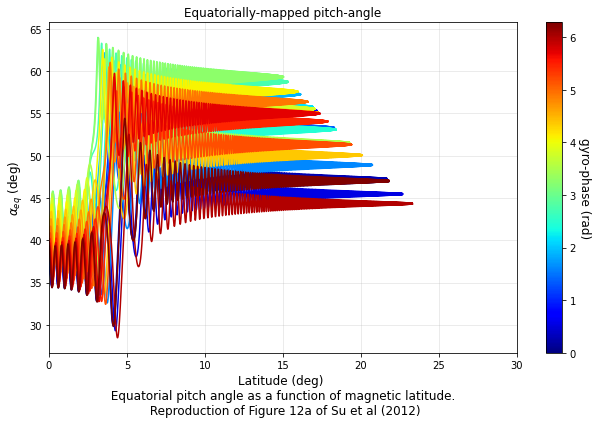

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg) \n Equatorial pitch angle as a function of magnetic latitude. \n Reproduction of Figure 12a of Su et al (2012)',fontsize=12)
ax.set_ylabel(r'$\alpha_{eq}$ (deg)',fontsize=12)
ax.set_title('Equatorially-mapped pitch-angle',fontsize=12)

ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=12)

#uncomment for saving the figure
plt.tight_layout()
plt.savefig('Figure_12a_of_Su_et_al_2012')

plt.show()

### Electron trajectories in the ν-η plane

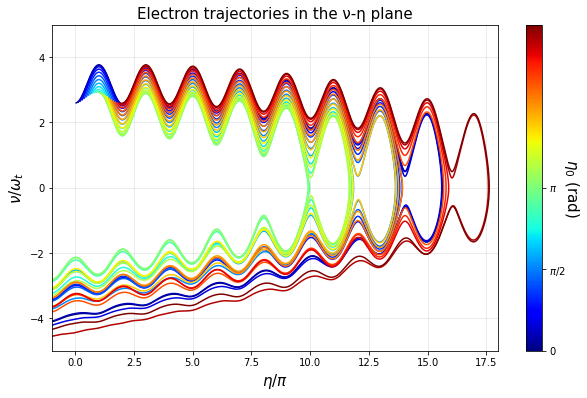

In [11]:
fonts=15
wtr=np.sqrt(wtrsq_out)

nplot=deta_dt/wtr
# print(wtr)


fig, ax = plt.subplots(figsize=(10,6))
s=5
last=1

for r in range(0,len(eta0)):
    ax.plot(eta[r,2:-last]/np.pi,nplot[r,2:-last],c=cmap.to_rgba(eta0[r]))

ax.grid(alpha=.3)
ax.set_xlim(-1,18)
ax.set_xlabel(r'$\eta/\pi$',fontsize=fonts)
ax.set_ylabel(r'$\nu/\omega_t$',fontsize=fonts)
ax.set_title('Electron trajectories in the ν-η plane',fontsize=fonts)
ax.set_ylim(-5,5)

cbar=fig.colorbar(cmap, ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi])
cbar.ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$', '0',r'$\pi/2$', r'$\pi$'])  # horizontal colorbar
cbar.set_label(r'$\eta_0$ (rad)', rotation=270,labelpad=15,fontsize=fonts)
plt.show()


### Equatorial pitch angle vs time

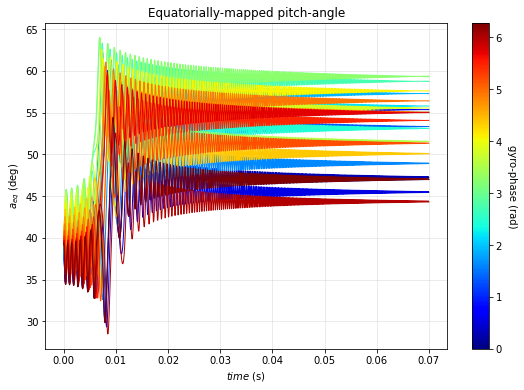

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(time[r,:-1],np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]), linewidth=1)
ax.grid(alpha=.3)
# ax.set_xlim(0,30)
ax.set_ylabel(r'$a_{eq}$ (deg)')
ax.set_xlabel(r'$time$ (s)')
ax.set_title('Equatorially-mapped pitch-angle',fontsize=12)

# ax.set_ylim(40,65)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)
plt.show()


### Equatorial pitch angle change vs initial wave-electorn phase

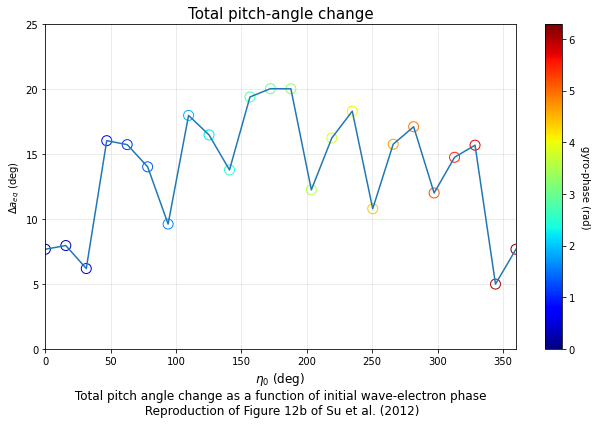

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
s=5

colors=eta0[:]
# for r in range(0,len(eta0)):
#     ax.plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.plot(np.rad2deg(eta0),dalpha)
ax.scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=100)
ax.set_xlim(0,360)
ax.set_xlabel('$\eta_0$ (deg) \n Total pitch angle change as a function of initial wave-electron phase \n Reproduction of Figure 12b of Su et al. (2012)',fontsize=12)
ax.set_ylabel(r'$\Delta a_{eq}$ (deg)')
ax.set_title('Total pitch-angle change',fontsize=15)
ax.set_ylim(0,25)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)

#uncomment for saving the figure
plt.tight_layout()
plt.savefig('Figure_12b_of_Su_et_al_2012')

plt.show()


### $d\eta/dt$ vs magnetic latitude

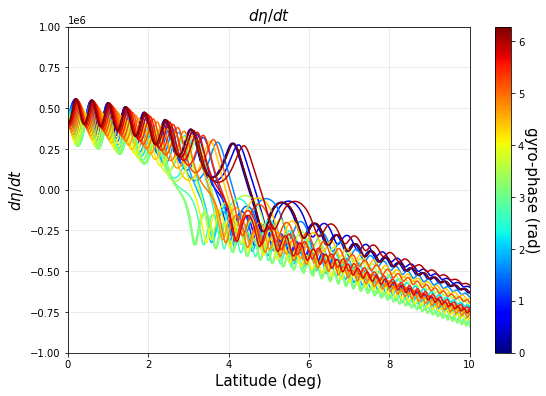

In [21]:
fig, ax = plt.subplots(figsize=(9,6))
s=5

for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(deta_dt[r,:-1]),c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,10)
ax.set_xlabel('Latitude (deg)',fontsize=15)
ax.set_ylabel(r'$d\eta/dt$ ',fontsize=15)
ax.set_title('$d\eta/dt$',fontsize=15)
ax.set_ylim(-1*10**6,1*10**6)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=15)
plt.show()


### Parallel momentum vs magnetic latitude

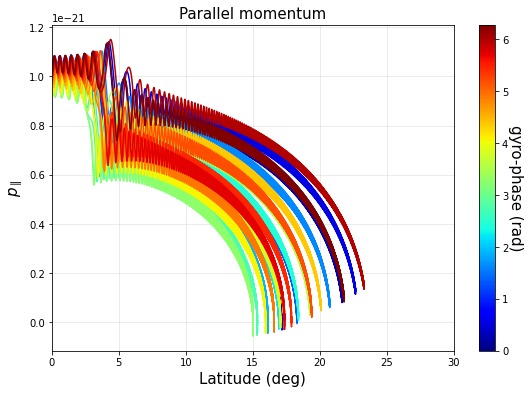

In [23]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),ppar[r,:-1],c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg)',fontsize=15)
ax.set_ylabel(r'$p_{\parallel}$',fontsize=15)
ax.set_title('Parallel momentum',fontsize=15)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=15)
plt.show()


### Perpendicular momentum vs magnetic latitude

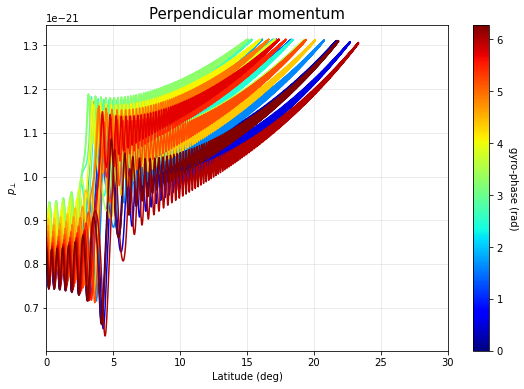

In [24]:
fig, ax = plt.subplots(figsize=(9,6))
s=5

for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),pper[r,:-1],c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel(r'$p_{\perp}$')
ax.set_title('Perpendicular momentum',fontsize=15)
ticks=np.arange(0,2*np.pi,1)

cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)

plt.show()

### Refractive index squared

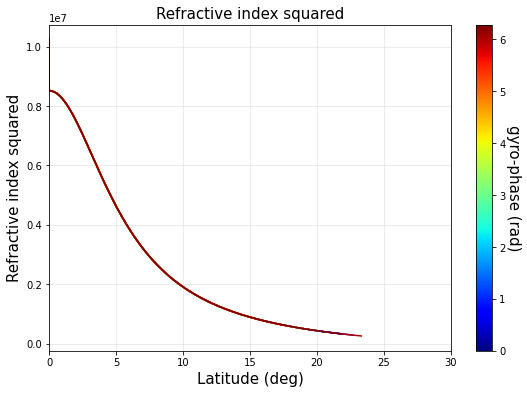

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),ref_sq[r,:-1],c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg)',fontsize=15)
ax.set_ylabel('Refractive index squared',fontsize=15)
ax.set_title('Refractive index squared',fontsize=15)
# ax.set_ylim(-2,2)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=15)
plt.show()


### Energy vs magnetic latitude

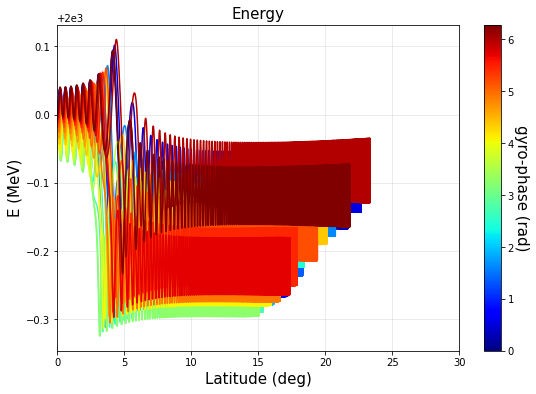

In [28]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),E_kin[r,:-1]*6.2415e15,c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg)',fontsize=15)
ax.set_ylabel('E (MeV)',fontsize=15)
ax.set_title('Energy',fontsize=15)
# ax.set_ylim(-1,2.5)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=15)
plt.show()



### Lorentz factor vs magnetic latitude

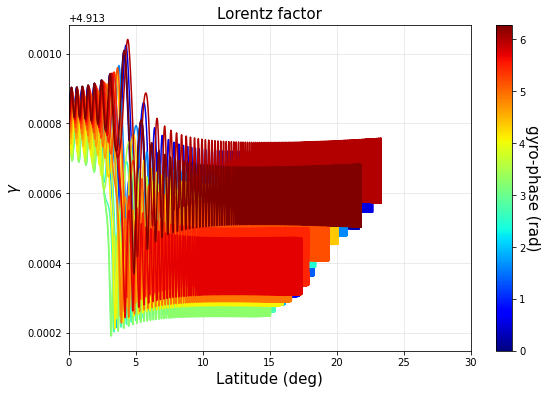

In [30]:
fig, ax = plt.subplots(figsize=(9,6))
s=5


for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),gamma[r,:-1],c=cmap.to_rgba(eta0[r]))
    
ax.grid(alpha=.3)
ax.set_xlim(0,30)
ax.set_xlabel('Latitude (deg)',fontsize=15)
ax.set_ylabel(r'$\gamma$',fontsize=15)
ax.set_title('Lorentz factor',fontsize=15)
# ax.set_ylim(-1,2.5)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15,fontsize=15)
plt.show()

